**this kernel was forked from here : https://www.kaggle.com/samusram/cloud-classifier-for-post-processing?scriptVersionId=20265194

i got 0.657 using densenet201(in version 3) **

i tried  efficientnetb4 but it failed for large image size,so i will try efficientnetb3 now with bce dice loss
if you find this kernel useful,please upvote,your upvote motivates kagglers like us to share things publicly,thanks

**Version 13**

- updating previously used submission.csv with version 3's generated submission file which achieved 0.657

- threshold = 0.9

- efficientnetb2

- loss='categorical_crossentropy', metrics=['accuracy']

# Intro
In this notebook I'd create a classifier to distinguish types of cloud formations. Using this classifier I'd check if it improves currently the best LB score from the great [public notebook by Jan](https://www.kaggle.com/jpbremer/efficient-net-b4-unet-clouds). 

# Plan
1. [Libraries](#Libraries)
2. [Data Generators](#Data-Generators)
  * [One-hot encoding classes](#One-hot-encoding-classes)
  * [Stratified split into train/val](#Stratified-split-into-train/val)
  * [Generator class](#Generator-class)
3. [PR-AUC-based Callback](#PR-AUC-based-Callback)
4. [Classifier](#Classifier)
  * [Defining a model](#Defining-a-model)
  * [Initial tuning of the added fully-connected layer](#Initial-tuning-of-the-added-fully-connected-layer)
  * [Fine-tuning the whole model](#Fine-tuning-the-whole-model)
  * [Visualizing train and val PR AUC](#Visualizing-train-and-val-PR-AUC)
5. [Selecting postprocessing thresholds](#Selecting-postprocessing-thresholds)
6. [Post-processing segmentation submission](#Post-processing-segmentation-submission)
7. [Future work](#Future-work)

# Libraries

In [1]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
from tensorflow import set_random_seed
set_random_seed(10)
%matplotlib inline

Using TensorFlow backend.


In [ ]:
!pip install keras-rectified-adam

In [2]:
test_imgs_folder = './input/test_images/'
train_imgs_folder = './input/train_images/'
num_cores = multiprocessing.cpu_count()

# Data Generators

## One-hot encoding classes

In [3]:
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Sugar, Fish, Flower}",1,1,1,0
2,0031ae9.jpg,"{Sugar, Fish, Flower}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Sugar, Fish, Gravel}",1,0,1,1


In [5]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

## Stratified split into train/val

In [6]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=17)

## Generator class

In [7]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, 
                 batch_size=16, shuffle=True, augmentation=None,
                 resized_height=350, resized_width=525, num_channels=3):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_width, self.resized_height), interpolation=cv2.INTER_AREA).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [8]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [25]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=6)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=6)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=6)

# Loss functions and variable learning rates

The callback would be used:
1. to estimate AUC under precision recall curve for each class,
2. to early stop after 5 epochs of no improvement in mean PR AUC,
3. save a model with the best PR AUC in validation,
4. to reduce learning rate on PR AUC plateau.

In [22]:
import keras.backend as K
from keras.losses import binary_crossentropy, mean_squared_error

def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss

def plateau_then_triangular_lr(epocs):
    plateau_steps = 4
    step_size = 2 
    min_lr = 1e-5
    max_lr = 1e-2
    
    if epocs < plateau_steps:
        return (min_lr + max_lr)/2
    
    cycle = np.floor(1+epocs/(2*step_size))
    x = np.abs(epocs/step_size - 2*cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1-x))/float(1.0**(cycle-1))
    print("NEW learing rate: " + str(lr))
    return lr

def plateau_then_decl_triangular_lr(epocs):
    plateau_steps = 3
    step_size = 2
    min_lr = 1e-6 #1e-5
    max_lr = 5e-4 #5e-3
    
    if epocs < plateau_steps:
        return (min_lr + max_lr)/2
    
    cycle = np.floor(1+epocs/(2*step_size))
    x = np.abs(epocs/step_size - 2*cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1-x))/float(1.2**(cycle-1))
    print("NEW learing rate: " + str(lr))
    return lr


# Classifier

## Defining a model

In [23]:
import efficientnet.keras as efn 
def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB3(weights='imagenet', include_top=False, pooling='avg', input_shape=(350, 525, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

In [12]:
from keras_radam import RAdam

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350, 525, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 175, 263, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 175, 263, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 175, 263, 40) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

__________________________________________________________________________________________________
block2a_project_bn (BatchNormal (None, 88, 132, 32)  128         block2a_project_conv[0][0]       
__________________________________________________________________________________________________
block2b_expand_conv (Conv2D)    (None, 88, 132, 192) 6144        block2a_project_bn[0][0]         
__________________________________________________________________________________________________
block2b_expand_bn (BatchNormali (None, 88, 132, 192) 768         block2b_expand_conv[0][0]        
__________________________________________________________________________________________________
block2b_expand_activation (Acti (None, 88, 132, 192) 0           block2b_expand_bn[0][0]          
__________________________________________________________________________________________________
block2b_dwconv (DepthwiseConv2D (None, 88, 132, 192) 1728        block2b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block3a_se_reduce (Conv2D)      (None, 1, 1, 8)      1544        block3a_se_reshape[0][0]         
__________________________________________________________________________________________________
block3a_se_expand (Conv2D)      (None, 1, 1, 192)    1728        block3a_se_reduce[0][0]          
__________________________________________________________________________________________________
block3a_se_excite (Multiply)    (None, 44, 66, 192)  0           block3a_activation[0][0]         
                                                                 block3a_se_expand[0][0]          
__________________________________________________________________________________________________
block3a_project_conv (Conv2D)   (None, 44, 66, 48)   9216        block3a_se_excite[0][0]          
__________________________________________________________________________________________________
block3a_pr

block4a_dwconv (DepthwiseConv2D (None, 22, 33, 288)  2592        block4a_expand_activation[0][0]  
__________________________________________________________________________________________________
block4a_bn (BatchNormalization) (None, 22, 33, 288)  1152        block4a_dwconv[0][0]             
__________________________________________________________________________________________________
block4a_activation (Activation) (None, 22, 33, 288)  0           block4a_bn[0][0]                 
__________________________________________________________________________________________________
block4a_se_squeeze (GlobalAvera (None, 288)          0           block4a_activation[0][0]         
__________________________________________________________________________________________________
block4a_se_reshape (Reshape)    (None, 1, 1, 288)    0           block4a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block4a_se

block4c_add (Add)               (None, 22, 33, 96)   0           block4c_drop[0][0]               
                                                                 block4b_add[0][0]                
__________________________________________________________________________________________________
block4d_expand_conv (Conv2D)    (None, 22, 33, 576)  55296       block4c_add[0][0]                
__________________________________________________________________________________________________
block4d_expand_bn (BatchNormali (None, 22, 33, 576)  2304        block4d_expand_conv[0][0]        
__________________________________________________________________________________________________
block4d_expand_activation (Acti (None, 22, 33, 576)  0           block4d_expand_bn[0][0]          
__________________________________________________________________________________________________
block4d_dwconv (DepthwiseConv2D (None, 22, 33, 576)  5184        block4d_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block5a_se_reduce (Conv2D)      (None, 1, 1, 24)     13848       block5a_se_reshape[0][0]         
__________________________________________________________________________________________________
block5a_se_expand (Conv2D)      (None, 1, 1, 576)    14400       block5a_se_reduce[0][0]          
__________________________________________________________________________________________________
block5a_se_excite (Multiply)    (None, 22, 33, 576)  0           block5a_activation[0][0]         
                                                                 block5a_se_expand[0][0]          
__________________________________________________________________________________________________
block5a_project_conv (Conv2D)   (None, 22, 33, 136)  78336       block5a_se_excite[0][0]          
__________________________________________________________________________________________________
block5a_pr

block5d_dwconv (DepthwiseConv2D (None, 22, 33, 816)  20400       block5d_expand_activation[0][0]  
__________________________________________________________________________________________________
block5d_bn (BatchNormalization) (None, 22, 33, 816)  3264        block5d_dwconv[0][0]             
__________________________________________________________________________________________________
block5d_activation (Activation) (None, 22, 33, 816)  0           block5d_bn[0][0]                 
__________________________________________________________________________________________________
block5d_se_squeeze (GlobalAvera (None, 816)          0           block5d_activation[0][0]         
__________________________________________________________________________________________________
block5d_se_reshape (Reshape)    (None, 1, 1, 816)    0           block5d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5d_se

__________________________________________________________________________________________________
block6a_project_bn (BatchNormal (None, 11, 17, 232)  928         block6a_project_conv[0][0]       
__________________________________________________________________________________________________
block6b_expand_conv (Conv2D)    (None, 11, 17, 1392) 322944      block6a_project_bn[0][0]         
__________________________________________________________________________________________________
block6b_expand_bn (BatchNormali (None, 11, 17, 1392) 5568        block6b_expand_conv[0][0]        
__________________________________________________________________________________________________
block6b_expand_activation (Acti (None, 11, 17, 1392) 0           block6b_expand_bn[0][0]          
__________________________________________________________________________________________________
block6b_dwconv (DepthwiseConv2D (None, 11, 17, 1392) 34800       block6b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block6d_se_reduce (Conv2D)      (None, 1, 1, 58)     80794       block6d_se_reshape[0][0]         
__________________________________________________________________________________________________
block6d_se_expand (Conv2D)      (None, 1, 1, 1392)   82128       block6d_se_reduce[0][0]          
__________________________________________________________________________________________________
block6d_se_excite (Multiply)    (None, 11, 17, 1392) 0           block6d_activation[0][0]         
                                                                 block6d_se_expand[0][0]          
__________________________________________________________________________________________________
block6d_project_conv (Conv2D)   (None, 11, 17, 232)  322944      block6d_se_excite[0][0]          
__________________________________________________________________________________________________
block6d_pr

__________________________________________________________________________________________________
block7a_expand_bn (BatchNormali (None, 11, 17, 1392) 5568        block7a_expand_conv[0][0]        
__________________________________________________________________________________________________
block7a_expand_activation (Acti (None, 11, 17, 1392) 0           block7a_expand_bn[0][0]          
__________________________________________________________________________________________________
block7a_dwconv (DepthwiseConv2D (None, 11, 17, 1392) 12528       block7a_expand_activation[0][0]  
__________________________________________________________________________________________________
block7a_bn (BatchNormalization) (None, 11, 17, 1392) 5568        block7a_dwconv[0][0]             
__________________________________________________________________________________________________
block7a_activation (Activation) (None, 11, 17, 1392) 0           block7a_bn[0][0]                 
__________

## Initial tuning of the added fully-connected layer

After unfreezing all the layers(except last 3) I set a less aggressive initial learning rate and train until early stopping (or 100 epochs max).

In [28]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')

    plt.figure()

    plt.plot(epochs, dice_coeff, 'r.')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training and validation Dice coef.')

    plt.show()

In [26]:
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard

model_file_name = 'Efficientnetb3_350x525_differnet_optimizers_etc_v1'

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=2, min_delta=1e-3),
             LearningRateScheduler(plateau_then_decl_triangular_lr),
             ModelCheckpoint(monitor='val_loss', filepath='./checkpoints/' + str(model_file_name) + '.h5', 
                             save_best_only=True, save_weights_only=False)]

model.compile(optimizer=RMSprop(lr=0.0005), loss=bce_dice_loss, metrics=['accuracy', dice_coeff])
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=12,
                              callbacks=callbacks,
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/12


131/739 [====>.........................] - ETA: 6:05:35 - loss: -0.7544 - acc: 0.0000e+00 - dice_coeff: 0.55 - ETA: 3:06:35 - loss: -0.7054 - acc: 0.0833 - dice_coeff: 0.5327   - ETA: 2:06:59 - loss: -0.8157 - acc: 0.0556 - dice_coeff: 0.57 - ETA: 1:37:08 - loss: -0.7750 - acc: 0.1250 - dice_coeff: 0.56 - ETA: 1:19:14 - loss: -0.7769 - acc: 0.1333 - dice_coeff: 0.56 - ETA: 1:07:17 - loss: -0.8398 - acc: 0.1667 - dice_coeff: 0.58 - ETA: 58:46 - loss: -0.8363 - acc: 0.1429 - dice_coeff: 0.5915 - ETA: 52:21 - loss: -0.8223 - acc: 0.1458 - dice_coeff: 0.58 - ETA: 47:23 - loss: -0.8390 - acc: 0.1296 - dice_coeff: 0.59 - ETA: 43:24 - loss: -0.8488 - acc: 0.1333 - dice_coeff: 0.60 - ETA: 40:08 - loss: -0.8569 - acc: 0.1667 - dice_coeff: 0.60 - ETA: 37:25 - loss: -0.8745 - acc: 0.1667 - dice_coeff: 0.61 - ETA: 35:07 - loss: -0.9033 - acc: 0.1667 - dice_coeff: 0.62 - ETA: 33:08 - loss: -0.9011 - acc: 0.1786 - dice_coeff: 0.62 - ETA: 31:24 - loss: -0.8960 - acc: 0.1667 - dice_coeff: 0.62 - ETA: 

263/739 [=========>....................] - ETA: 9:00 - loss: -1.0268 - acc: 0.3194 - dice_coeff: 0.686 - ETA: 8:58 - loss: -1.0268 - acc: 0.3183 - dice_coeff: 0.686 - ETA: 8:56 - loss: -1.0297 - acc: 0.3184 - dice_coeff: 0.687 - ETA: 8:54 - loss: -1.0297 - acc: 0.3198 - dice_coeff: 0.687 - ETA: 8:52 - loss: -1.0314 - acc: 0.3211 - dice_coeff: 0.687 - ETA: 8:51 - loss: -1.0327 - acc: 0.3212 - dice_coeff: 0.688 - ETA: 8:49 - loss: -1.0353 - acc: 0.3225 - dice_coeff: 0.688 - ETA: 8:47 - loss: -1.0354 - acc: 0.3225 - dice_coeff: 0.689 - ETA: 8:45 - loss: -1.0351 - acc: 0.3262 - dice_coeff: 0.688 - ETA: 8:43 - loss: -1.0353 - acc: 0.3298 - dice_coeff: 0.688 - ETA: 8:42 - loss: -1.0344 - acc: 0.3310 - dice_coeff: 0.688 - ETA: 8:40 - loss: -1.0373 - acc: 0.3310 - dice_coeff: 0.689 - ETA: 8:38 - loss: -1.0370 - acc: 0.3287 - dice_coeff: 0.689 - ETA: 8:37 - loss: -1.0378 - acc: 0.3287 - dice_coeff: 0.689 - ETA: 8:35 - loss: -1.0383 - acc: 0.3265 - dice_coeff: 0.689 - ETA: 8:33 - loss: -1.0391 -

395/739 [===============>..............] - ETA: 6:10 - loss: -1.0441 - acc: 0.3586 - dice_coeff: 0.691 - ETA: 6:09 - loss: -1.0443 - acc: 0.3591 - dice_coeff: 0.691 - ETA: 6:08 - loss: -1.0454 - acc: 0.3590 - dice_coeff: 0.692 - ETA: 6:07 - loss: -1.0455 - acc: 0.3583 - dice_coeff: 0.692 - ETA: 6:06 - loss: -1.0458 - acc: 0.3582 - dice_coeff: 0.692 - ETA: 6:05 - loss: -1.0461 - acc: 0.3575 - dice_coeff: 0.692 - ETA: 6:04 - loss: -1.0445 - acc: 0.3580 - dice_coeff: 0.692 - ETA: 6:03 - loss: -1.0457 - acc: 0.3579 - dice_coeff: 0.692 - ETA: 6:03 - loss: -1.0456 - acc: 0.3578 - dice_coeff: 0.692 - ETA: 6:02 - loss: -1.0470 - acc: 0.3578 - dice_coeff: 0.692 - ETA: 6:01 - loss: -1.0471 - acc: 0.3583 - dice_coeff: 0.693 - ETA: 6:00 - loss: -1.0463 - acc: 0.3576 - dice_coeff: 0.692 - ETA: 5:59 - loss: -1.0475 - acc: 0.3575 - dice_coeff: 0.693 - ETA: 5:58 - loss: -1.0462 - acc: 0.3574 - dice_coeff: 0.692 - ETA: 5:57 - loss: -1.0439 - acc: 0.3573 - dice_coeff: 0.692 - ETA: 5:56 - loss: -1.0443 -

527/739 [====================>.........] - ETA: 4:15 - loss: -1.0584 - acc: 0.3784 - dice_coeff: 0.697 - ETA: 4:14 - loss: -1.0582 - acc: 0.3787 - dice_coeff: 0.697 - ETA: 4:13 - loss: -1.0588 - acc: 0.3786 - dice_coeff: 0.697 - ETA: 4:12 - loss: -1.0591 - acc: 0.3789 - dice_coeff: 0.697 - ETA: 4:11 - loss: -1.0600 - acc: 0.3796 - dice_coeff: 0.698 - ETA: 4:10 - loss: -1.0608 - acc: 0.3791 - dice_coeff: 0.698 - ETA: 4:10 - loss: -1.0603 - acc: 0.3794 - dice_coeff: 0.698 - ETA: 4:09 - loss: -1.0610 - acc: 0.3801 - dice_coeff: 0.698 - ETA: 4:08 - loss: -1.0616 - acc: 0.3800 - dice_coeff: 0.698 - ETA: 4:07 - loss: -1.0613 - acc: 0.3794 - dice_coeff: 0.698 - ETA: 4:06 - loss: -1.0617 - acc: 0.3801 - dice_coeff: 0.698 - ETA: 4:06 - loss: -1.0618 - acc: 0.3804 - dice_coeff: 0.698 - ETA: 4:05 - loss: -1.0615 - acc: 0.3803 - dice_coeff: 0.698 - ETA: 4:04 - loss: -1.0618 - acc: 0.3802 - dice_coeff: 0.698 - ETA: 4:03 - loss: -1.0620 - acc: 0.3805 - dice_coeff: 0.698 - ETA: 4:02 - loss: -1.0619 -

659/739 [=========================>....] - ETA: 2:32 - loss: -1.0684 - acc: 0.3851 - dice_coeff: 0.701 - ETA: 2:32 - loss: -1.0684 - acc: 0.3853 - dice_coeff: 0.701 - ETA: 2:31 - loss: -1.0681 - acc: 0.3858 - dice_coeff: 0.701 - ETA: 2:30 - loss: -1.0685 - acc: 0.3858 - dice_coeff: 0.701 - ETA: 2:29 - loss: -1.0689 - acc: 0.3860 - dice_coeff: 0.701 - ETA: 2:29 - loss: -1.0687 - acc: 0.3865 - dice_coeff: 0.701 - ETA: 2:28 - loss: -1.0687 - acc: 0.3870 - dice_coeff: 0.701 - ETA: 2:27 - loss: -1.0684 - acc: 0.3866 - dice_coeff: 0.701 - ETA: 2:27 - loss: -1.0684 - acc: 0.3862 - dice_coeff: 0.701 - ETA: 2:26 - loss: -1.0684 - acc: 0.3864 - dice_coeff: 0.701 - ETA: 2:25 - loss: -1.0687 - acc: 0.3869 - dice_coeff: 0.701 - ETA: 2:24 - loss: -1.0689 - acc: 0.3868 - dice_coeff: 0.701 - ETA: 2:24 - loss: -1.0691 - acc: 0.3864 - dice_coeff: 0.701 - ETA: 2:23 - loss: -1.0693 - acc: 0.3866 - dice_coeff: 0.701 - ETA: 2:22 - loss: -1.0700 - acc: 0.3868 - dice_coeff: 0.702 - ETA: 2:21 - loss: -1.0699 -

739/739 [==============================] - ETA: 56s - loss: -1.0780 - acc: 0.3972 - dice_coeff: 0.70 - ETA: 55s - loss: -1.0778 - acc: 0.3969 - dice_coeff: 0.70 - ETA: 54s - loss: -1.0783 - acc: 0.3973 - dice_coeff: 0.70 - ETA: 54s - loss: -1.0782 - acc: 0.3979 - dice_coeff: 0.70 - ETA: 53s - loss: -1.0787 - acc: 0.3983 - dice_coeff: 0.70 - ETA: 52s - loss: -1.0790 - acc: 0.3985 - dice_coeff: 0.70 - ETA: 52s - loss: -1.0790 - acc: 0.3989 - dice_coeff: 0.70 - ETA: 51s - loss: -1.0791 - acc: 0.3991 - dice_coeff: 0.70 - ETA: 50s - loss: -1.0794 - acc: 0.3992 - dice_coeff: 0.70 - ETA: 49s - loss: -1.0791 - acc: 0.3991 - dice_coeff: 0.70 - ETA: 49s - loss: -1.0794 - acc: 0.3995 - dice_coeff: 0.70 - ETA: 48s - loss: -1.0797 - acc: 0.3994 - dice_coeff: 0.70 - ETA: 47s - loss: -1.0803 - acc: 0.3996 - dice_coeff: 0.70 - ETA: 47s - loss: -1.0805 - acc: 0.3997 - dice_coeff: 0.70 - ETA: 46s - loss: -1.0806 - acc: 0.3999 - dice_coeff: 0.70 - ETA: 45s - loss: -1.0807 - acc: 0.3998 - dice_coeff: 0.70

132/739 [====>.........................] - ETA: 8:29 - loss: -0.6684 - acc: 0.3333 - dice_coeff: 0.588 - ETA: 8:22 - loss: -0.5576 - acc: 0.2500 - dice_coeff: 0.584 - ETA: 8:16 - loss: -0.7533 - acc: 0.2778 - dice_coeff: 0.634 - ETA: 8:15 - loss: -0.7156 - acc: 0.3333 - dice_coeff: 0.620 - ETA: 8:12 - loss: -0.8315 - acc: 0.3000 - dice_coeff: 0.647 - ETA: 8:14 - loss: -0.8932 - acc: 0.3333 - dice_coeff: 0.661 - ETA: 8:11 - loss: -0.9774 - acc: 0.3571 - dice_coeff: 0.683 - ETA: 8:13 - loss: -0.9630 - acc: 0.3542 - dice_coeff: 0.679 - ETA: 8:10 - loss: -0.9963 - acc: 0.3889 - dice_coeff: 0.686 - ETA: 8:10 - loss: -1.0160 - acc: 0.3833 - dice_coeff: 0.690 - ETA: 8:08 - loss: -1.0225 - acc: 0.3788 - dice_coeff: 0.693 - ETA: 8:07 - loss: -1.0258 - acc: 0.3750 - dice_coeff: 0.694 - ETA: 8:06 - loss: -1.0305 - acc: 0.3718 - dice_coeff: 0.695 - ETA: 8:05 - loss: -1.0421 - acc: 0.3810 - dice_coeff: 0.697 - ETA: 8:05 - loss: -1.0360 - acc: 0.4111 - dice_coeff: 0.694 - ETA: 8:04 - loss: -1.0528 -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.1528 - acc: 0.4336 - dice_coeff: 0.730 - ETA: 6:44 - loss: -1.1511 - acc: 0.4328 - dice_coeff: 0.730 - ETA: 6:43 - loss: -1.1519 - acc: 0.4333 - dice_coeff: 0.730 - ETA: 6:43 - loss: -1.1475 - acc: 0.4338 - dice_coeff: 0.729 - ETA: 6:42 - loss: -1.1480 - acc: 0.4331 - dice_coeff: 0.729 - ETA: 6:41 - loss: -1.1477 - acc: 0.4324 - dice_coeff: 0.729 - ETA: 6:41 - loss: -1.1504 - acc: 0.4305 - dice_coeff: 0.729 - ETA: 6:40 - loss: -1.1519 - acc: 0.4286 - dice_coeff: 0.730 - ETA: 6:39 - loss: -1.1488 - acc: 0.4267 - dice_coeff: 0.729 - ETA: 6:38 - loss: -1.1477 - acc: 0.4284 - dice_coeff: 0.729 - ETA: 6:38 - loss: -1.1482 - acc: 0.4312 - dice_coeff: 0.729 - ETA: 6:37 - loss: -1.1450 - acc: 0.4317 - dice_coeff: 0.728 - ETA: 6:37 - loss: -1.1430 - acc: 0.4310 - dice_coeff: 0.727 - ETA: 6:36 - loss: -1.1436 - acc: 0.4315 - dice_coeff: 0.728 - ETA: 6:35 - loss: -1.1448 - acc: 0.4320 - dice_coeff: 0.728 - ETA: 6:34 - loss: -1.1439 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.1441 - acc: 0.4308 - dice_coeff: 0.727 - ETA: 5:15 - loss: -1.1447 - acc: 0.4292 - dice_coeff: 0.727 - ETA: 5:15 - loss: -1.1452 - acc: 0.4307 - dice_coeff: 0.728 - ETA: 5:14 - loss: -1.1462 - acc: 0.4297 - dice_coeff: 0.728 - ETA: 5:13 - loss: -1.1454 - acc: 0.4306 - dice_coeff: 0.728 - ETA: 5:13 - loss: -1.1451 - acc: 0.4309 - dice_coeff: 0.728 - ETA: 5:12 - loss: -1.1462 - acc: 0.4305 - dice_coeff: 0.728 - ETA: 5:11 - loss: -1.1459 - acc: 0.4301 - dice_coeff: 0.728 - ETA: 5:11 - loss: -1.1462 - acc: 0.4298 - dice_coeff: 0.728 - ETA: 5:10 - loss: -1.1471 - acc: 0.4313 - dice_coeff: 0.728 - ETA: 5:09 - loss: -1.1471 - acc: 0.4309 - dice_coeff: 0.728 - ETA: 5:09 - loss: -1.1466 - acc: 0.4300 - dice_coeff: 0.728 - ETA: 5:08 - loss: -1.1458 - acc: 0.4296 - dice_coeff: 0.728 - ETA: 5:07 - loss: -1.1461 - acc: 0.4305 - dice_coeff: 0.728 - ETA: 5:07 - loss: -1.1461 - acc: 0.4295 - dice_coeff: 0.728 - ETA: 5:06 - loss: -1.1465 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.1416 - acc: 0.4253 - dice_coeff: 0.726 - ETA: 3:47 - loss: -1.1420 - acc: 0.4255 - dice_coeff: 0.726 - ETA: 3:47 - loss: -1.1412 - acc: 0.4244 - dice_coeff: 0.726 - ETA: 3:46 - loss: -1.1411 - acc: 0.4246 - dice_coeff: 0.726 - ETA: 3:45 - loss: -1.1421 - acc: 0.4248 - dice_coeff: 0.726 - ETA: 3:45 - loss: -1.1425 - acc: 0.4250 - dice_coeff: 0.727 - ETA: 3:44 - loss: -1.1430 - acc: 0.4256 - dice_coeff: 0.727 - ETA: 3:43 - loss: -1.1427 - acc: 0.4257 - dice_coeff: 0.727 - ETA: 3:43 - loss: -1.1432 - acc: 0.4263 - dice_coeff: 0.727 - ETA: 3:42 - loss: -1.1441 - acc: 0.4261 - dice_coeff: 0.727 - ETA: 3:41 - loss: -1.1442 - acc: 0.4263 - dice_coeff: 0.727 - ETA: 3:41 - loss: -1.1448 - acc: 0.4261 - dice_coeff: 0.727 - ETA: 3:40 - loss: -1.1448 - acc: 0.4262 - dice_coeff: 0.727 - ETA: 3:39 - loss: -1.1448 - acc: 0.4268 - dice_coeff: 0.727 - ETA: 3:39 - loss: -1.1446 - acc: 0.4258 - dice_coeff: 0.727 - ETA: 3:38 - loss: -1.1445 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.1418 - acc: 0.4238 - dice_coeff: 0.727 - ETA: 2:19 - loss: -1.1409 - acc: 0.4236 - dice_coeff: 0.727 - ETA: 2:18 - loss: -1.1415 - acc: 0.4240 - dice_coeff: 0.727 - ETA: 2:18 - loss: -1.1408 - acc: 0.4239 - dice_coeff: 0.727 - ETA: 2:17 - loss: -1.1406 - acc: 0.4243 - dice_coeff: 0.726 - ETA: 2:16 - loss: -1.1404 - acc: 0.4242 - dice_coeff: 0.726 - ETA: 2:16 - loss: -1.1403 - acc: 0.4237 - dice_coeff: 0.726 - ETA: 2:15 - loss: -1.1406 - acc: 0.4238 - dice_coeff: 0.726 - ETA: 2:14 - loss: -1.1397 - acc: 0.4243 - dice_coeff: 0.726 - ETA: 2:14 - loss: -1.1403 - acc: 0.4247 - dice_coeff: 0.726 - ETA: 2:13 - loss: -1.1410 - acc: 0.4246 - dice_coeff: 0.727 - ETA: 2:12 - loss: -1.1410 - acc: 0.4241 - dice_coeff: 0.727 - ETA: 2:12 - loss: -1.1407 - acc: 0.4236 - dice_coeff: 0.726 - ETA: 2:11 - loss: -1.1408 - acc: 0.4237 - dice_coeff: 0.727 - ETA: 2:10 - loss: -1.1404 - acc: 0.4236 - dice_coeff: 0.726 - ETA: 2:10 - loss: -1.1405 -

739/739 [==============================] - ETA: 52s - loss: -1.1407 - acc: 0.4246 - dice_coeff: 0.72 - ETA: 51s - loss: -1.1407 - acc: 0.4245 - dice_coeff: 0.72 - ETA: 50s - loss: -1.1412 - acc: 0.4243 - dice_coeff: 0.72 - ETA: 50s - loss: -1.1417 - acc: 0.4244 - dice_coeff: 0.72 - ETA: 49s - loss: -1.1418 - acc: 0.4246 - dice_coeff: 0.72 - ETA: 48s - loss: -1.1419 - acc: 0.4247 - dice_coeff: 0.72 - ETA: 48s - loss: -1.1424 - acc: 0.4250 - dice_coeff: 0.72 - ETA: 47s - loss: -1.1421 - acc: 0.4251 - dice_coeff: 0.72 - ETA: 46s - loss: -1.1419 - acc: 0.4253 - dice_coeff: 0.72 - ETA: 46s - loss: -1.1418 - acc: 0.4259 - dice_coeff: 0.72 - ETA: 45s - loss: -1.1417 - acc: 0.4257 - dice_coeff: 0.72 - ETA: 44s - loss: -1.1419 - acc: 0.4253 - dice_coeff: 0.72 - ETA: 44s - loss: -1.1418 - acc: 0.4250 - dice_coeff: 0.72 - ETA: 43s - loss: -1.1423 - acc: 0.4248 - dice_coeff: 0.72 - ETA: 42s - loss: -1.1423 - acc: 0.4249 - dice_coeff: 0.72 - ETA: 42s - loss: -1.1422 - acc: 0.4246 - dice_coeff: 0.72

132/739 [====>.........................] - ETA: 8:29 - loss: -1.0930 - acc: 0.5000 - dice_coeff: 0.709 - ETA: 8:17 - loss: -0.9844 - acc: 0.6667 - dice_coeff: 0.670 - ETA: 8:16 - loss: -1.0289 - acc: 0.5000 - dice_coeff: 0.690 - ETA: 8:16 - loss: -1.1353 - acc: 0.5000 - dice_coeff: 0.724 - ETA: 8:12 - loss: -1.1700 - acc: 0.4667 - dice_coeff: 0.735 - ETA: 8:12 - loss: -1.2104 - acc: 0.4167 - dice_coeff: 0.749 - ETA: 8:11 - loss: -1.2426 - acc: 0.4762 - dice_coeff: 0.757 - ETA: 8:11 - loss: -1.2521 - acc: 0.4792 - dice_coeff: 0.759 - ETA: 8:10 - loss: -1.2655 - acc: 0.5000 - dice_coeff: 0.763 - ETA: 8:10 - loss: -1.2599 - acc: 0.5333 - dice_coeff: 0.761 - ETA: 8:09 - loss: -1.2489 - acc: 0.5303 - dice_coeff: 0.757 - ETA: 8:08 - loss: -1.1974 - acc: 0.5139 - dice_coeff: 0.742 - ETA: 8:07 - loss: -1.2203 - acc: 0.5385 - dice_coeff: 0.749 - ETA: 8:07 - loss: -1.2206 - acc: 0.5119 - dice_coeff: 0.749 - ETA: 8:06 - loss: -1.2289 - acc: 0.5111 - dice_coeff: 0.751 - ETA: 8:06 - loss: -1.2155 -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.1766 - acc: 0.4574 - dice_coeff: 0.735 - ETA: 6:44 - loss: -1.1738 - acc: 0.4577 - dice_coeff: 0.734 - ETA: 6:43 - loss: -1.1735 - acc: 0.4605 - dice_coeff: 0.734 - ETA: 6:43 - loss: -1.1759 - acc: 0.4620 - dice_coeff: 0.735 - ETA: 6:42 - loss: -1.1742 - acc: 0.4635 - dice_coeff: 0.734 - ETA: 6:41 - loss: -1.1723 - acc: 0.4614 - dice_coeff: 0.734 - ETA: 6:41 - loss: -1.1747 - acc: 0.4616 - dice_coeff: 0.735 - ETA: 6:40 - loss: -1.1738 - acc: 0.4607 - dice_coeff: 0.735 - ETA: 6:39 - loss: -1.1742 - acc: 0.4598 - dice_coeff: 0.735 - ETA: 6:39 - loss: -1.1751 - acc: 0.4589 - dice_coeff: 0.735 - ETA: 6:38 - loss: -1.1746 - acc: 0.4569 - dice_coeff: 0.735 - ETA: 6:37 - loss: -1.1755 - acc: 0.4549 - dice_coeff: 0.735 - ETA: 6:37 - loss: -1.1760 - acc: 0.4552 - dice_coeff: 0.735 - ETA: 6:36 - loss: -1.1759 - acc: 0.4566 - dice_coeff: 0.735 - ETA: 6:35 - loss: -1.1763 - acc: 0.4558 - dice_coeff: 0.735 - ETA: 6:35 - loss: -1.1780 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.1778 - acc: 0.4497 - dice_coeff: 0.738 - ETA: 5:15 - loss: -1.1780 - acc: 0.4505 - dice_coeff: 0.738 - ETA: 5:15 - loss: -1.1778 - acc: 0.4501 - dice_coeff: 0.738 - ETA: 5:14 - loss: -1.1774 - acc: 0.4496 - dice_coeff: 0.738 - ETA: 5:13 - loss: -1.1775 - acc: 0.4498 - dice_coeff: 0.738 - ETA: 5:13 - loss: -1.1767 - acc: 0.4500 - dice_coeff: 0.737 - ETA: 5:12 - loss: -1.1779 - acc: 0.4514 - dice_coeff: 0.738 - ETA: 5:11 - loss: -1.1793 - acc: 0.4510 - dice_coeff: 0.738 - ETA: 5:11 - loss: -1.1795 - acc: 0.4512 - dice_coeff: 0.738 - ETA: 5:10 - loss: -1.1777 - acc: 0.4507 - dice_coeff: 0.738 - ETA: 5:09 - loss: -1.1778 - acc: 0.4509 - dice_coeff: 0.738 - ETA: 5:09 - loss: -1.1788 - acc: 0.4511 - dice_coeff: 0.738 - ETA: 5:08 - loss: -1.1780 - acc: 0.4513 - dice_coeff: 0.738 - ETA: 5:07 - loss: -1.1773 - acc: 0.4502 - dice_coeff: 0.738 - ETA: 5:07 - loss: -1.1777 - acc: 0.4498 - dice_coeff: 0.738 - ETA: 5:06 - loss: -1.1776 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.1813 - acc: 0.4475 - dice_coeff: 0.740 - ETA: 3:47 - loss: -1.1818 - acc: 0.4472 - dice_coeff: 0.740 - ETA: 3:47 - loss: -1.1821 - acc: 0.4474 - dice_coeff: 0.740 - ETA: 3:46 - loss: -1.1826 - acc: 0.4471 - dice_coeff: 0.740 - ETA: 3:45 - loss: -1.1825 - acc: 0.4472 - dice_coeff: 0.740 - ETA: 3:44 - loss: -1.1825 - acc: 0.4482 - dice_coeff: 0.740 - ETA: 3:44 - loss: -1.1829 - acc: 0.4491 - dice_coeff: 0.740 - ETA: 3:43 - loss: -1.1822 - acc: 0.4493 - dice_coeff: 0.740 - ETA: 3:43 - loss: -1.1818 - acc: 0.4494 - dice_coeff: 0.740 - ETA: 3:42 - loss: -1.1826 - acc: 0.4491 - dice_coeff: 0.740 - ETA: 3:41 - loss: -1.1822 - acc: 0.4488 - dice_coeff: 0.740 - ETA: 3:41 - loss: -1.1826 - acc: 0.4502 - dice_coeff: 0.740 - ETA: 3:40 - loss: -1.1830 - acc: 0.4515 - dice_coeff: 0.740 - ETA: 3:39 - loss: -1.1832 - acc: 0.4524 - dice_coeff: 0.740 - ETA: 3:38 - loss: -1.1824 - acc: 0.4526 - dice_coeff: 0.740 - ETA: 3:38 - loss: -1.1828 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.1877 - acc: 0.4509 - dice_coeff: 0.742 - ETA: 2:19 - loss: -1.1880 - acc: 0.4506 - dice_coeff: 0.742 - ETA: 2:18 - loss: -1.1886 - acc: 0.4507 - dice_coeff: 0.742 - ETA: 2:18 - loss: -1.1885 - acc: 0.4499 - dice_coeff: 0.742 - ETA: 2:17 - loss: -1.1890 - acc: 0.4503 - dice_coeff: 0.742 - ETA: 2:16 - loss: -1.1887 - acc: 0.4498 - dice_coeff: 0.742 - ETA: 2:16 - loss: -1.1889 - acc: 0.4502 - dice_coeff: 0.742 - ETA: 2:15 - loss: -1.1889 - acc: 0.4502 - dice_coeff: 0.742 - ETA: 2:14 - loss: -1.1891 - acc: 0.4497 - dice_coeff: 0.742 - ETA: 2:14 - loss: -1.1894 - acc: 0.4495 - dice_coeff: 0.742 - ETA: 2:13 - loss: -1.1900 - acc: 0.4493 - dice_coeff: 0.742 - ETA: 2:12 - loss: -1.1900 - acc: 0.4494 - dice_coeff: 0.742 - ETA: 2:12 - loss: -1.1895 - acc: 0.4495 - dice_coeff: 0.742 - ETA: 2:11 - loss: -1.1889 - acc: 0.4496 - dice_coeff: 0.742 - ETA: 2:10 - loss: -1.1886 - acc: 0.4494 - dice_coeff: 0.742 - ETA: 2:10 - loss: -1.1884 -

739/739 [==============================] - ETA: 52s - loss: -1.1881 - acc: 0.4539 - dice_coeff: 0.74 - ETA: 51s - loss: -1.1883 - acc: 0.4539 - dice_coeff: 0.74 - ETA: 50s - loss: -1.1884 - acc: 0.4540 - dice_coeff: 0.74 - ETA: 50s - loss: -1.1879 - acc: 0.4536 - dice_coeff: 0.74 - ETA: 49s - loss: -1.1880 - acc: 0.4539 - dice_coeff: 0.74 - ETA: 48s - loss: -1.1879 - acc: 0.4542 - dice_coeff: 0.74 - ETA: 48s - loss: -1.1876 - acc: 0.4538 - dice_coeff: 0.74 - ETA: 47s - loss: -1.1878 - acc: 0.4536 - dice_coeff: 0.74 - ETA: 46s - loss: -1.1878 - acc: 0.4532 - dice_coeff: 0.74 - ETA: 46s - loss: -1.1879 - acc: 0.4532 - dice_coeff: 0.74 - ETA: 45s - loss: -1.1880 - acc: 0.4531 - dice_coeff: 0.74 - ETA: 44s - loss: -1.1879 - acc: 0.4531 - dice_coeff: 0.74 - ETA: 44s - loss: -1.1874 - acc: 0.4529 - dice_coeff: 0.74 - ETA: 43s - loss: -1.1877 - acc: 0.4530 - dice_coeff: 0.74 - ETA: 42s - loss: -1.1878 - acc: 0.4526 - dice_coeff: 0.74 - ETA: 42s - loss: -1.1878 - acc: 0.4524 - dice_coeff: 0.74

132/739 [====>.........................] - ETA: 8:18 - loss: -1.1908 - acc: 0.3333 - dice_coeff: 0.722 - ETA: 8:15 - loss: -1.1875 - acc: 0.1667 - dice_coeff: 0.733 - ETA: 8:14 - loss: -1.2227 - acc: 0.2222 - dice_coeff: 0.739 - ETA: 8:12 - loss: -1.2873 - acc: 0.2917 - dice_coeff: 0.760 - ETA: 8:10 - loss: -1.3088 - acc: 0.3667 - dice_coeff: 0.766 - ETA: 8:10 - loss: -1.3177 - acc: 0.4167 - dice_coeff: 0.770 - ETA: 8:08 - loss: -1.2706 - acc: 0.4048 - dice_coeff: 0.765 - ETA: 8:07 - loss: -1.2666 - acc: 0.3958 - dice_coeff: 0.766 - ETA: 8:07 - loss: -1.2644 - acc: 0.4074 - dice_coeff: 0.766 - ETA: 8:06 - loss: -1.2823 - acc: 0.4333 - dice_coeff: 0.769 - ETA: 8:06 - loss: -1.2776 - acc: 0.4545 - dice_coeff: 0.768 - ETA: 8:07 - loss: -1.2744 - acc: 0.4722 - dice_coeff: 0.766 - ETA: 8:06 - loss: -1.2891 - acc: 0.4615 - dice_coeff: 0.770 - ETA: 8:05 - loss: -1.2779 - acc: 0.4881 - dice_coeff: 0.766 - ETA: 8:04 - loss: -1.2714 - acc: 0.4667 - dice_coeff: 0.764 - ETA: 8:03 - loss: -1.2710 -

264/739 [=========>....................] - ETA: 6:44 - loss: -1.2282 - acc: 0.4549 - dice_coeff: 0.754 - ETA: 6:43 - loss: -1.2292 - acc: 0.4527 - dice_coeff: 0.754 - ETA: 6:42 - loss: -1.2304 - acc: 0.4506 - dice_coeff: 0.755 - ETA: 6:42 - loss: -1.2275 - acc: 0.4510 - dice_coeff: 0.754 - ETA: 6:41 - loss: -1.2293 - acc: 0.4513 - dice_coeff: 0.755 - ETA: 6:40 - loss: -1.2302 - acc: 0.4505 - dice_coeff: 0.755 - ETA: 6:40 - loss: -1.2314 - acc: 0.4520 - dice_coeff: 0.755 - ETA: 6:39 - loss: -1.2315 - acc: 0.4536 - dice_coeff: 0.755 - ETA: 6:38 - loss: -1.2313 - acc: 0.4515 - dice_coeff: 0.755 - ETA: 6:38 - loss: -1.2297 - acc: 0.4519 - dice_coeff: 0.755 - ETA: 6:37 - loss: -1.2284 - acc: 0.4510 - dice_coeff: 0.754 - ETA: 6:36 - loss: -1.2283 - acc: 0.4525 - dice_coeff: 0.754 - ETA: 6:36 - loss: -1.2294 - acc: 0.4563 - dice_coeff: 0.755 - ETA: 6:35 - loss: -1.2317 - acc: 0.4566 - dice_coeff: 0.755 - ETA: 6:34 - loss: -1.2297 - acc: 0.4569 - dice_coeff: 0.755 - ETA: 6:34 - loss: -1.2287 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.2166 - acc: 0.4415 - dice_coeff: 0.751 - ETA: 5:15 - loss: -1.2173 - acc: 0.4417 - dice_coeff: 0.751 - ETA: 5:14 - loss: -1.2177 - acc: 0.4401 - dice_coeff: 0.751 - ETA: 5:14 - loss: -1.2186 - acc: 0.4415 - dice_coeff: 0.752 - ETA: 5:13 - loss: -1.2197 - acc: 0.4424 - dice_coeff: 0.752 - ETA: 5:12 - loss: -1.2204 - acc: 0.4420 - dice_coeff: 0.752 - ETA: 5:12 - loss: -1.2213 - acc: 0.4422 - dice_coeff: 0.753 - ETA: 5:11 - loss: -1.2221 - acc: 0.4412 - dice_coeff: 0.753 - ETA: 5:10 - loss: -1.2220 - acc: 0.4420 - dice_coeff: 0.753 - ETA: 5:10 - loss: -1.2224 - acc: 0.4422 - dice_coeff: 0.753 - ETA: 5:09 - loss: -1.2229 - acc: 0.4424 - dice_coeff: 0.753 - ETA: 5:08 - loss: -1.2234 - acc: 0.4420 - dice_coeff: 0.753 - ETA: 5:08 - loss: -1.2237 - acc: 0.4428 - dice_coeff: 0.753 - ETA: 5:07 - loss: -1.2230 - acc: 0.4430 - dice_coeff: 0.753 - ETA: 5:06 - loss: -1.2216 - acc: 0.4432 - dice_coeff: 0.753 - ETA: 5:06 - loss: -1.2219 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.2176 - acc: 0.4429 - dice_coeff: 0.752 - ETA: 3:47 - loss: -1.2176 - acc: 0.4430 - dice_coeff: 0.752 - ETA: 3:46 - loss: -1.2175 - acc: 0.4424 - dice_coeff: 0.752 - ETA: 3:46 - loss: -1.2181 - acc: 0.4421 - dice_coeff: 0.752 - ETA: 3:45 - loss: -1.2178 - acc: 0.4418 - dice_coeff: 0.752 - ETA: 3:44 - loss: -1.2179 - acc: 0.4407 - dice_coeff: 0.752 - ETA: 3:44 - loss: -1.2181 - acc: 0.4404 - dice_coeff: 0.752 - ETA: 3:43 - loss: -1.2180 - acc: 0.4398 - dice_coeff: 0.752 - ETA: 3:42 - loss: -1.2180 - acc: 0.4395 - dice_coeff: 0.752 - ETA: 3:42 - loss: -1.2172 - acc: 0.4397 - dice_coeff: 0.752 - ETA: 3:41 - loss: -1.2171 - acc: 0.4390 - dice_coeff: 0.752 - ETA: 3:40 - loss: -1.2170 - acc: 0.4387 - dice_coeff: 0.751 - ETA: 3:40 - loss: -1.2171 - acc: 0.4381 - dice_coeff: 0.752 - ETA: 3:39 - loss: -1.2171 - acc: 0.4386 - dice_coeff: 0.752 - ETA: 3:38 - loss: -1.2176 - acc: 0.4384 - dice_coeff: 0.752 - ETA: 3:38 - loss: -1.2169 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.2058 - acc: 0.4405 - dice_coeff: 0.748 - ETA: 2:19 - loss: -1.2059 - acc: 0.4409 - dice_coeff: 0.748 - ETA: 2:18 - loss: -1.2056 - acc: 0.4407 - dice_coeff: 0.748 - ETA: 2:18 - loss: -1.2055 - acc: 0.4408 - dice_coeff: 0.748 - ETA: 2:17 - loss: -1.2058 - acc: 0.4412 - dice_coeff: 0.748 - ETA: 2:16 - loss: -1.2059 - acc: 0.4413 - dice_coeff: 0.748 - ETA: 2:16 - loss: -1.2057 - acc: 0.4417 - dice_coeff: 0.748 - ETA: 2:15 - loss: -1.2055 - acc: 0.4415 - dice_coeff: 0.748 - ETA: 2:14 - loss: -1.2051 - acc: 0.4417 - dice_coeff: 0.748 - ETA: 2:14 - loss: -1.2049 - acc: 0.4421 - dice_coeff: 0.748 - ETA: 2:13 - loss: -1.2049 - acc: 0.4419 - dice_coeff: 0.747 - ETA: 2:12 - loss: -1.2054 - acc: 0.4423 - dice_coeff: 0.748 - ETA: 2:12 - loss: -1.2053 - acc: 0.4427 - dice_coeff: 0.748 - ETA: 2:11 - loss: -1.2049 - acc: 0.4425 - dice_coeff: 0.748 - ETA: 2:10 - loss: -1.2046 - acc: 0.4420 - dice_coeff: 0.747 - ETA: 2:10 - loss: -1.2045 -

739/739 [==============================] - ETA: 52s - loss: -1.2062 - acc: 0.4455 - dice_coeff: 0.74 - ETA: 51s - loss: -1.2064 - acc: 0.4451 - dice_coeff: 0.74 - ETA: 50s - loss: -1.2064 - acc: 0.4447 - dice_coeff: 0.74 - ETA: 50s - loss: -1.2071 - acc: 0.4450 - dice_coeff: 0.74 - ETA: 49s - loss: -1.2067 - acc: 0.4451 - dice_coeff: 0.74 - ETA: 48s - loss: -1.2073 - acc: 0.4449 - dice_coeff: 0.74 - ETA: 48s - loss: -1.2075 - acc: 0.4450 - dice_coeff: 0.74 - ETA: 47s - loss: -1.2076 - acc: 0.4451 - dice_coeff: 0.74 - ETA: 46s - loss: -1.2070 - acc: 0.4444 - dice_coeff: 0.74 - ETA: 46s - loss: -1.2074 - acc: 0.4448 - dice_coeff: 0.74 - ETA: 45s - loss: -1.2076 - acc: 0.4446 - dice_coeff: 0.74 - ETA: 44s - loss: -1.2070 - acc: 0.4442 - dice_coeff: 0.74 - ETA: 44s - loss: -1.2066 - acc: 0.4440 - dice_coeff: 0.74 - ETA: 43s - loss: -1.2072 - acc: 0.4444 - dice_coeff: 0.74 - ETA: 42s - loss: -1.2070 - acc: 0.4440 - dice_coeff: 0.74 - ETA: 42s - loss: -1.2073 - acc: 0.4440 - dice_coeff: 0.74

132/739 [====>.........................] - ETA: 9:24 - loss: -0.6929 - acc: 0.3333 - dice_coeff: 0.599 - ETA: 8:56 - loss: -1.0369 - acc: 0.5833 - dice_coeff: 0.693 - ETA: 8:45 - loss: -1.1000 - acc: 0.5000 - dice_coeff: 0.711 - ETA: 8:37 - loss: -1.2666 - acc: 0.4583 - dice_coeff: 0.762 - ETA: 8:32 - loss: -1.2316 - acc: 0.4667 - dice_coeff: 0.752 - ETA: 8:29 - loss: -1.2148 - acc: 0.4167 - dice_coeff: 0.749 - ETA: 8:24 - loss: -1.1672 - acc: 0.4286 - dice_coeff: 0.739 - ETA: 8:22 - loss: -1.1527 - acc: 0.4167 - dice_coeff: 0.734 - ETA: 8:19 - loss: -1.1449 - acc: 0.4074 - dice_coeff: 0.732 - ETA: 8:18 - loss: -1.1482 - acc: 0.3833 - dice_coeff: 0.733 - ETA: 8:15 - loss: -1.1570 - acc: 0.3788 - dice_coeff: 0.735 - ETA: 8:14 - loss: -1.1670 - acc: 0.3611 - dice_coeff: 0.739 - ETA: 8:13 - loss: -1.1885 - acc: 0.3846 - dice_coeff: 0.744 - ETA: 8:12 - loss: -1.1752 - acc: 0.3690 - dice_coeff: 0.739 - ETA: 8:11 - loss: -1.1957 - acc: 0.3667 - dice_coeff: 0.744 - ETA: 8:10 - loss: -1.2182 -

264/739 [=========>....................] - ETA: 6:46 - loss: -1.1875 - acc: 0.4286 - dice_coeff: 0.746 - ETA: 6:45 - loss: -1.1876 - acc: 0.4279 - dice_coeff: 0.746 - ETA: 6:45 - loss: -1.1883 - acc: 0.4296 - dice_coeff: 0.746 - ETA: 6:44 - loss: -1.1878 - acc: 0.4289 - dice_coeff: 0.746 - ETA: 6:43 - loss: -1.1889 - acc: 0.4270 - dice_coeff: 0.747 - ETA: 6:42 - loss: -1.1892 - acc: 0.4275 - dice_coeff: 0.747 - ETA: 6:42 - loss: -1.1898 - acc: 0.4269 - dice_coeff: 0.747 - ETA: 6:41 - loss: -1.1864 - acc: 0.4298 - dice_coeff: 0.746 - ETA: 6:40 - loss: -1.1871 - acc: 0.4291 - dice_coeff: 0.746 - ETA: 6:40 - loss: -1.1887 - acc: 0.4296 - dice_coeff: 0.746 - ETA: 6:39 - loss: -1.1887 - acc: 0.4301 - dice_coeff: 0.746 - ETA: 6:38 - loss: -1.1868 - acc: 0.4306 - dice_coeff: 0.746 - ETA: 6:38 - loss: -1.1873 - acc: 0.4287 - dice_coeff: 0.746 - ETA: 6:37 - loss: -1.1883 - acc: 0.4281 - dice_coeff: 0.747 - ETA: 6:36 - loss: -1.1897 - acc: 0.4308 - dice_coeff: 0.747 - ETA: 6:36 - loss: -1.1899 -

396/739 [===============>..............] - ETA: 5:17 - loss: -1.1977 - acc: 0.4308 - dice_coeff: 0.748 - ETA: 5:16 - loss: -1.1991 - acc: 0.4311 - dice_coeff: 0.748 - ETA: 5:16 - loss: -1.1986 - acc: 0.4320 - dice_coeff: 0.748 - ETA: 5:15 - loss: -1.1990 - acc: 0.4328 - dice_coeff: 0.748 - ETA: 5:14 - loss: -1.1971 - acc: 0.4343 - dice_coeff: 0.748 - ETA: 5:14 - loss: -1.1976 - acc: 0.4352 - dice_coeff: 0.748 - ETA: 5:13 - loss: -1.1989 - acc: 0.4348 - dice_coeff: 0.748 - ETA: 5:12 - loss: -1.1982 - acc: 0.4338 - dice_coeff: 0.748 - ETA: 5:12 - loss: -1.1992 - acc: 0.4347 - dice_coeff: 0.748 - ETA: 5:11 - loss: -1.1990 - acc: 0.4355 - dice_coeff: 0.748 - ETA: 5:10 - loss: -1.1976 - acc: 0.4352 - dice_coeff: 0.748 - ETA: 5:10 - loss: -1.1985 - acc: 0.4348 - dice_coeff: 0.748 - ETA: 5:09 - loss: -1.1990 - acc: 0.4344 - dice_coeff: 0.748 - ETA: 5:08 - loss: -1.1991 - acc: 0.4341 - dice_coeff: 0.748 - ETA: 5:08 - loss: -1.1988 - acc: 0.4331 - dice_coeff: 0.748 - ETA: 5:07 - loss: -1.1992 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.2112 - acc: 0.4374 - dice_coeff: 0.752 - ETA: 3:48 - loss: -1.2110 - acc: 0.4376 - dice_coeff: 0.752 - ETA: 3:47 - loss: -1.2106 - acc: 0.4373 - dice_coeff: 0.752 - ETA: 3:46 - loss: -1.2109 - acc: 0.4371 - dice_coeff: 0.752 - ETA: 3:46 - loss: -1.2102 - acc: 0.4377 - dice_coeff: 0.752 - ETA: 3:45 - loss: -1.2110 - acc: 0.4374 - dice_coeff: 0.752 - ETA: 3:44 - loss: -1.2109 - acc: 0.4367 - dice_coeff: 0.752 - ETA: 3:44 - loss: -1.2095 - acc: 0.4365 - dice_coeff: 0.751 - ETA: 3:43 - loss: -1.2104 - acc: 0.4362 - dice_coeff: 0.752 - ETA: 3:42 - loss: -1.2098 - acc: 0.4356 - dice_coeff: 0.751 - ETA: 3:42 - loss: -1.2103 - acc: 0.4361 - dice_coeff: 0.752 - ETA: 3:41 - loss: -1.2108 - acc: 0.4363 - dice_coeff: 0.752 - ETA: 3:40 - loss: -1.2109 - acc: 0.4372 - dice_coeff: 0.752 - ETA: 3:40 - loss: -1.2103 - acc: 0.4370 - dice_coeff: 0.752 - ETA: 3:39 - loss: -1.2113 - acc: 0.4371 - dice_coeff: 0.752 - ETA: 3:38 - loss: -1.2112 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.2265 - acc: 0.4376 - dice_coeff: 0.756 - ETA: 2:19 - loss: -1.2265 - acc: 0.4377 - dice_coeff: 0.756 - ETA: 2:19 - loss: -1.2259 - acc: 0.4372 - dice_coeff: 0.756 - ETA: 2:18 - loss: -1.2262 - acc: 0.4367 - dice_coeff: 0.756 - ETA: 2:17 - loss: -1.2263 - acc: 0.4368 - dice_coeff: 0.756 - ETA: 2:17 - loss: -1.2265 - acc: 0.4370 - dice_coeff: 0.756 - ETA: 2:16 - loss: -1.2268 - acc: 0.4368 - dice_coeff: 0.756 - ETA: 2:15 - loss: -1.2262 - acc: 0.4366 - dice_coeff: 0.756 - ETA: 2:15 - loss: -1.2263 - acc: 0.4361 - dice_coeff: 0.756 - ETA: 2:14 - loss: -1.2262 - acc: 0.4359 - dice_coeff: 0.756 - ETA: 2:13 - loss: -1.2270 - acc: 0.4366 - dice_coeff: 0.756 - ETA: 2:13 - loss: -1.2269 - acc: 0.4370 - dice_coeff: 0.756 - ETA: 2:12 - loss: -1.2265 - acc: 0.4372 - dice_coeff: 0.756 - ETA: 2:11 - loss: -1.2266 - acc: 0.4370 - dice_coeff: 0.756 - ETA: 2:11 - loss: -1.2269 - acc: 0.4374 - dice_coeff: 0.756 - ETA: 2:10 - loss: -1.2270 -

739/739 [==============================] - ETA: 52s - loss: -1.2264 - acc: 0.4397 - dice_coeff: 0.75 - ETA: 51s - loss: -1.2267 - acc: 0.4396 - dice_coeff: 0.75 - ETA: 50s - loss: -1.2265 - acc: 0.4397 - dice_coeff: 0.75 - ETA: 50s - loss: -1.2267 - acc: 0.4395 - dice_coeff: 0.75 - ETA: 49s - loss: -1.2270 - acc: 0.4398 - dice_coeff: 0.75 - ETA: 48s - loss: -1.2269 - acc: 0.4397 - dice_coeff: 0.75 - ETA: 48s - loss: -1.2266 - acc: 0.4398 - dice_coeff: 0.75 - ETA: 47s - loss: -1.2263 - acc: 0.4401 - dice_coeff: 0.75 - ETA: 46s - loss: -1.2259 - acc: 0.4405 - dice_coeff: 0.75 - ETA: 46s - loss: -1.2258 - acc: 0.4400 - dice_coeff: 0.75 - ETA: 45s - loss: -1.2259 - acc: 0.4401 - dice_coeff: 0.75 - ETA: 44s - loss: -1.2262 - acc: 0.4405 - dice_coeff: 0.75 - ETA: 44s - loss: -1.2264 - acc: 0.4403 - dice_coeff: 0.75 - ETA: 43s - loss: -1.2266 - acc: 0.4404 - dice_coeff: 0.75 - ETA: 42s - loss: -1.2263 - acc: 0.4400 - dice_coeff: 0.75 - ETA: 42s - loss: -1.2258 - acc: 0.4396 - dice_coeff: 0.75

132/739 [====>.........................] - ETA: 8:44 - loss: -0.9877 - acc: 0.6667 - dice_coeff: 0.699 - ETA: 8:50 - loss: -1.1009 - acc: 0.5000 - dice_coeff: 0.719 - ETA: 8:44 - loss: -1.2141 - acc: 0.5556 - dice_coeff: 0.748 - ETA: 8:33 - loss: -1.1852 - acc: 0.6250 - dice_coeff: 0.740 - ETA: 8:28 - loss: -1.1173 - acc: 0.5667 - dice_coeff: 0.718 - ETA: 8:26 - loss: -1.1539 - acc: 0.5556 - dice_coeff: 0.728 - ETA: 8:22 - loss: -1.1521 - acc: 0.5714 - dice_coeff: 0.728 - ETA: 8:21 - loss: -1.1922 - acc: 0.5833 - dice_coeff: 0.739 - ETA: 8:18 - loss: -1.2420 - acc: 0.5556 - dice_coeff: 0.754 - ETA: 8:16 - loss: -1.2185 - acc: 0.5667 - dice_coeff: 0.748 - ETA: 8:15 - loss: -1.2252 - acc: 0.5758 - dice_coeff: 0.749 - ETA: 8:14 - loss: -1.2320 - acc: 0.5417 - dice_coeff: 0.752 - ETA: 8:13 - loss: -1.2297 - acc: 0.5385 - dice_coeff: 0.751 - ETA: 8:11 - loss: -1.1919 - acc: 0.5357 - dice_coeff: 0.742 - ETA: 8:09 - loss: -1.1956 - acc: 0.5333 - dice_coeff: 0.743 - ETA: 8:09 - loss: -1.2097 -

264/739 [=========>....................] - ETA: 6:46 - loss: -1.2531 - acc: 0.4586 - dice_coeff: 0.761 - ETA: 6:45 - loss: -1.2552 - acc: 0.4614 - dice_coeff: 0.762 - ETA: 6:44 - loss: -1.2560 - acc: 0.4630 - dice_coeff: 0.762 - ETA: 6:43 - loss: -1.2571 - acc: 0.4645 - dice_coeff: 0.762 - ETA: 6:43 - loss: -1.2571 - acc: 0.4647 - dice_coeff: 0.762 - ETA: 6:42 - loss: -1.2559 - acc: 0.4662 - dice_coeff: 0.762 - ETA: 6:42 - loss: -1.2545 - acc: 0.4676 - dice_coeff: 0.761 - ETA: 6:41 - loss: -1.2544 - acc: 0.4690 - dice_coeff: 0.761 - ETA: 6:40 - loss: -1.2555 - acc: 0.4681 - dice_coeff: 0.762 - ETA: 6:40 - loss: -1.2542 - acc: 0.4660 - dice_coeff: 0.761 - ETA: 6:39 - loss: -1.2559 - acc: 0.4685 - dice_coeff: 0.762 - ETA: 6:38 - loss: -1.2552 - acc: 0.4688 - dice_coeff: 0.761 - ETA: 6:38 - loss: -1.2567 - acc: 0.4724 - dice_coeff: 0.762 - ETA: 6:37 - loss: -1.2546 - acc: 0.4715 - dice_coeff: 0.761 - ETA: 6:36 - loss: -1.2548 - acc: 0.4705 - dice_coeff: 0.762 - ETA: 6:36 - loss: -1.2556 -

396/739 [===============>..............] - ETA: 5:17 - loss: -1.2561 - acc: 0.4648 - dice_coeff: 0.763 - ETA: 5:16 - loss: -1.2552 - acc: 0.4643 - dice_coeff: 0.763 - ETA: 5:15 - loss: -1.2562 - acc: 0.4650 - dice_coeff: 0.763 - ETA: 5:15 - loss: -1.2549 - acc: 0.4639 - dice_coeff: 0.763 - ETA: 5:14 - loss: -1.2550 - acc: 0.4634 - dice_coeff: 0.763 - ETA: 5:13 - loss: -1.2561 - acc: 0.4642 - dice_coeff: 0.763 - ETA: 5:13 - loss: -1.2568 - acc: 0.4649 - dice_coeff: 0.764 - ETA: 5:12 - loss: -1.2553 - acc: 0.4651 - dice_coeff: 0.763 - ETA: 5:11 - loss: -1.2547 - acc: 0.4658 - dice_coeff: 0.763 - ETA: 5:11 - loss: -1.2546 - acc: 0.4653 - dice_coeff: 0.763 - ETA: 5:10 - loss: -1.2534 - acc: 0.4648 - dice_coeff: 0.762 - ETA: 5:09 - loss: -1.2546 - acc: 0.4632 - dice_coeff: 0.763 - ETA: 5:09 - loss: -1.2540 - acc: 0.4651 - dice_coeff: 0.763 - ETA: 5:08 - loss: -1.2553 - acc: 0.4652 - dice_coeff: 0.763 - ETA: 5:07 - loss: -1.2550 - acc: 0.4659 - dice_coeff: 0.763 - ETA: 5:07 - loss: -1.2547 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.2497 - acc: 0.4689 - dice_coeff: 0.762 - ETA: 3:48 - loss: -1.2494 - acc: 0.4690 - dice_coeff: 0.762 - ETA: 3:47 - loss: -1.2491 - acc: 0.4695 - dice_coeff: 0.762 - ETA: 3:46 - loss: -1.2492 - acc: 0.4704 - dice_coeff: 0.762 - ETA: 3:46 - loss: -1.2495 - acc: 0.4697 - dice_coeff: 0.762 - ETA: 3:45 - loss: -1.2495 - acc: 0.4689 - dice_coeff: 0.762 - ETA: 3:44 - loss: -1.2489 - acc: 0.4690 - dice_coeff: 0.762 - ETA: 3:44 - loss: -1.2485 - acc: 0.4686 - dice_coeff: 0.761 - ETA: 3:43 - loss: -1.2481 - acc: 0.4679 - dice_coeff: 0.761 - ETA: 3:42 - loss: -1.2483 - acc: 0.4672 - dice_coeff: 0.761 - ETA: 3:42 - loss: -1.2486 - acc: 0.4672 - dice_coeff: 0.761 - ETA: 3:41 - loss: -1.2475 - acc: 0.4669 - dice_coeff: 0.761 - ETA: 3:40 - loss: -1.2476 - acc: 0.4674 - dice_coeff: 0.761 - ETA: 3:40 - loss: -1.2472 - acc: 0.4683 - dice_coeff: 0.761 - ETA: 3:39 - loss: -1.2467 - acc: 0.4688 - dice_coeff: 0.761 - ETA: 3:38 - loss: -1.2471 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.2486 - acc: 0.4745 - dice_coeff: 0.761 - ETA: 2:19 - loss: -1.2491 - acc: 0.4748 - dice_coeff: 0.761 - ETA: 2:19 - loss: -1.2493 - acc: 0.4755 - dice_coeff: 0.761 - ETA: 2:18 - loss: -1.2493 - acc: 0.4753 - dice_coeff: 0.761 - ETA: 2:17 - loss: -1.2494 - acc: 0.4753 - dice_coeff: 0.761 - ETA: 2:17 - loss: -1.2494 - acc: 0.4757 - dice_coeff: 0.761 - ETA: 2:16 - loss: -1.2493 - acc: 0.4751 - dice_coeff: 0.761 - ETA: 2:15 - loss: -1.2496 - acc: 0.4754 - dice_coeff: 0.761 - ETA: 2:15 - loss: -1.2505 - acc: 0.4755 - dice_coeff: 0.762 - ETA: 2:14 - loss: -1.2507 - acc: 0.4758 - dice_coeff: 0.762 - ETA: 2:13 - loss: -1.2513 - acc: 0.4759 - dice_coeff: 0.762 - ETA: 2:13 - loss: -1.2516 - acc: 0.4753 - dice_coeff: 0.762 - ETA: 2:12 - loss: -1.2518 - acc: 0.4747 - dice_coeff: 0.762 - ETA: 2:11 - loss: -1.2524 - acc: 0.4748 - dice_coeff: 0.762 - ETA: 2:11 - loss: -1.2524 - acc: 0.4748 - dice_coeff: 0.762 - ETA: 2:10 - loss: -1.2528 -

739/739 [==============================] - ETA: 52s - loss: -1.2524 - acc: 0.4730 - dice_coeff: 0.76 - ETA: 51s - loss: -1.2515 - acc: 0.4728 - dice_coeff: 0.76 - ETA: 50s - loss: -1.2516 - acc: 0.4726 - dice_coeff: 0.76 - ETA: 50s - loss: -1.2519 - acc: 0.4734 - dice_coeff: 0.76 - ETA: 49s - loss: -1.2522 - acc: 0.4732 - dice_coeff: 0.76 - ETA: 48s - loss: -1.2517 - acc: 0.4727 - dice_coeff: 0.76 - ETA: 48s - loss: -1.2518 - acc: 0.4730 - dice_coeff: 0.76 - ETA: 47s - loss: -1.2514 - acc: 0.4728 - dice_coeff: 0.76 - ETA: 46s - loss: -1.2517 - acc: 0.4728 - dice_coeff: 0.76 - ETA: 46s - loss: -1.2516 - acc: 0.4731 - dice_coeff: 0.76 - ETA: 45s - loss: -1.2514 - acc: 0.4727 - dice_coeff: 0.76 - ETA: 44s - loss: -1.2518 - acc: 0.4725 - dice_coeff: 0.76 - ETA: 44s - loss: -1.2516 - acc: 0.4720 - dice_coeff: 0.76 - ETA: 43s - loss: -1.2516 - acc: 0.4716 - dice_coeff: 0.76 - ETA: 42s - loss: -1.2517 - acc: 0.4716 - dice_coeff: 0.76 - ETA: 42s - loss: -1.2518 - acc: 0.4719 - dice_coeff: 0.76

132/739 [====>.........................] - ETA: 8:51 - loss: -1.2076 - acc: 0.5000 - dice_coeff: 0.755 - ETA: 8:43 - loss: -1.4061 - acc: 0.5833 - dice_coeff: 0.811 - ETA: 8:37 - loss: -1.4310 - acc: 0.5556 - dice_coeff: 0.816 - ETA: 8:31 - loss: -1.3976 - acc: 0.5417 - dice_coeff: 0.806 - ETA: 8:27 - loss: -1.3162 - acc: 0.4667 - dice_coeff: 0.785 - ETA: 8:22 - loss: -1.2615 - acc: 0.3889 - dice_coeff: 0.771 - ETA: 8:21 - loss: -1.2554 - acc: 0.3810 - dice_coeff: 0.772 - ETA: 8:18 - loss: -1.2229 - acc: 0.3750 - dice_coeff: 0.764 - ETA: 8:16 - loss: -1.2745 - acc: 0.4074 - dice_coeff: 0.777 - ETA: 8:14 - loss: -1.2794 - acc: 0.4000 - dice_coeff: 0.777 - ETA: 8:13 - loss: -1.2955 - acc: 0.4091 - dice_coeff: 0.781 - ETA: 8:11 - loss: -1.2982 - acc: 0.4167 - dice_coeff: 0.783 - ETA: 8:10 - loss: -1.2862 - acc: 0.3974 - dice_coeff: 0.780 - ETA: 8:09 - loss: -1.2858 - acc: 0.3929 - dice_coeff: 0.779 - ETA: 8:08 - loss: -1.2889 - acc: 0.4111 - dice_coeff: 0.781 - ETA: 8:07 - loss: -1.3037 -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.2523 - acc: 0.4398 - dice_coeff: 0.767 - ETA: 6:45 - loss: -1.2537 - acc: 0.4403 - dice_coeff: 0.767 - ETA: 6:44 - loss: -1.2515 - acc: 0.4420 - dice_coeff: 0.766 - ETA: 6:43 - loss: -1.2499 - acc: 0.4400 - dice_coeff: 0.766 - ETA: 6:43 - loss: -1.2523 - acc: 0.4404 - dice_coeff: 0.767 - ETA: 6:42 - loss: -1.2518 - acc: 0.4408 - dice_coeff: 0.767 - ETA: 6:41 - loss: -1.2529 - acc: 0.4412 - dice_coeff: 0.767 - ETA: 6:41 - loss: -1.2528 - acc: 0.4417 - dice_coeff: 0.767 - ETA: 6:40 - loss: -1.2547 - acc: 0.4444 - dice_coeff: 0.767 - ETA: 6:39 - loss: -1.2544 - acc: 0.4425 - dice_coeff: 0.767 - ETA: 6:39 - loss: -1.2493 - acc: 0.4429 - dice_coeff: 0.766 - ETA: 6:38 - loss: -1.2465 - acc: 0.4410 - dice_coeff: 0.765 - ETA: 6:37 - loss: -1.2432 - acc: 0.4437 - dice_coeff: 0.764 - ETA: 6:36 - loss: -1.2418 - acc: 0.4441 - dice_coeff: 0.764 - ETA: 6:36 - loss: -1.2422 - acc: 0.4444 - dice_coeff: 0.764 - ETA: 6:35 - loss: -1.2405 -

396/739 [===============>..............] - ETA: 5:17 - loss: -1.2311 - acc: 0.4409 - dice_coeff: 0.758 - ETA: 5:16 - loss: -1.2321 - acc: 0.4417 - dice_coeff: 0.759 - ETA: 5:15 - loss: -1.2326 - acc: 0.4407 - dice_coeff: 0.759 - ETA: 5:15 - loss: -1.2318 - acc: 0.4415 - dice_coeff: 0.759 - ETA: 5:14 - loss: -1.2322 - acc: 0.4418 - dice_coeff: 0.759 - ETA: 5:13 - loss: -1.2320 - acc: 0.4426 - dice_coeff: 0.759 - ETA: 5:13 - loss: -1.2317 - acc: 0.4428 - dice_coeff: 0.759 - ETA: 5:12 - loss: -1.2311 - acc: 0.4436 - dice_coeff: 0.759 - ETA: 5:11 - loss: -1.2311 - acc: 0.4438 - dice_coeff: 0.759 - ETA: 5:11 - loss: -1.2307 - acc: 0.4440 - dice_coeff: 0.758 - ETA: 5:10 - loss: -1.2315 - acc: 0.4430 - dice_coeff: 0.759 - ETA: 5:09 - loss: -1.2305 - acc: 0.4426 - dice_coeff: 0.758 - ETA: 5:09 - loss: -1.2295 - acc: 0.4416 - dice_coeff: 0.758 - ETA: 5:08 - loss: -1.2289 - acc: 0.4412 - dice_coeff: 0.758 - ETA: 5:07 - loss: -1.2279 - acc: 0.4415 - dice_coeff: 0.758 - ETA: 5:07 - loss: -1.2278 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.2243 - acc: 0.4362 - dice_coeff: 0.756 - ETA: 3:48 - loss: -1.2242 - acc: 0.4351 - dice_coeff: 0.756 - ETA: 3:47 - loss: -1.2250 - acc: 0.4353 - dice_coeff: 0.757 - ETA: 3:46 - loss: -1.2247 - acc: 0.4354 - dice_coeff: 0.757 - ETA: 3:46 - loss: -1.2243 - acc: 0.4356 - dice_coeff: 0.756 - ETA: 3:45 - loss: -1.2242 - acc: 0.4357 - dice_coeff: 0.756 - ETA: 3:44 - loss: -1.2243 - acc: 0.4359 - dice_coeff: 0.756 - ETA: 3:44 - loss: -1.2242 - acc: 0.4361 - dice_coeff: 0.756 - ETA: 3:43 - loss: -1.2242 - acc: 0.4366 - dice_coeff: 0.756 - ETA: 3:42 - loss: -1.2250 - acc: 0.4376 - dice_coeff: 0.757 - ETA: 3:42 - loss: -1.2256 - acc: 0.4373 - dice_coeff: 0.757 - ETA: 3:41 - loss: -1.2264 - acc: 0.4375 - dice_coeff: 0.757 - ETA: 3:40 - loss: -1.2263 - acc: 0.4364 - dice_coeff: 0.757 - ETA: 3:40 - loss: -1.2245 - acc: 0.4362 - dice_coeff: 0.757 - ETA: 3:39 - loss: -1.2248 - acc: 0.4363 - dice_coeff: 0.757 - ETA: 3:38 - loss: -1.2246 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.2132 - acc: 0.4335 - dice_coeff: 0.753 - ETA: 2:19 - loss: -1.2128 - acc: 0.4333 - dice_coeff: 0.753 - ETA: 2:19 - loss: -1.2128 - acc: 0.4338 - dice_coeff: 0.753 - ETA: 2:18 - loss: -1.2130 - acc: 0.4342 - dice_coeff: 0.753 - ETA: 2:17 - loss: -1.2131 - acc: 0.4346 - dice_coeff: 0.753 - ETA: 2:17 - loss: -1.2131 - acc: 0.4341 - dice_coeff: 0.753 - ETA: 2:16 - loss: -1.2130 - acc: 0.4333 - dice_coeff: 0.753 - ETA: 2:15 - loss: -1.2133 - acc: 0.4338 - dice_coeff: 0.753 - ETA: 2:15 - loss: -1.2129 - acc: 0.4339 - dice_coeff: 0.753 - ETA: 2:14 - loss: -1.2127 - acc: 0.4346 - dice_coeff: 0.753 - ETA: 2:13 - loss: -1.2129 - acc: 0.4344 - dice_coeff: 0.753 - ETA: 2:13 - loss: -1.2134 - acc: 0.4349 - dice_coeff: 0.753 - ETA: 2:12 - loss: -1.2136 - acc: 0.4347 - dice_coeff: 0.753 - ETA: 2:11 - loss: -1.2139 - acc: 0.4348 - dice_coeff: 0.753 - ETA: 2:11 - loss: -1.2141 - acc: 0.4349 - dice_coeff: 0.753 - ETA: 2:10 - loss: -1.2143 -

739/739 [==============================] - ETA: 52s - loss: -1.2096 - acc: 0.4339 - dice_coeff: 0.75 - ETA: 51s - loss: -1.2092 - acc: 0.4338 - dice_coeff: 0.75 - ETA: 50s - loss: -1.2085 - acc: 0.4341 - dice_coeff: 0.75 - ETA: 50s - loss: -1.2090 - acc: 0.4347 - dice_coeff: 0.75 - ETA: 49s - loss: -1.2090 - acc: 0.4351 - dice_coeff: 0.75 - ETA: 48s - loss: -1.2083 - acc: 0.4354 - dice_coeff: 0.75 - ETA: 48s - loss: -1.2084 - acc: 0.4353 - dice_coeff: 0.75 - ETA: 47s - loss: -1.2086 - acc: 0.4359 - dice_coeff: 0.75 - ETA: 46s - loss: -1.2090 - acc: 0.4362 - dice_coeff: 0.75 - ETA: 46s - loss: -1.2086 - acc: 0.4361 - dice_coeff: 0.75 - ETA: 45s - loss: -1.2079 - acc: 0.4359 - dice_coeff: 0.75 - ETA: 44s - loss: -1.2078 - acc: 0.4355 - dice_coeff: 0.75 - ETA: 44s - loss: -1.2080 - acc: 0.4356 - dice_coeff: 0.75 - ETA: 43s - loss: -1.2081 - acc: 0.4362 - dice_coeff: 0.75 - ETA: 42s - loss: -1.2080 - acc: 0.4358 - dice_coeff: 0.75 - ETA: 42s - loss: -1.2077 - acc: 0.4354 - dice_coeff: 0.75

132/739 [====>.........................] - ETA: 8:48 - loss: -1.3458 - acc: 0.3333 - dice_coeff: 0.782 - ETA: 8:43 - loss: -1.2452 - acc: 0.2500 - dice_coeff: 0.760 - ETA: 8:40 - loss: -1.2603 - acc: 0.3333 - dice_coeff: 0.763 - ETA: 8:32 - loss: -1.2630 - acc: 0.4583 - dice_coeff: 0.759 - ETA: 8:31 - loss: -1.2069 - acc: 0.4333 - dice_coeff: 0.741 - ETA: 8:26 - loss: -1.1797 - acc: 0.3889 - dice_coeff: 0.737 - ETA: 8:24 - loss: -1.2236 - acc: 0.3571 - dice_coeff: 0.750 - ETA: 8:21 - loss: -1.2556 - acc: 0.3750 - dice_coeff: 0.759 - ETA: 8:17 - loss: -1.2332 - acc: 0.3889 - dice_coeff: 0.754 - ETA: 8:17 - loss: -1.2187 - acc: 0.4000 - dice_coeff: 0.750 - ETA: 8:15 - loss: -1.2041 - acc: 0.4091 - dice_coeff: 0.746 - ETA: 8:14 - loss: -1.1744 - acc: 0.3750 - dice_coeff: 0.738 - ETA: 8:12 - loss: -1.1811 - acc: 0.3590 - dice_coeff: 0.740 - ETA: 8:11 - loss: -1.1856 - acc: 0.3810 - dice_coeff: 0.740 - ETA: 8:09 - loss: -1.1898 - acc: 0.3778 - dice_coeff: 0.741 - ETA: 8:09 - loss: -1.1813 -

264/739 [=========>....................] - ETA: 6:46 - loss: -1.2533 - acc: 0.4862 - dice_coeff: 0.761 - ETA: 6:45 - loss: -1.2525 - acc: 0.4863 - dice_coeff: 0.761 - ETA: 6:45 - loss: -1.2519 - acc: 0.4889 - dice_coeff: 0.761 - ETA: 6:44 - loss: -1.2528 - acc: 0.4877 - dice_coeff: 0.761 - ETA: 6:43 - loss: -1.2514 - acc: 0.4866 - dice_coeff: 0.761 - ETA: 6:43 - loss: -1.2514 - acc: 0.4867 - dice_coeff: 0.761 - ETA: 6:42 - loss: -1.2527 - acc: 0.4868 - dice_coeff: 0.761 - ETA: 6:41 - loss: -1.2527 - acc: 0.4857 - dice_coeff: 0.761 - ETA: 6:41 - loss: -1.2492 - acc: 0.4858 - dice_coeff: 0.760 - ETA: 6:40 - loss: -1.2509 - acc: 0.4836 - dice_coeff: 0.760 - ETA: 6:39 - loss: -1.2509 - acc: 0.4837 - dice_coeff: 0.760 - ETA: 6:39 - loss: -1.2515 - acc: 0.4803 - dice_coeff: 0.761 - ETA: 6:38 - loss: -1.2537 - acc: 0.4805 - dice_coeff: 0.761 - ETA: 6:37 - loss: -1.2529 - acc: 0.4806 - dice_coeff: 0.761 - ETA: 6:37 - loss: -1.2535 - acc: 0.4807 - dice_coeff: 0.761 - ETA: 6:36 - loss: -1.2546 -

396/739 [===============>..............] - ETA: 5:17 - loss: -1.2638 - acc: 0.4881 - dice_coeff: 0.765 - ETA: 5:16 - loss: -1.2626 - acc: 0.4875 - dice_coeff: 0.765 - ETA: 5:16 - loss: -1.2616 - acc: 0.4875 - dice_coeff: 0.764 - ETA: 5:15 - loss: -1.2617 - acc: 0.4888 - dice_coeff: 0.764 - ETA: 5:14 - loss: -1.2624 - acc: 0.4888 - dice_coeff: 0.765 - ETA: 5:14 - loss: -1.2622 - acc: 0.4895 - dice_coeff: 0.764 - ETA: 5:13 - loss: -1.2621 - acc: 0.4889 - dice_coeff: 0.765 - ETA: 5:12 - loss: -1.2627 - acc: 0.4890 - dice_coeff: 0.765 - ETA: 5:12 - loss: -1.2638 - acc: 0.4890 - dice_coeff: 0.765 - ETA: 5:11 - loss: -1.2642 - acc: 0.4884 - dice_coeff: 0.765 - ETA: 5:10 - loss: -1.2646 - acc: 0.4885 - dice_coeff: 0.765 - ETA: 5:10 - loss: -1.2647 - acc: 0.4891 - dice_coeff: 0.765 - ETA: 5:09 - loss: -1.2653 - acc: 0.4892 - dice_coeff: 0.765 - ETA: 5:08 - loss: -1.2641 - acc: 0.4892 - dice_coeff: 0.765 - ETA: 5:08 - loss: -1.2643 - acc: 0.4892 - dice_coeff: 0.765 - ETA: 5:07 - loss: -1.2645 -

528/739 [====================>.........] - ETA: 3:49 - loss: -1.2723 - acc: 0.4824 - dice_coeff: 0.767 - ETA: 3:48 - loss: -1.2718 - acc: 0.4824 - dice_coeff: 0.767 - ETA: 3:47 - loss: -1.2723 - acc: 0.4820 - dice_coeff: 0.767 - ETA: 3:47 - loss: -1.2718 - acc: 0.4825 - dice_coeff: 0.767 - ETA: 3:46 - loss: -1.2713 - acc: 0.4821 - dice_coeff: 0.767 - ETA: 3:45 - loss: -1.2717 - acc: 0.4826 - dice_coeff: 0.767 - ETA: 3:45 - loss: -1.2712 - acc: 0.4818 - dice_coeff: 0.767 - ETA: 3:44 - loss: -1.2714 - acc: 0.4818 - dice_coeff: 0.767 - ETA: 3:43 - loss: -1.2724 - acc: 0.4823 - dice_coeff: 0.767 - ETA: 3:43 - loss: -1.2716 - acc: 0.4823 - dice_coeff: 0.767 - ETA: 3:42 - loss: -1.2720 - acc: 0.4832 - dice_coeff: 0.767 - ETA: 3:41 - loss: -1.2713 - acc: 0.4828 - dice_coeff: 0.767 - ETA: 3:41 - loss: -1.2709 - acc: 0.4837 - dice_coeff: 0.767 - ETA: 3:40 - loss: -1.2705 - acc: 0.4837 - dice_coeff: 0.767 - ETA: 3:39 - loss: -1.2695 - acc: 0.4838 - dice_coeff: 0.767 - ETA: 3:39 - loss: -1.2698 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.2667 - acc: 0.4827 - dice_coeff: 0.766 - ETA: 2:20 - loss: -1.2667 - acc: 0.4824 - dice_coeff: 0.766 - ETA: 2:19 - loss: -1.2665 - acc: 0.4834 - dice_coeff: 0.766 - ETA: 2:18 - loss: -1.2663 - acc: 0.4831 - dice_coeff: 0.766 - ETA: 2:17 - loss: -1.2658 - acc: 0.4828 - dice_coeff: 0.766 - ETA: 2:17 - loss: -1.2656 - acc: 0.4825 - dice_coeff: 0.765 - ETA: 2:16 - loss: -1.2655 - acc: 0.4819 - dice_coeff: 0.765 - ETA: 2:15 - loss: -1.2651 - acc: 0.4817 - dice_coeff: 0.765 - ETA: 2:15 - loss: -1.2653 - acc: 0.4814 - dice_coeff: 0.765 - ETA: 2:14 - loss: -1.2651 - acc: 0.4814 - dice_coeff: 0.765 - ETA: 2:13 - loss: -1.2649 - acc: 0.4818 - dice_coeff: 0.765 - ETA: 2:13 - loss: -1.2654 - acc: 0.4815 - dice_coeff: 0.765 - ETA: 2:12 - loss: -1.2653 - acc: 0.4818 - dice_coeff: 0.765 - ETA: 2:11 - loss: -1.2661 - acc: 0.4819 - dice_coeff: 0.766 - ETA: 2:11 - loss: -1.2660 - acc: 0.4816 - dice_coeff: 0.765 - ETA: 2:10 - loss: -1.2664 -

739/739 [==============================] - ETA: 52s - loss: -1.2707 - acc: 0.4758 - dice_coeff: 0.76 - ETA: 51s - loss: -1.2709 - acc: 0.4758 - dice_coeff: 0.76 - ETA: 50s - loss: -1.2708 - acc: 0.4754 - dice_coeff: 0.76 - ETA: 50s - loss: -1.2703 - acc: 0.4749 - dice_coeff: 0.76 - ETA: 49s - loss: -1.2705 - acc: 0.4744 - dice_coeff: 0.76 - ETA: 48s - loss: -1.2706 - acc: 0.4740 - dice_coeff: 0.76 - ETA: 48s - loss: -1.2710 - acc: 0.4735 - dice_coeff: 0.76 - ETA: 47s - loss: -1.2708 - acc: 0.4736 - dice_coeff: 0.76 - ETA: 46s - loss: -1.2708 - acc: 0.4738 - dice_coeff: 0.76 - ETA: 46s - loss: -1.2704 - acc: 0.4734 - dice_coeff: 0.76 - ETA: 45s - loss: -1.2705 - acc: 0.4732 - dice_coeff: 0.76 - ETA: 44s - loss: -1.2705 - acc: 0.4732 - dice_coeff: 0.76 - ETA: 44s - loss: -1.2706 - acc: 0.4730 - dice_coeff: 0.76 - ETA: 43s - loss: -1.2707 - acc: 0.4730 - dice_coeff: 0.76 - ETA: 42s - loss: -1.2710 - acc: 0.4733 - dice_coeff: 0.76 - ETA: 42s - loss: -1.2710 - acc: 0.4729 - dice_coeff: 0.76

132/739 [====>.........................] - ETA: 8:27 - loss: -1.3372 - acc: 0.3333 - dice_coeff: 0.793 - ETA: 8:25 - loss: -1.3663 - acc: 0.4167 - dice_coeff: 0.808 - ETA: 8:19 - loss: -1.3754 - acc: 0.3889 - dice_coeff: 0.808 - ETA: 8:15 - loss: -1.2855 - acc: 0.4583 - dice_coeff: 0.775 - ETA: 8:12 - loss: -1.2937 - acc: 0.4667 - dice_coeff: 0.777 - ETA: 8:14 - loss: -1.3654 - acc: 0.5000 - dice_coeff: 0.798 - ETA: 8:11 - loss: -1.3406 - acc: 0.5000 - dice_coeff: 0.789 - ETA: 8:11 - loss: -1.2932 - acc: 0.5000 - dice_coeff: 0.776 - ETA: 8:09 - loss: -1.2551 - acc: 0.5000 - dice_coeff: 0.765 - ETA: 8:09 - loss: -1.2778 - acc: 0.4833 - dice_coeff: 0.772 - ETA: 8:07 - loss: -1.2692 - acc: 0.5152 - dice_coeff: 0.769 - ETA: 8:08 - loss: -1.2696 - acc: 0.5139 - dice_coeff: 0.769 - ETA: 8:06 - loss: -1.2968 - acc: 0.5385 - dice_coeff: 0.776 - ETA: 8:06 - loss: -1.3128 - acc: 0.5357 - dice_coeff: 0.781 - ETA: 8:05 - loss: -1.3235 - acc: 0.5333 - dice_coeff: 0.783 - ETA: 8:04 - loss: -1.3335 -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.3440 - acc: 0.4787 - dice_coeff: 0.789 - ETA: 6:44 - loss: -1.3461 - acc: 0.4813 - dice_coeff: 0.790 - ETA: 6:43 - loss: -1.3443 - acc: 0.4790 - dice_coeff: 0.789 - ETA: 6:43 - loss: -1.3468 - acc: 0.4767 - dice_coeff: 0.790 - ETA: 6:42 - loss: -1.3485 - acc: 0.4769 - dice_coeff: 0.790 - ETA: 6:41 - loss: -1.3475 - acc: 0.4795 - dice_coeff: 0.790 - ETA: 6:41 - loss: -1.3468 - acc: 0.4784 - dice_coeff: 0.790 - ETA: 6:40 - loss: -1.3473 - acc: 0.4786 - dice_coeff: 0.790 - ETA: 6:39 - loss: -1.3434 - acc: 0.4752 - dice_coeff: 0.789 - ETA: 6:39 - loss: -1.3450 - acc: 0.4765 - dice_coeff: 0.789 - ETA: 6:38 - loss: -1.3438 - acc: 0.4744 - dice_coeff: 0.789 - ETA: 6:37 - loss: -1.3446 - acc: 0.4757 - dice_coeff: 0.789 - ETA: 6:37 - loss: -1.3464 - acc: 0.4759 - dice_coeff: 0.790 - ETA: 6:36 - loss: -1.3470 - acc: 0.4760 - dice_coeff: 0.790 - ETA: 6:35 - loss: -1.3456 - acc: 0.4751 - dice_coeff: 0.789 - ETA: 6:35 - loss: -1.3442 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.3347 - acc: 0.4553 - dice_coeff: 0.787 - ETA: 5:16 - loss: -1.3325 - acc: 0.4549 - dice_coeff: 0.786 - ETA: 5:15 - loss: -1.3321 - acc: 0.4551 - dice_coeff: 0.786 - ETA: 5:15 - loss: -1.3316 - acc: 0.4540 - dice_coeff: 0.786 - ETA: 5:14 - loss: -1.3326 - acc: 0.4548 - dice_coeff: 0.786 - ETA: 5:13 - loss: -1.3309 - acc: 0.4556 - dice_coeff: 0.785 - ETA: 5:13 - loss: -1.3311 - acc: 0.4551 - dice_coeff: 0.786 - ETA: 5:12 - loss: -1.3318 - acc: 0.4553 - dice_coeff: 0.786 - ETA: 5:11 - loss: -1.3305 - acc: 0.4554 - dice_coeff: 0.785 - ETA: 5:11 - loss: -1.3302 - acc: 0.4556 - dice_coeff: 0.785 - ETA: 5:10 - loss: -1.3292 - acc: 0.4552 - dice_coeff: 0.785 - ETA: 5:09 - loss: -1.3291 - acc: 0.4547 - dice_coeff: 0.785 - ETA: 5:09 - loss: -1.3280 - acc: 0.4555 - dice_coeff: 0.785 - ETA: 5:08 - loss: -1.3280 - acc: 0.4550 - dice_coeff: 0.785 - ETA: 5:07 - loss: -1.3278 - acc: 0.4570 - dice_coeff: 0.784 - ETA: 5:07 - loss: -1.3281 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.3309 - acc: 0.4647 - dice_coeff: 0.786 - ETA: 3:47 - loss: -1.3307 - acc: 0.4652 - dice_coeff: 0.786 - ETA: 3:47 - loss: -1.3311 - acc: 0.4653 - dice_coeff: 0.786 - ETA: 3:46 - loss: -1.3312 - acc: 0.4650 - dice_coeff: 0.786 - ETA: 3:45 - loss: -1.3310 - acc: 0.4643 - dice_coeff: 0.786 - ETA: 3:45 - loss: -1.3315 - acc: 0.4639 - dice_coeff: 0.786 - ETA: 3:44 - loss: -1.3310 - acc: 0.4632 - dice_coeff: 0.786 - ETA: 3:43 - loss: -1.3315 - acc: 0.4637 - dice_coeff: 0.786 - ETA: 3:43 - loss: -1.3314 - acc: 0.4638 - dice_coeff: 0.786 - ETA: 3:42 - loss: -1.3316 - acc: 0.4647 - dice_coeff: 0.786 - ETA: 3:41 - loss: -1.3315 - acc: 0.4644 - dice_coeff: 0.786 - ETA: 3:41 - loss: -1.3310 - acc: 0.4645 - dice_coeff: 0.786 - ETA: 3:40 - loss: -1.3314 - acc: 0.4645 - dice_coeff: 0.786 - ETA: 3:39 - loss: -1.3318 - acc: 0.4650 - dice_coeff: 0.786 - ETA: 3:39 - loss: -1.3308 - acc: 0.4647 - dice_coeff: 0.786 - ETA: 3:38 - loss: -1.3304 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.3287 - acc: 0.4679 - dice_coeff: 0.786 - ETA: 2:19 - loss: -1.3283 - acc: 0.4682 - dice_coeff: 0.786 - ETA: 2:19 - loss: -1.3287 - acc: 0.4680 - dice_coeff: 0.786 - ETA: 2:18 - loss: -1.3286 - acc: 0.4677 - dice_coeff: 0.786 - ETA: 2:17 - loss: -1.3286 - acc: 0.4678 - dice_coeff: 0.786 - ETA: 2:17 - loss: -1.3290 - acc: 0.4679 - dice_coeff: 0.786 - ETA: 2:16 - loss: -1.3292 - acc: 0.4679 - dice_coeff: 0.786 - ETA: 2:15 - loss: -1.3289 - acc: 0.4680 - dice_coeff: 0.786 - ETA: 2:15 - loss: -1.3293 - acc: 0.4687 - dice_coeff: 0.786 - ETA: 2:14 - loss: -1.3291 - acc: 0.4687 - dice_coeff: 0.786 - ETA: 2:13 - loss: -1.3290 - acc: 0.4685 - dice_coeff: 0.786 - ETA: 2:13 - loss: -1.3289 - acc: 0.4682 - dice_coeff: 0.786 - ETA: 2:12 - loss: -1.3294 - acc: 0.4686 - dice_coeff: 0.786 - ETA: 2:11 - loss: -1.3296 - acc: 0.4686 - dice_coeff: 0.786 - ETA: 2:11 - loss: -1.3299 - acc: 0.4684 - dice_coeff: 0.786 - ETA: 2:10 - loss: -1.3303 -

739/739 [==============================] - ETA: 52s - loss: -1.3337 - acc: 0.4687 - dice_coeff: 0.78 - ETA: 51s - loss: -1.3335 - acc: 0.4683 - dice_coeff: 0.78 - ETA: 50s - loss: -1.3333 - acc: 0.4681 - dice_coeff: 0.78 - ETA: 50s - loss: -1.3329 - acc: 0.4681 - dice_coeff: 0.78 - ETA: 49s - loss: -1.3327 - acc: 0.4679 - dice_coeff: 0.78 - ETA: 48s - loss: -1.3327 - acc: 0.4682 - dice_coeff: 0.78 - ETA: 48s - loss: -1.3327 - acc: 0.4678 - dice_coeff: 0.78 - ETA: 47s - loss: -1.3323 - acc: 0.4678 - dice_coeff: 0.78 - ETA: 46s - loss: -1.3320 - acc: 0.4676 - dice_coeff: 0.78 - ETA: 46s - loss: -1.3321 - acc: 0.4682 - dice_coeff: 0.78 - ETA: 45s - loss: -1.3320 - acc: 0.4685 - dice_coeff: 0.78 - ETA: 44s - loss: -1.3323 - acc: 0.4683 - dice_coeff: 0.78 - ETA: 44s - loss: -1.3325 - acc: 0.4683 - dice_coeff: 0.78 - ETA: 43s - loss: -1.3325 - acc: 0.4679 - dice_coeff: 0.78 - ETA: 42s - loss: -1.3325 - acc: 0.4681 - dice_coeff: 0.78 - ETA: 42s - loss: -1.3326 - acc: 0.4679 - dice_coeff: 0.78

132/739 [====>.........................] - ETA: 8:17 - loss: -1.3277 - acc: 0.5000 - dice_coeff: 0.778 - ETA: 8:21 - loss: -1.3273 - acc: 0.5000 - dice_coeff: 0.794 - ETA: 8:16 - loss: -1.4356 - acc: 0.5000 - dice_coeff: 0.819 - ETA: 8:12 - loss: -1.4298 - acc: 0.4583 - dice_coeff: 0.818 - ETA: 8:12 - loss: -1.4490 - acc: 0.4333 - dice_coeff: 0.822 - ETA: 8:12 - loss: -1.3883 - acc: 0.4444 - dice_coeff: 0.800 - ETA: 8:10 - loss: -1.4089 - acc: 0.4048 - dice_coeff: 0.806 - ETA: 8:08 - loss: -1.4211 - acc: 0.4167 - dice_coeff: 0.810 - ETA: 8:08 - loss: -1.4134 - acc: 0.4259 - dice_coeff: 0.806 - ETA: 8:08 - loss: -1.3929 - acc: 0.4500 - dice_coeff: 0.801 - ETA: 8:07 - loss: -1.3384 - acc: 0.4242 - dice_coeff: 0.785 - ETA: 8:06 - loss: -1.3267 - acc: 0.4444 - dice_coeff: 0.783 - ETA: 8:04 - loss: -1.3277 - acc: 0.4359 - dice_coeff: 0.784 - ETA: 8:04 - loss: -1.3378 - acc: 0.4286 - dice_coeff: 0.788 - ETA: 8:04 - loss: -1.3280 - acc: 0.4222 - dice_coeff: 0.786 - ETA: 8:03 - loss: -1.3000 -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.3122 - acc: 0.4787 - dice_coeff: 0.782 - ETA: 6:44 - loss: -1.3116 - acc: 0.4789 - dice_coeff: 0.782 - ETA: 6:44 - loss: -1.3132 - acc: 0.4790 - dice_coeff: 0.783 - ETA: 6:43 - loss: -1.3138 - acc: 0.4792 - dice_coeff: 0.783 - ETA: 6:42 - loss: -1.3125 - acc: 0.4793 - dice_coeff: 0.783 - ETA: 6:42 - loss: -1.3113 - acc: 0.4783 - dice_coeff: 0.782 - ETA: 6:41 - loss: -1.3110 - acc: 0.4796 - dice_coeff: 0.782 - ETA: 6:40 - loss: -1.3119 - acc: 0.4798 - dice_coeff: 0.782 - ETA: 6:40 - loss: -1.3102 - acc: 0.4799 - dice_coeff: 0.782 - ETA: 6:39 - loss: -1.3128 - acc: 0.4789 - dice_coeff: 0.783 - ETA: 6:38 - loss: -1.3149 - acc: 0.4779 - dice_coeff: 0.783 - ETA: 6:38 - loss: -1.3125 - acc: 0.4745 - dice_coeff: 0.783 - ETA: 6:37 - loss: -1.3093 - acc: 0.4736 - dice_coeff: 0.782 - ETA: 6:36 - loss: -1.3090 - acc: 0.4726 - dice_coeff: 0.782 - ETA: 6:36 - loss: -1.3079 - acc: 0.4705 - dice_coeff: 0.782 - ETA: 6:35 - loss: -1.3101 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.3131 - acc: 0.4610 - dice_coeff: 0.782 - ETA: 5:16 - loss: -1.3140 - acc: 0.4624 - dice_coeff: 0.783 - ETA: 5:15 - loss: -1.3144 - acc: 0.4632 - dice_coeff: 0.783 - ETA: 5:14 - loss: -1.3145 - acc: 0.4633 - dice_coeff: 0.783 - ETA: 5:14 - loss: -1.3155 - acc: 0.4641 - dice_coeff: 0.783 - ETA: 5:13 - loss: -1.3163 - acc: 0.4636 - dice_coeff: 0.783 - ETA: 5:12 - loss: -1.3163 - acc: 0.4637 - dice_coeff: 0.783 - ETA: 5:12 - loss: -1.3163 - acc: 0.4632 - dice_coeff: 0.783 - ETA: 5:11 - loss: -1.3166 - acc: 0.4640 - dice_coeff: 0.783 - ETA: 5:10 - loss: -1.3172 - acc: 0.4635 - dice_coeff: 0.783 - ETA: 5:10 - loss: -1.3166 - acc: 0.4630 - dice_coeff: 0.783 - ETA: 5:09 - loss: -1.3167 - acc: 0.4632 - dice_coeff: 0.783 - ETA: 5:08 - loss: -1.3178 - acc: 0.4633 - dice_coeff: 0.784 - ETA: 5:08 - loss: -1.3168 - acc: 0.4622 - dice_coeff: 0.784 - ETA: 5:07 - loss: -1.3160 - acc: 0.4630 - dice_coeff: 0.783 - ETA: 5:06 - loss: -1.3140 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.3209 - acc: 0.4597 - dice_coeff: 0.785 - ETA: 3:47 - loss: -1.3214 - acc: 0.4594 - dice_coeff: 0.785 - ETA: 3:47 - loss: -1.3220 - acc: 0.4586 - dice_coeff: 0.786 - ETA: 3:46 - loss: -1.3221 - acc: 0.4583 - dice_coeff: 0.786 - ETA: 3:45 - loss: -1.3222 - acc: 0.4580 - dice_coeff: 0.786 - ETA: 3:45 - loss: -1.3209 - acc: 0.4585 - dice_coeff: 0.785 - ETA: 3:44 - loss: -1.3215 - acc: 0.4582 - dice_coeff: 0.785 - ETA: 3:43 - loss: -1.3205 - acc: 0.4587 - dice_coeff: 0.785 - ETA: 3:43 - loss: -1.3211 - acc: 0.4593 - dice_coeff: 0.785 - ETA: 3:42 - loss: -1.3212 - acc: 0.4594 - dice_coeff: 0.785 - ETA: 3:41 - loss: -1.3211 - acc: 0.4590 - dice_coeff: 0.785 - ETA: 3:41 - loss: -1.3212 - acc: 0.4587 - dice_coeff: 0.785 - ETA: 3:40 - loss: -1.3217 - acc: 0.4593 - dice_coeff: 0.786 - ETA: 3:39 - loss: -1.3217 - acc: 0.4598 - dice_coeff: 0.785 - ETA: 3:39 - loss: -1.3218 - acc: 0.4594 - dice_coeff: 0.785 - ETA: 3:38 - loss: -1.3216 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.3171 - acc: 0.4612 - dice_coeff: 0.784 - ETA: 2:19 - loss: -1.3174 - acc: 0.4616 - dice_coeff: 0.784 - ETA: 2:19 - loss: -1.3177 - acc: 0.4614 - dice_coeff: 0.784 - ETA: 2:18 - loss: -1.3170 - acc: 0.4608 - dice_coeff: 0.784 - ETA: 2:17 - loss: -1.3171 - acc: 0.4609 - dice_coeff: 0.784 - ETA: 2:17 - loss: -1.3169 - acc: 0.4610 - dice_coeff: 0.784 - ETA: 2:16 - loss: -1.3168 - acc: 0.4614 - dice_coeff: 0.784 - ETA: 2:15 - loss: -1.3169 - acc: 0.4611 - dice_coeff: 0.784 - ETA: 2:15 - loss: -1.3171 - acc: 0.4612 - dice_coeff: 0.784 - ETA: 2:14 - loss: -1.3174 - acc: 0.4616 - dice_coeff: 0.784 - ETA: 2:13 - loss: -1.3168 - acc: 0.4617 - dice_coeff: 0.784 - ETA: 2:13 - loss: -1.3165 - acc: 0.4620 - dice_coeff: 0.784 - ETA: 2:12 - loss: -1.3170 - acc: 0.4621 - dice_coeff: 0.784 - ETA: 2:11 - loss: -1.3165 - acc: 0.4625 - dice_coeff: 0.784 - ETA: 2:11 - loss: -1.3169 - acc: 0.4626 - dice_coeff: 0.784 - ETA: 2:10 - loss: -1.3170 -

739/739 [==============================] - ETA: 52s - loss: -1.3274 - acc: 0.4697 - dice_coeff: 0.78 - ETA: 51s - loss: -1.3277 - acc: 0.4693 - dice_coeff: 0.78 - ETA: 50s - loss: -1.3277 - acc: 0.4698 - dice_coeff: 0.78 - ETA: 50s - loss: -1.3275 - acc: 0.4704 - dice_coeff: 0.78 - ETA: 49s - loss: -1.3274 - acc: 0.4702 - dice_coeff: 0.78 - ETA: 48s - loss: -1.3280 - acc: 0.4705 - dice_coeff: 0.78 - ETA: 48s - loss: -1.3281 - acc: 0.4708 - dice_coeff: 0.78 - ETA: 47s - loss: -1.3276 - acc: 0.4708 - dice_coeff: 0.78 - ETA: 46s - loss: -1.3276 - acc: 0.4709 - dice_coeff: 0.78 - ETA: 46s - loss: -1.3279 - acc: 0.4706 - dice_coeff: 0.78 - ETA: 45s - loss: -1.3282 - acc: 0.4704 - dice_coeff: 0.78 - ETA: 44s - loss: -1.3281 - acc: 0.4705 - dice_coeff: 0.78 - ETA: 44s - loss: -1.3278 - acc: 0.4698 - dice_coeff: 0.78 - ETA: 43s - loss: -1.3281 - acc: 0.4698 - dice_coeff: 0.78 - ETA: 42s - loss: -1.3281 - acc: 0.4701 - dice_coeff: 0.78 - ETA: 42s - loss: -1.3286 - acc: 0.4699 - dice_coeff: 0.78

132/739 [====>.........................] - ETA: 8:43 - loss: -1.6331 - acc: 0.6667 - dice_coeff: 0.876 - ETA: 8:43 - loss: -1.5597 - acc: 0.5000 - dice_coeff: 0.855 - ETA: 8:41 - loss: -1.4774 - acc: 0.3333 - dice_coeff: 0.839 - ETA: 8:32 - loss: -1.4433 - acc: 0.3750 - dice_coeff: 0.827 - ETA: 8:30 - loss: -1.4368 - acc: 0.4000 - dice_coeff: 0.821 - ETA: 8:28 - loss: -1.4334 - acc: 0.3889 - dice_coeff: 0.822 - ETA: 8:26 - loss: -1.3808 - acc: 0.3810 - dice_coeff: 0.808 - ETA: 8:23 - loss: -1.4367 - acc: 0.4583 - dice_coeff: 0.824 - ETA: 8:21 - loss: -1.4254 - acc: 0.5000 - dice_coeff: 0.820 - ETA: 8:20 - loss: -1.4230 - acc: 0.5167 - dice_coeff: 0.817 - ETA: 8:17 - loss: -1.3973 - acc: 0.5000 - dice_coeff: 0.811 - ETA: 8:17 - loss: -1.3945 - acc: 0.4861 - dice_coeff: 0.811 - ETA: 8:16 - loss: -1.3958 - acc: 0.5000 - dice_coeff: 0.811 - ETA: 8:14 - loss: -1.3818 - acc: 0.5238 - dice_coeff: 0.806 - ETA: 8:12 - loss: -1.3784 - acc: 0.5333 - dice_coeff: 0.805 - ETA: 8:11 - loss: -1.3821 -

264/739 [=========>....................] - ETA: 6:47 - loss: -1.3471 - acc: 0.4875 - dice_coeff: 0.798 - ETA: 6:46 - loss: -1.3437 - acc: 0.4863 - dice_coeff: 0.797 - ETA: 6:45 - loss: -1.3457 - acc: 0.4889 - dice_coeff: 0.797 - ETA: 6:45 - loss: -1.3456 - acc: 0.4902 - dice_coeff: 0.797 - ETA: 6:44 - loss: -1.3429 - acc: 0.4903 - dice_coeff: 0.797 - ETA: 6:43 - loss: -1.3436 - acc: 0.4915 - dice_coeff: 0.797 - ETA: 6:43 - loss: -1.3410 - acc: 0.4904 - dice_coeff: 0.796 - ETA: 6:42 - loss: -1.3414 - acc: 0.4869 - dice_coeff: 0.796 - ETA: 6:41 - loss: -1.3397 - acc: 0.4846 - dice_coeff: 0.796 - ETA: 6:41 - loss: -1.3406 - acc: 0.4859 - dice_coeff: 0.796 - ETA: 6:40 - loss: -1.3413 - acc: 0.4848 - dice_coeff: 0.796 - ETA: 6:39 - loss: -1.3431 - acc: 0.4850 - dice_coeff: 0.797 - ETA: 6:39 - loss: -1.3427 - acc: 0.4839 - dice_coeff: 0.797 - ETA: 6:38 - loss: -1.3390 - acc: 0.4840 - dice_coeff: 0.796 - ETA: 6:37 - loss: -1.3391 - acc: 0.4830 - dice_coeff: 0.796 - ETA: 6:37 - loss: -1.3400 -

396/739 [===============>..............] - ETA: 5:18 - loss: -1.3252 - acc: 0.4792 - dice_coeff: 0.791 - ETA: 5:17 - loss: -1.3259 - acc: 0.4799 - dice_coeff: 0.791 - ETA: 5:16 - loss: -1.3260 - acc: 0.4813 - dice_coeff: 0.791 - ETA: 5:16 - loss: -1.3269 - acc: 0.4813 - dice_coeff: 0.791 - ETA: 5:15 - loss: -1.3274 - acc: 0.4820 - dice_coeff: 0.791 - ETA: 5:14 - loss: -1.3275 - acc: 0.4815 - dice_coeff: 0.791 - ETA: 5:14 - loss: -1.3275 - acc: 0.4815 - dice_coeff: 0.791 - ETA: 5:13 - loss: -1.3262 - acc: 0.4804 - dice_coeff: 0.791 - ETA: 5:12 - loss: -1.3277 - acc: 0.4805 - dice_coeff: 0.791 - ETA: 5:12 - loss: -1.3274 - acc: 0.4805 - dice_coeff: 0.791 - ETA: 5:11 - loss: -1.3278 - acc: 0.4812 - dice_coeff: 0.791 - ETA: 5:10 - loss: -1.3283 - acc: 0.4813 - dice_coeff: 0.791 - ETA: 5:09 - loss: -1.3278 - acc: 0.4801 - dice_coeff: 0.791 - ETA: 5:09 - loss: -1.3286 - acc: 0.4802 - dice_coeff: 0.791 - ETA: 5:08 - loss: -1.3284 - acc: 0.4791 - dice_coeff: 0.791 - ETA: 5:07 - loss: -1.3296 -

528/739 [====================>.........] - ETA: 3:49 - loss: -1.3260 - acc: 0.4790 - dice_coeff: 0.789 - ETA: 3:48 - loss: -1.3268 - acc: 0.4786 - dice_coeff: 0.789 - ETA: 3:48 - loss: -1.3274 - acc: 0.4795 - dice_coeff: 0.790 - ETA: 3:47 - loss: -1.3263 - acc: 0.4788 - dice_coeff: 0.789 - ETA: 3:46 - loss: -1.3260 - acc: 0.4780 - dice_coeff: 0.789 - ETA: 3:46 - loss: -1.3268 - acc: 0.4776 - dice_coeff: 0.789 - ETA: 3:45 - loss: -1.3266 - acc: 0.4781 - dice_coeff: 0.789 - ETA: 3:44 - loss: -1.3268 - acc: 0.4781 - dice_coeff: 0.789 - ETA: 3:44 - loss: -1.3270 - acc: 0.4774 - dice_coeff: 0.789 - ETA: 3:43 - loss: -1.3270 - acc: 0.4770 - dice_coeff: 0.789 - ETA: 3:42 - loss: -1.3274 - acc: 0.4771 - dice_coeff: 0.789 - ETA: 3:42 - loss: -1.3277 - acc: 0.4775 - dice_coeff: 0.789 - ETA: 3:41 - loss: -1.3274 - acc: 0.4768 - dice_coeff: 0.789 - ETA: 3:40 - loss: -1.3273 - acc: 0.4764 - dice_coeff: 0.789 - ETA: 3:40 - loss: -1.3278 - acc: 0.4761 - dice_coeff: 0.790 - ETA: 3:39 - loss: -1.3276 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.3125 - acc: 0.4757 - dice_coeff: 0.785 - ETA: 2:20 - loss: -1.3132 - acc: 0.4764 - dice_coeff: 0.785 - ETA: 2:19 - loss: -1.3134 - acc: 0.4758 - dice_coeff: 0.785 - ETA: 2:18 - loss: -1.3133 - acc: 0.4762 - dice_coeff: 0.785 - ETA: 2:18 - loss: -1.3135 - acc: 0.4769 - dice_coeff: 0.785 - ETA: 2:17 - loss: -1.3132 - acc: 0.4766 - dice_coeff: 0.785 - ETA: 2:16 - loss: -1.3128 - acc: 0.4766 - dice_coeff: 0.785 - ETA: 2:16 - loss: -1.3127 - acc: 0.4770 - dice_coeff: 0.785 - ETA: 2:15 - loss: -1.3132 - acc: 0.4770 - dice_coeff: 0.785 - ETA: 2:14 - loss: -1.3131 - acc: 0.4768 - dice_coeff: 0.785 - ETA: 2:14 - loss: -1.3123 - acc: 0.4774 - dice_coeff: 0.785 - ETA: 2:13 - loss: -1.3116 - acc: 0.4769 - dice_coeff: 0.784 - ETA: 2:12 - loss: -1.3122 - acc: 0.4772 - dice_coeff: 0.785 - ETA: 2:12 - loss: -1.3125 - acc: 0.4776 - dice_coeff: 0.785 - ETA: 2:11 - loss: -1.3123 - acc: 0.4779 - dice_coeff: 0.785 - ETA: 2:10 - loss: -1.3123 -

739/739 [==============================] - ETA: 52s - loss: -1.3061 - acc: 0.4783 - dice_coeff: 0.78 - ETA: 51s - loss: -1.3058 - acc: 0.4783 - dice_coeff: 0.78 - ETA: 50s - loss: -1.3059 - acc: 0.4784 - dice_coeff: 0.78 - ETA: 50s - loss: -1.3058 - acc: 0.4782 - dice_coeff: 0.78 - ETA: 49s - loss: -1.3060 - acc: 0.4784 - dice_coeff: 0.78 - ETA: 48s - loss: -1.3063 - acc: 0.4785 - dice_coeff: 0.78 - ETA: 48s - loss: -1.3066 - acc: 0.4785 - dice_coeff: 0.78 - ETA: 47s - loss: -1.3067 - acc: 0.4785 - dice_coeff: 0.78 - ETA: 46s - loss: -1.3065 - acc: 0.4788 - dice_coeff: 0.78 - ETA: 46s - loss: -1.3065 - acc: 0.4786 - dice_coeff: 0.78 - ETA: 45s - loss: -1.3059 - acc: 0.4781 - dice_coeff: 0.78 - ETA: 44s - loss: -1.3055 - acc: 0.4782 - dice_coeff: 0.78 - ETA: 44s - loss: -1.3059 - acc: 0.4782 - dice_coeff: 0.78 - ETA: 43s - loss: -1.3060 - acc: 0.4782 - dice_coeff: 0.78 - ETA: 42s - loss: -1.3060 - acc: 0.4785 - dice_coeff: 0.78 - ETA: 42s - loss: -1.3057 - acc: 0.4778 - dice_coeff: 0.78

132/739 [====>.........................] - ETA: 8:57 - loss: -1.3933 - acc: 0.6667 - dice_coeff: 0.806 - ETA: 8:47 - loss: -1.3796 - acc: 0.5000 - dice_coeff: 0.797 - ETA: 8:39 - loss: -1.4807 - acc: 0.5556 - dice_coeff: 0.828 - ETA: 8:34 - loss: -1.4209 - acc: 0.6250 - dice_coeff: 0.808 - ETA: 8:30 - loss: -1.3820 - acc: 0.5667 - dice_coeff: 0.800 - ETA: 8:26 - loss: -1.4259 - acc: 0.5556 - dice_coeff: 0.814 - ETA: 8:25 - loss: -1.3560 - acc: 0.5476 - dice_coeff: 0.796 - ETA: 8:22 - loss: -1.3018 - acc: 0.5625 - dice_coeff: 0.778 - ETA: 8:19 - loss: -1.2967 - acc: 0.5926 - dice_coeff: 0.775 - ETA: 8:16 - loss: -1.2983 - acc: 0.5500 - dice_coeff: 0.776 - ETA: 8:16 - loss: -1.2858 - acc: 0.5455 - dice_coeff: 0.774 - ETA: 8:14 - loss: -1.2919 - acc: 0.5139 - dice_coeff: 0.777 - ETA: 8:13 - loss: -1.2999 - acc: 0.5128 - dice_coeff: 0.779 - ETA: 8:11 - loss: -1.2995 - acc: 0.5119 - dice_coeff: 0.778 - ETA: 8:09 - loss: -1.3162 - acc: 0.5000 - dice_coeff: 0.783 - ETA: 8:09 - loss: -1.3032 -

264/739 [=========>....................] - ETA: 6:46 - loss: -1.3562 - acc: 0.4987 - dice_coeff: 0.795 - ETA: 6:45 - loss: -1.3577 - acc: 0.5012 - dice_coeff: 0.795 - ETA: 6:45 - loss: -1.3587 - acc: 0.5000 - dice_coeff: 0.795 - ETA: 6:44 - loss: -1.3577 - acc: 0.5000 - dice_coeff: 0.795 - ETA: 6:43 - loss: -1.3585 - acc: 0.5000 - dice_coeff: 0.796 - ETA: 6:43 - loss: -1.3575 - acc: 0.4988 - dice_coeff: 0.796 - ETA: 6:42 - loss: -1.3589 - acc: 0.4988 - dice_coeff: 0.796 - ETA: 6:41 - loss: -1.3596 - acc: 0.5000 - dice_coeff: 0.796 - ETA: 6:41 - loss: -1.3596 - acc: 0.5000 - dice_coeff: 0.796 - ETA: 6:40 - loss: -1.3604 - acc: 0.5000 - dice_coeff: 0.797 - ETA: 6:39 - loss: -1.3608 - acc: 0.4988 - dice_coeff: 0.797 - ETA: 6:39 - loss: -1.3616 - acc: 0.5012 - dice_coeff: 0.797 - ETA: 6:38 - loss: -1.3619 - acc: 0.5034 - dice_coeff: 0.797 - ETA: 6:37 - loss: -1.3628 - acc: 0.5023 - dice_coeff: 0.797 - ETA: 6:37 - loss: -1.3629 - acc: 0.5023 - dice_coeff: 0.797 - ETA: 6:36 - loss: -1.3623 -

396/739 [===============>..............] - ETA: 5:17 - loss: -1.3727 - acc: 0.4874 - dice_coeff: 0.801 - ETA: 5:16 - loss: -1.3729 - acc: 0.4881 - dice_coeff: 0.801 - ETA: 5:16 - loss: -1.3725 - acc: 0.4881 - dice_coeff: 0.801 - ETA: 5:15 - loss: -1.3734 - acc: 0.4882 - dice_coeff: 0.801 - ETA: 5:14 - loss: -1.3749 - acc: 0.4876 - dice_coeff: 0.801 - ETA: 5:14 - loss: -1.3750 - acc: 0.4864 - dice_coeff: 0.801 - ETA: 5:13 - loss: -1.3738 - acc: 0.4852 - dice_coeff: 0.801 - ETA: 5:12 - loss: -1.3722 - acc: 0.4853 - dice_coeff: 0.801 - ETA: 5:12 - loss: -1.3721 - acc: 0.4847 - dice_coeff: 0.801 - ETA: 5:11 - loss: -1.3719 - acc: 0.4836 - dice_coeff: 0.801 - ETA: 5:10 - loss: -1.3711 - acc: 0.4818 - dice_coeff: 0.801 - ETA: 5:10 - loss: -1.3704 - acc: 0.4837 - dice_coeff: 0.800 - ETA: 5:09 - loss: -1.3707 - acc: 0.4844 - dice_coeff: 0.800 - ETA: 5:08 - loss: -1.3707 - acc: 0.4844 - dice_coeff: 0.800 - ETA: 5:08 - loss: -1.3694 - acc: 0.4839 - dice_coeff: 0.800 - ETA: 5:07 - loss: -1.3693 -

528/739 [====================>.........] - ETA: 3:49 - loss: -1.3778 - acc: 0.4828 - dice_coeff: 0.803 - ETA: 3:48 - loss: -1.3775 - acc: 0.4820 - dice_coeff: 0.803 - ETA: 3:47 - loss: -1.3774 - acc: 0.4820 - dice_coeff: 0.803 - ETA: 3:47 - loss: -1.3774 - acc: 0.4821 - dice_coeff: 0.803 - ETA: 3:46 - loss: -1.3771 - acc: 0.4821 - dice_coeff: 0.803 - ETA: 3:45 - loss: -1.3769 - acc: 0.4822 - dice_coeff: 0.803 - ETA: 3:45 - loss: -1.3763 - acc: 0.4814 - dice_coeff: 0.802 - ETA: 3:44 - loss: -1.3769 - acc: 0.4806 - dice_coeff: 0.803 - ETA: 3:43 - loss: -1.3773 - acc: 0.4802 - dice_coeff: 0.803 - ETA: 3:43 - loss: -1.3761 - acc: 0.4799 - dice_coeff: 0.802 - ETA: 3:42 - loss: -1.3758 - acc: 0.4803 - dice_coeff: 0.802 - ETA: 3:41 - loss: -1.3754 - acc: 0.4804 - dice_coeff: 0.802 - ETA: 3:41 - loss: -1.3756 - acc: 0.4796 - dice_coeff: 0.802 - ETA: 3:40 - loss: -1.3752 - acc: 0.4801 - dice_coeff: 0.802 - ETA: 3:39 - loss: -1.3750 - acc: 0.4809 - dice_coeff: 0.802 - ETA: 3:39 - loss: -1.3754 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.3799 - acc: 0.4855 - dice_coeff: 0.804 - ETA: 2:20 - loss: -1.3799 - acc: 0.4855 - dice_coeff: 0.804 - ETA: 2:19 - loss: -1.3798 - acc: 0.4859 - dice_coeff: 0.804 - ETA: 2:18 - loss: -1.3794 - acc: 0.4853 - dice_coeff: 0.803 - ETA: 2:18 - loss: -1.3790 - acc: 0.4850 - dice_coeff: 0.803 - ETA: 2:17 - loss: -1.3792 - acc: 0.4853 - dice_coeff: 0.803 - ETA: 2:16 - loss: -1.3799 - acc: 0.4860 - dice_coeff: 0.804 - ETA: 2:16 - loss: -1.3797 - acc: 0.4854 - dice_coeff: 0.804 - ETA: 2:15 - loss: -1.3799 - acc: 0.4857 - dice_coeff: 0.804 - ETA: 2:14 - loss: -1.3803 - acc: 0.4854 - dice_coeff: 0.804 - ETA: 2:13 - loss: -1.3802 - acc: 0.4861 - dice_coeff: 0.804 - ETA: 2:13 - loss: -1.3802 - acc: 0.4858 - dice_coeff: 0.804 - ETA: 2:12 - loss: -1.3800 - acc: 0.4855 - dice_coeff: 0.804 - ETA: 2:11 - loss: -1.3804 - acc: 0.4862 - dice_coeff: 0.804 - ETA: 2:11 - loss: -1.3805 - acc: 0.4862 - dice_coeff: 0.804 - ETA: 2:10 - loss: -1.3810 -

739/739 [==============================] - ETA: 52s - loss: -1.3840 - acc: 0.4798 - dice_coeff: 0.80 - ETA: 51s - loss: -1.3838 - acc: 0.4796 - dice_coeff: 0.80 - ETA: 50s - loss: -1.3840 - acc: 0.4799 - dice_coeff: 0.80 - ETA: 50s - loss: -1.3842 - acc: 0.4802 - dice_coeff: 0.80 - ETA: 49s - loss: -1.3843 - acc: 0.4805 - dice_coeff: 0.80 - ETA: 48s - loss: -1.3836 - acc: 0.4802 - dice_coeff: 0.80 - ETA: 48s - loss: -1.3833 - acc: 0.4803 - dice_coeff: 0.80 - ETA: 47s - loss: -1.3827 - acc: 0.4805 - dice_coeff: 0.80 - ETA: 46s - loss: -1.3827 - acc: 0.4806 - dice_coeff: 0.80 - ETA: 46s - loss: -1.3829 - acc: 0.4808 - dice_coeff: 0.80 - ETA: 45s - loss: -1.3826 - acc: 0.4811 - dice_coeff: 0.80 - ETA: 44s - loss: -1.3828 - acc: 0.4812 - dice_coeff: 0.80 - ETA: 44s - loss: -1.3830 - acc: 0.4817 - dice_coeff: 0.80 - ETA: 43s - loss: -1.3818 - acc: 0.4817 - dice_coeff: 0.80 - ETA: 42s - loss: -1.3817 - acc: 0.4820 - dice_coeff: 0.80 - ETA: 42s - loss: -1.3813 - acc: 0.4820 - dice_coeff: 0.80

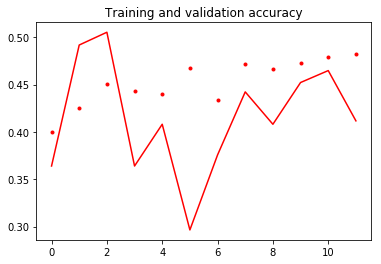

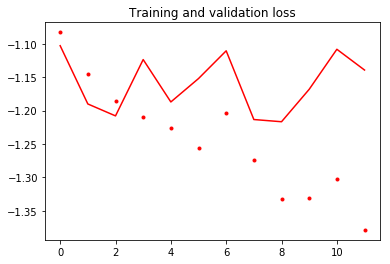

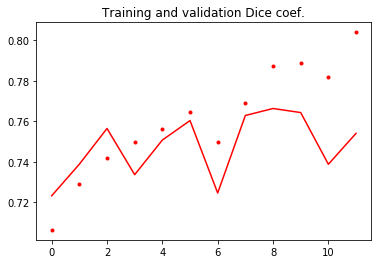

In [29]:
plot_training(history_1)

In [30]:
# EXTRA EPOCHS
history_1_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=8,
                              callbacks=callbacks,
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/8


132/739 [====>.........................] - ETA: 30:34 - loss: -1.3861 - acc: 0.5000 - dice_coeff: 0.80 - ETA: 19:33 - loss: -1.3853 - acc: 0.7500 - dice_coeff: 0.80 - ETA: 15:44 - loss: -1.2927 - acc: 0.6667 - dice_coeff: 0.76 - ETA: 13:46 - loss: -1.2892 - acc: 0.6250 - dice_coeff: 0.77 - ETA: 12:36 - loss: -1.3609 - acc: 0.6667 - dice_coeff: 0.79 - ETA: 11:50 - loss: -1.3148 - acc: 0.6667 - dice_coeff: 0.78 - ETA: 11:19 - loss: -1.3696 - acc: 0.6190 - dice_coeff: 0.79 - ETA: 10:53 - loss: -1.3717 - acc: 0.5833 - dice_coeff: 0.79 - ETA: 10:32 - loss: -1.4083 - acc: 0.5741 - dice_coeff: 0.80 - ETA: 10:17 - loss: -1.4019 - acc: 0.5500 - dice_coeff: 0.80 - ETA: 10:04 - loss: -1.3853 - acc: 0.5606 - dice_coeff: 0.80 - ETA: 9:52 - loss: -1.3942 - acc: 0.5556 - dice_coeff: 0.8052 - ETA: 9:43 - loss: -1.4063 - acc: 0.5385 - dice_coeff: 0.808 - ETA: 9:36 - loss: -1.4046 - acc: 0.5476 - dice_coeff: 0.808 - ETA: 9:29 - loss: -1.4126 - acc: 0.5667 - dice_coeff: 0.810 - ETA: 9:23 - loss: -1.3875 

264/739 [=========>....................] - ETA: 6:52 - loss: -1.3974 - acc: 0.4887 - dice_coeff: 0.810 - ETA: 6:51 - loss: -1.3965 - acc: 0.4876 - dice_coeff: 0.810 - ETA: 6:50 - loss: -1.3961 - acc: 0.4889 - dice_coeff: 0.810 - ETA: 6:50 - loss: -1.3976 - acc: 0.4865 - dice_coeff: 0.810 - ETA: 6:49 - loss: -1.3967 - acc: 0.4854 - dice_coeff: 0.810 - ETA: 6:48 - loss: -1.3961 - acc: 0.4855 - dice_coeff: 0.810 - ETA: 6:48 - loss: -1.3946 - acc: 0.4856 - dice_coeff: 0.810 - ETA: 6:47 - loss: -1.3946 - acc: 0.4845 - dice_coeff: 0.809 - ETA: 6:46 - loss: -1.3928 - acc: 0.4846 - dice_coeff: 0.809 - ETA: 6:45 - loss: -1.3931 - acc: 0.4812 - dice_coeff: 0.809 - ETA: 6:45 - loss: -1.3928 - acc: 0.4802 - dice_coeff: 0.809 - ETA: 6:44 - loss: -1.3934 - acc: 0.4815 - dice_coeff: 0.809 - ETA: 6:43 - loss: -1.3923 - acc: 0.4805 - dice_coeff: 0.809 - ETA: 6:42 - loss: -1.3928 - acc: 0.4829 - dice_coeff: 0.809 - ETA: 6:42 - loss: -1.3952 - acc: 0.4841 - dice_coeff: 0.809 - ETA: 6:41 - loss: -1.3935 -

396/739 [===============>..............] - ETA: 5:19 - loss: -1.3870 - acc: 0.4912 - dice_coeff: 0.806 - ETA: 5:19 - loss: -1.3863 - acc: 0.4906 - dice_coeff: 0.806 - ETA: 5:18 - loss: -1.3871 - acc: 0.4913 - dice_coeff: 0.806 - ETA: 5:17 - loss: -1.3854 - acc: 0.4907 - dice_coeff: 0.806 - ETA: 5:17 - loss: -1.3861 - acc: 0.4901 - dice_coeff: 0.806 - ETA: 5:16 - loss: -1.3874 - acc: 0.4907 - dice_coeff: 0.806 - ETA: 5:15 - loss: -1.3879 - acc: 0.4914 - dice_coeff: 0.807 - ETA: 5:15 - loss: -1.3873 - acc: 0.4908 - dice_coeff: 0.807 - ETA: 5:14 - loss: -1.3865 - acc: 0.4908 - dice_coeff: 0.806 - ETA: 5:13 - loss: -1.3871 - acc: 0.4903 - dice_coeff: 0.807 - ETA: 5:12 - loss: -1.3869 - acc: 0.4903 - dice_coeff: 0.807 - ETA: 5:12 - loss: -1.3861 - acc: 0.4903 - dice_coeff: 0.806 - ETA: 5:11 - loss: -1.3868 - acc: 0.4904 - dice_coeff: 0.807 - ETA: 5:10 - loss: -1.3878 - acc: 0.4910 - dice_coeff: 0.807 - ETA: 5:10 - loss: -1.3877 - acc: 0.4904 - dice_coeff: 0.807 - ETA: 5:09 - loss: -1.3879 -

528/739 [====================>.........] - ETA: 3:50 - loss: -1.3943 - acc: 0.4916 - dice_coeff: 0.810 - ETA: 3:49 - loss: -1.3936 - acc: 0.4920 - dice_coeff: 0.810 - ETA: 3:48 - loss: -1.3944 - acc: 0.4921 - dice_coeff: 0.810 - ETA: 3:48 - loss: -1.3948 - acc: 0.4925 - dice_coeff: 0.810 - ETA: 3:47 - loss: -1.3949 - acc: 0.4925 - dice_coeff: 0.810 - ETA: 3:46 - loss: -1.3947 - acc: 0.4913 - dice_coeff: 0.810 - ETA: 3:45 - loss: -1.3949 - acc: 0.4909 - dice_coeff: 0.810 - ETA: 3:45 - loss: -1.3956 - acc: 0.4905 - dice_coeff: 0.810 - ETA: 3:44 - loss: -1.3940 - acc: 0.4897 - dice_coeff: 0.810 - ETA: 3:43 - loss: -1.3932 - acc: 0.4897 - dice_coeff: 0.810 - ETA: 3:43 - loss: -1.3940 - acc: 0.4902 - dice_coeff: 0.810 - ETA: 3:42 - loss: -1.3943 - acc: 0.4902 - dice_coeff: 0.810 - ETA: 3:41 - loss: -1.3947 - acc: 0.4902 - dice_coeff: 0.810 - ETA: 3:41 - loss: -1.3944 - acc: 0.4898 - dice_coeff: 0.810 - ETA: 3:40 - loss: -1.3945 - acc: 0.4899 - dice_coeff: 0.810 - ETA: 3:39 - loss: -1.3941 -

660/739 [=========================>....] - ETA: 2:21 - loss: -1.3903 - acc: 0.4839 - dice_coeff: 0.809 - ETA: 2:20 - loss: -1.3901 - acc: 0.4840 - dice_coeff: 0.809 - ETA: 2:19 - loss: -1.3909 - acc: 0.4837 - dice_coeff: 0.809 - ETA: 2:19 - loss: -1.3902 - acc: 0.4840 - dice_coeff: 0.809 - ETA: 2:18 - loss: -1.3902 - acc: 0.4837 - dice_coeff: 0.809 - ETA: 2:17 - loss: -1.3901 - acc: 0.4841 - dice_coeff: 0.809 - ETA: 2:16 - loss: -1.3903 - acc: 0.4838 - dice_coeff: 0.809 - ETA: 2:16 - loss: -1.3901 - acc: 0.4835 - dice_coeff: 0.809 - ETA: 2:15 - loss: -1.3895 - acc: 0.4839 - dice_coeff: 0.809 - ETA: 2:14 - loss: -1.3895 - acc: 0.4842 - dice_coeff: 0.809 - ETA: 2:14 - loss: -1.3891 - acc: 0.4845 - dice_coeff: 0.809 - ETA: 2:13 - loss: -1.3888 - acc: 0.4849 - dice_coeff: 0.809 - ETA: 2:12 - loss: -1.3891 - acc: 0.4849 - dice_coeff: 0.809 - ETA: 2:12 - loss: -1.3886 - acc: 0.4846 - dice_coeff: 0.809 - ETA: 2:11 - loss: -1.3886 - acc: 0.4847 - dice_coeff: 0.809 - ETA: 2:10 - loss: -1.3887 -

739/739 [==============================] - ETA: 52s - loss: -1.3878 - acc: 0.4914 - dice_coeff: 0.80 - ETA: 51s - loss: -1.3871 - acc: 0.4907 - dice_coeff: 0.80 - ETA: 50s - loss: -1.3871 - acc: 0.4907 - dice_coeff: 0.80 - ETA: 50s - loss: -1.3876 - acc: 0.4907 - dice_coeff: 0.80 - ETA: 49s - loss: -1.3874 - acc: 0.4910 - dice_coeff: 0.80 - ETA: 48s - loss: -1.3876 - acc: 0.4912 - dice_coeff: 0.80 - ETA: 48s - loss: -1.3871 - acc: 0.4913 - dice_coeff: 0.80 - ETA: 47s - loss: -1.3867 - acc: 0.4913 - dice_coeff: 0.80 - ETA: 46s - loss: -1.3871 - acc: 0.4918 - dice_coeff: 0.80 - ETA: 46s - loss: -1.3872 - acc: 0.4920 - dice_coeff: 0.80 - ETA: 45s - loss: -1.3870 - acc: 0.4923 - dice_coeff: 0.80 - ETA: 44s - loss: -1.3871 - acc: 0.4926 - dice_coeff: 0.80 - ETA: 44s - loss: -1.3873 - acc: 0.4928 - dice_coeff: 0.80 - ETA: 43s - loss: -1.3875 - acc: 0.4928 - dice_coeff: 0.80 - ETA: 42s - loss: -1.3875 - acc: 0.4928 - dice_coeff: 0.80 - ETA: 42s - loss: -1.3866 - acc: 0.4929 - dice_coeff: 0.80

132/739 [====>.........................] - ETA: 9:19 - loss: -1.5633 - acc: 0.8333 - dice_coeff: 0.853 - ETA: 8:53 - loss: -1.4440 - acc: 0.6667 - dice_coeff: 0.832 - ETA: 8:38 - loss: -1.4279 - acc: 0.5556 - dice_coeff: 0.827 - ETA: 8:30 - loss: -1.3766 - acc: 0.5417 - dice_coeff: 0.815 - ETA: 8:25 - loss: -1.3219 - acc: 0.5333 - dice_coeff: 0.801 - ETA: 8:24 - loss: -1.3518 - acc: 0.5000 - dice_coeff: 0.807 - ETA: 8:21 - loss: -1.3977 - acc: 0.5238 - dice_coeff: 0.817 - ETA: 8:18 - loss: -1.4231 - acc: 0.5208 - dice_coeff: 0.826 - ETA: 8:17 - loss: -1.4162 - acc: 0.5000 - dice_coeff: 0.822 - ETA: 8:14 - loss: -1.4193 - acc: 0.4833 - dice_coeff: 0.823 - ETA: 8:12 - loss: -1.4277 - acc: 0.4394 - dice_coeff: 0.825 - ETA: 8:12 - loss: -1.4352 - acc: 0.4306 - dice_coeff: 0.827 - ETA: 8:10 - loss: -1.4412 - acc: 0.4359 - dice_coeff: 0.829 - ETA: 8:09 - loss: -1.4344 - acc: 0.4405 - dice_coeff: 0.827 - ETA: 8:08 - loss: -1.4456 - acc: 0.4667 - dice_coeff: 0.829 - ETA: 8:07 - loss: -1.4581 -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.4299 - acc: 0.5125 - dice_coeff: 0.821 - ETA: 6:44 - loss: -1.4321 - acc: 0.5124 - dice_coeff: 0.822 - ETA: 6:43 - loss: -1.4321 - acc: 0.5148 - dice_coeff: 0.822 - ETA: 6:43 - loss: -1.4275 - acc: 0.5147 - dice_coeff: 0.821 - ETA: 6:42 - loss: -1.4273 - acc: 0.5146 - dice_coeff: 0.821 - ETA: 6:41 - loss: -1.4283 - acc: 0.5157 - dice_coeff: 0.821 - ETA: 6:41 - loss: -1.4276 - acc: 0.5144 - dice_coeff: 0.821 - ETA: 6:40 - loss: -1.4279 - acc: 0.5143 - dice_coeff: 0.821 - ETA: 6:39 - loss: -1.4300 - acc: 0.5130 - dice_coeff: 0.822 - ETA: 6:39 - loss: -1.4314 - acc: 0.5153 - dice_coeff: 0.822 - ETA: 6:38 - loss: -1.4327 - acc: 0.5152 - dice_coeff: 0.822 - ETA: 6:37 - loss: -1.4351 - acc: 0.5162 - dice_coeff: 0.823 - ETA: 6:37 - loss: -1.4366 - acc: 0.5149 - dice_coeff: 0.823 - ETA: 6:36 - loss: -1.4364 - acc: 0.5160 - dice_coeff: 0.823 - ETA: 6:35 - loss: -1.4374 - acc: 0.5147 - dice_coeff: 0.824 - ETA: 6:35 - loss: -1.4398 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.4316 - acc: 0.5182 - dice_coeff: 0.822 - ETA: 5:16 - loss: -1.4321 - acc: 0.5188 - dice_coeff: 0.822 - ETA: 5:15 - loss: -1.4329 - acc: 0.5194 - dice_coeff: 0.823 - ETA: 5:14 - loss: -1.4331 - acc: 0.5199 - dice_coeff: 0.823 - ETA: 5:14 - loss: -1.4338 - acc: 0.5211 - dice_coeff: 0.823 - ETA: 5:13 - loss: -1.4341 - acc: 0.5210 - dice_coeff: 0.823 - ETA: 5:12 - loss: -1.4354 - acc: 0.5203 - dice_coeff: 0.823 - ETA: 5:12 - loss: -1.4346 - acc: 0.5196 - dice_coeff: 0.823 - ETA: 5:11 - loss: -1.4357 - acc: 0.5195 - dice_coeff: 0.823 - ETA: 5:10 - loss: -1.4363 - acc: 0.5195 - dice_coeff: 0.824 - ETA: 5:10 - loss: -1.4366 - acc: 0.5206 - dice_coeff: 0.824 - ETA: 5:09 - loss: -1.4351 - acc: 0.5205 - dice_coeff: 0.823 - ETA: 5:08 - loss: -1.4350 - acc: 0.5193 - dice_coeff: 0.823 - ETA: 5:08 - loss: -1.4359 - acc: 0.5192 - dice_coeff: 0.823 - ETA: 5:07 - loss: -1.4342 - acc: 0.5185 - dice_coeff: 0.823 - ETA: 5:06 - loss: -1.4334 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.4273 - acc: 0.5105 - dice_coeff: 0.821 - ETA: 3:47 - loss: -1.4274 - acc: 0.5109 - dice_coeff: 0.821 - ETA: 3:47 - loss: -1.4272 - acc: 0.5109 - dice_coeff: 0.821 - ETA: 3:46 - loss: -1.4279 - acc: 0.5113 - dice_coeff: 0.821 - ETA: 3:45 - loss: -1.4278 - acc: 0.5121 - dice_coeff: 0.821 - ETA: 3:45 - loss: -1.4286 - acc: 0.5112 - dice_coeff: 0.821 - ETA: 3:44 - loss: -1.4290 - acc: 0.5116 - dice_coeff: 0.822 - ETA: 3:43 - loss: -1.4297 - acc: 0.5116 - dice_coeff: 0.822 - ETA: 3:43 - loss: -1.4288 - acc: 0.5111 - dice_coeff: 0.822 - ETA: 3:42 - loss: -1.4292 - acc: 0.5103 - dice_coeff: 0.822 - ETA: 3:41 - loss: -1.4288 - acc: 0.5102 - dice_coeff: 0.822 - ETA: 3:41 - loss: -1.4271 - acc: 0.5098 - dice_coeff: 0.821 - ETA: 3:40 - loss: -1.4274 - acc: 0.5090 - dice_coeff: 0.821 - ETA: 3:39 - loss: -1.4271 - acc: 0.5085 - dice_coeff: 0.821 - ETA: 3:39 - loss: -1.4270 - acc: 0.5077 - dice_coeff: 0.821 - ETA: 3:38 - loss: -1.4268 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.4237 - acc: 0.4962 - dice_coeff: 0.820 - ETA: 2:19 - loss: -1.4236 - acc: 0.4962 - dice_coeff: 0.820 - ETA: 2:19 - loss: -1.4235 - acc: 0.4962 - dice_coeff: 0.820 - ETA: 2:18 - loss: -1.4240 - acc: 0.4962 - dice_coeff: 0.820 - ETA: 2:17 - loss: -1.4238 - acc: 0.4966 - dice_coeff: 0.820 - ETA: 2:17 - loss: -1.4242 - acc: 0.4963 - dice_coeff: 0.820 - ETA: 2:16 - loss: -1.4240 - acc: 0.4966 - dice_coeff: 0.820 - ETA: 2:15 - loss: -1.4241 - acc: 0.4963 - dice_coeff: 0.820 - ETA: 2:15 - loss: -1.4240 - acc: 0.4966 - dice_coeff: 0.820 - ETA: 2:14 - loss: -1.4244 - acc: 0.4963 - dice_coeff: 0.821 - ETA: 2:13 - loss: -1.4239 - acc: 0.4966 - dice_coeff: 0.820 - ETA: 2:13 - loss: -1.4236 - acc: 0.4963 - dice_coeff: 0.820 - ETA: 2:12 - loss: -1.4242 - acc: 0.4966 - dice_coeff: 0.820 - ETA: 2:11 - loss: -1.4241 - acc: 0.4972 - dice_coeff: 0.820 - ETA: 2:11 - loss: -1.4245 - acc: 0.4972 - dice_coeff: 0.821 - ETA: 2:10 - loss: -1.4239 -

739/739 [==============================] - ETA: 52s - loss: -1.4210 - acc: 0.4947 - dice_coeff: 0.82 - ETA: 51s - loss: -1.4211 - acc: 0.4947 - dice_coeff: 0.82 - ETA: 50s - loss: -1.4206 - acc: 0.4955 - dice_coeff: 0.82 - ETA: 50s - loss: -1.4208 - acc: 0.4960 - dice_coeff: 0.82 - ETA: 49s - loss: -1.4206 - acc: 0.4957 - dice_coeff: 0.82 - ETA: 48s - loss: -1.4205 - acc: 0.4955 - dice_coeff: 0.81 - ETA: 48s - loss: -1.4206 - acc: 0.4955 - dice_coeff: 0.81 - ETA: 47s - loss: -1.4206 - acc: 0.4958 - dice_coeff: 0.81 - ETA: 46s - loss: -1.4205 - acc: 0.4958 - dice_coeff: 0.81 - ETA: 46s - loss: -1.4207 - acc: 0.4955 - dice_coeff: 0.81 - ETA: 45s - loss: -1.4208 - acc: 0.4950 - dice_coeff: 0.82 - ETA: 44s - loss: -1.4209 - acc: 0.4953 - dice_coeff: 0.81 - ETA: 44s - loss: -1.4208 - acc: 0.4950 - dice_coeff: 0.81 - ETA: 43s - loss: -1.4210 - acc: 0.4948 - dice_coeff: 0.82 - ETA: 42s - loss: -1.4207 - acc: 0.4946 - dice_coeff: 0.82 - ETA: 42s - loss: -1.4204 - acc: 0.4948 - dice_coeff: 0.81

132/739 [====>.........................] - ETA: 8:43 - loss: -1.7176 - acc: 0.5000 - dice_coeff: 0.902 - ETA: 8:37 - loss: -1.6683 - acc: 0.4167 - dice_coeff: 0.893 - ETA: 8:36 - loss: -1.6870 - acc: 0.5000 - dice_coeff: 0.898 - ETA: 8:27 - loss: -1.4951 - acc: 0.4583 - dice_coeff: 0.846 - ETA: 8:24 - loss: -1.4848 - acc: 0.5667 - dice_coeff: 0.839 - ETA: 8:21 - loss: -1.5112 - acc: 0.5556 - dice_coeff: 0.847 - ETA: 8:18 - loss: -1.5219 - acc: 0.5476 - dice_coeff: 0.849 - ETA: 8:16 - loss: -1.5402 - acc: 0.5417 - dice_coeff: 0.854 - ETA: 8:15 - loss: -1.4985 - acc: 0.5370 - dice_coeff: 0.843 - ETA: 8:13 - loss: -1.5129 - acc: 0.5167 - dice_coeff: 0.847 - ETA: 8:12 - loss: -1.5156 - acc: 0.5000 - dice_coeff: 0.847 - ETA: 8:09 - loss: -1.5339 - acc: 0.5000 - dice_coeff: 0.852 - ETA: 8:08 - loss: -1.5467 - acc: 0.5128 - dice_coeff: 0.855 - ETA: 8:08 - loss: -1.5290 - acc: 0.4881 - dice_coeff: 0.850 - ETA: 8:06 - loss: -1.5387 - acc: 0.5000 - dice_coeff: 0.852 - ETA: 8:05 - loss: -1.5244 -

264/739 [=========>....................] - ETA: 6:44 - loss: -1.4763 - acc: 0.4912 - dice_coeff: 0.837 - ETA: 6:44 - loss: -1.4766 - acc: 0.4900 - dice_coeff: 0.837 - ETA: 6:43 - loss: -1.4754 - acc: 0.4889 - dice_coeff: 0.837 - ETA: 6:42 - loss: -1.4750 - acc: 0.4890 - dice_coeff: 0.837 - ETA: 6:42 - loss: -1.4764 - acc: 0.4891 - dice_coeff: 0.837 - ETA: 6:41 - loss: -1.4752 - acc: 0.4867 - dice_coeff: 0.837 - ETA: 6:40 - loss: -1.4761 - acc: 0.4868 - dice_coeff: 0.837 - ETA: 6:40 - loss: -1.4745 - acc: 0.4833 - dice_coeff: 0.836 - ETA: 6:39 - loss: -1.4728 - acc: 0.4823 - dice_coeff: 0.836 - ETA: 6:38 - loss: -1.4738 - acc: 0.4836 - dice_coeff: 0.836 - ETA: 6:38 - loss: -1.4746 - acc: 0.4837 - dice_coeff: 0.837 - ETA: 6:37 - loss: -1.4748 - acc: 0.4850 - dice_coeff: 0.837 - ETA: 6:36 - loss: -1.4725 - acc: 0.4862 - dice_coeff: 0.836 - ETA: 6:36 - loss: -1.4727 - acc: 0.4829 - dice_coeff: 0.836 - ETA: 6:35 - loss: -1.4745 - acc: 0.4830 - dice_coeff: 0.836 - ETA: 6:34 - loss: -1.4760 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.4630 - acc: 0.4830 - dice_coeff: 0.833 - ETA: 5:15 - loss: -1.4624 - acc: 0.4825 - dice_coeff: 0.833 - ETA: 5:15 - loss: -1.4624 - acc: 0.4831 - dice_coeff: 0.832 - ETA: 5:14 - loss: -1.4625 - acc: 0.4826 - dice_coeff: 0.832 - ETA: 5:13 - loss: -1.4625 - acc: 0.4820 - dice_coeff: 0.832 - ETA: 5:13 - loss: -1.4612 - acc: 0.4815 - dice_coeff: 0.832 - ETA: 5:12 - loss: -1.4608 - acc: 0.4809 - dice_coeff: 0.832 - ETA: 5:11 - loss: -1.4619 - acc: 0.4804 - dice_coeff: 0.832 - ETA: 5:11 - loss: -1.4626 - acc: 0.4805 - dice_coeff: 0.833 - ETA: 5:10 - loss: -1.4621 - acc: 0.4811 - dice_coeff: 0.833 - ETA: 5:09 - loss: -1.4616 - acc: 0.4818 - dice_coeff: 0.832 - ETA: 5:09 - loss: -1.4615 - acc: 0.4807 - dice_coeff: 0.832 - ETA: 5:08 - loss: -1.4618 - acc: 0.4801 - dice_coeff: 0.832 - ETA: 5:07 - loss: -1.4621 - acc: 0.4814 - dice_coeff: 0.833 - ETA: 5:07 - loss: -1.4633 - acc: 0.4809 - dice_coeff: 0.833 - ETA: 5:06 - loss: -1.4637 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.4531 - acc: 0.4874 - dice_coeff: 0.830 - ETA: 3:47 - loss: -1.4535 - acc: 0.4866 - dice_coeff: 0.831 - ETA: 3:47 - loss: -1.4527 - acc: 0.4862 - dice_coeff: 0.830 - ETA: 3:46 - loss: -1.4520 - acc: 0.4863 - dice_coeff: 0.830 - ETA: 3:45 - loss: -1.4518 - acc: 0.4867 - dice_coeff: 0.830 - ETA: 3:45 - loss: -1.4523 - acc: 0.4867 - dice_coeff: 0.830 - ETA: 3:44 - loss: -1.4518 - acc: 0.4876 - dice_coeff: 0.830 - ETA: 3:43 - loss: -1.4523 - acc: 0.4880 - dice_coeff: 0.830 - ETA: 3:43 - loss: -1.4518 - acc: 0.4872 - dice_coeff: 0.830 - ETA: 3:42 - loss: -1.4519 - acc: 0.4869 - dice_coeff: 0.830 - ETA: 3:41 - loss: -1.4523 - acc: 0.4869 - dice_coeff: 0.830 - ETA: 3:41 - loss: -1.4519 - acc: 0.4869 - dice_coeff: 0.830 - ETA: 3:40 - loss: -1.4517 - acc: 0.4874 - dice_coeff: 0.830 - ETA: 3:39 - loss: -1.4519 - acc: 0.4886 - dice_coeff: 0.830 - ETA: 3:39 - loss: -1.4521 - acc: 0.4899 - dice_coeff: 0.830 - ETA: 3:38 - loss: -1.4526 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.4576 - acc: 0.4915 - dice_coeff: 0.832 - ETA: 2:19 - loss: -1.4578 - acc: 0.4921 - dice_coeff: 0.832 - ETA: 2:18 - loss: -1.4578 - acc: 0.4922 - dice_coeff: 0.832 - ETA: 2:18 - loss: -1.4578 - acc: 0.4928 - dice_coeff: 0.832 - ETA: 2:17 - loss: -1.4577 - acc: 0.4931 - dice_coeff: 0.832 - ETA: 2:16 - loss: -1.4577 - acc: 0.4925 - dice_coeff: 0.832 - ETA: 2:16 - loss: -1.4579 - acc: 0.4931 - dice_coeff: 0.832 - ETA: 2:15 - loss: -1.4583 - acc: 0.4938 - dice_coeff: 0.832 - ETA: 2:14 - loss: -1.4587 - acc: 0.4944 - dice_coeff: 0.832 - ETA: 2:14 - loss: -1.4589 - acc: 0.4944 - dice_coeff: 0.832 - ETA: 2:13 - loss: -1.4590 - acc: 0.4941 - dice_coeff: 0.833 - ETA: 2:12 - loss: -1.4591 - acc: 0.4938 - dice_coeff: 0.833 - ETA: 2:12 - loss: -1.4591 - acc: 0.4938 - dice_coeff: 0.833 - ETA: 2:11 - loss: -1.4590 - acc: 0.4935 - dice_coeff: 0.833 - ETA: 2:10 - loss: -1.4588 - acc: 0.4932 - dice_coeff: 0.833 - ETA: 2:10 - loss: -1.4584 -

739/739 [==============================] - ETA: 52s - loss: -1.4584 - acc: 0.4977 - dice_coeff: 0.83 - ETA: 51s - loss: -1.4587 - acc: 0.4982 - dice_coeff: 0.83 - ETA: 50s - loss: -1.4584 - acc: 0.4982 - dice_coeff: 0.83 - ETA: 50s - loss: -1.4583 - acc: 0.4982 - dice_coeff: 0.83 - ETA: 49s - loss: -1.4584 - acc: 0.4985 - dice_coeff: 0.83 - ETA: 48s - loss: -1.4588 - acc: 0.4985 - dice_coeff: 0.83 - ETA: 48s - loss: -1.4587 - acc: 0.4983 - dice_coeff: 0.83 - ETA: 47s - loss: -1.4582 - acc: 0.4980 - dice_coeff: 0.83 - ETA: 46s - loss: -1.4583 - acc: 0.4980 - dice_coeff: 0.83 - ETA: 46s - loss: -1.4583 - acc: 0.4983 - dice_coeff: 0.83 - ETA: 45s - loss: -1.4580 - acc: 0.4983 - dice_coeff: 0.83 - ETA: 44s - loss: -1.4579 - acc: 0.4983 - dice_coeff: 0.83 - ETA: 44s - loss: -1.4580 - acc: 0.4980 - dice_coeff: 0.83 - ETA: 43s - loss: -1.4580 - acc: 0.4980 - dice_coeff: 0.83 - ETA: 42s - loss: -1.4582 - acc: 0.4983 - dice_coeff: 0.83 - ETA: 42s - loss: -1.4583 - acc: 0.4983 - dice_coeff: 0.83

132/739 [====>.........................] - ETA: 8:33 - loss: -1.4224 - acc: 0.0000e+00 - dice_coeff: 0.824 - ETA: 8:33 - loss: -1.5509 - acc: 0.0833 - dice_coeff: 0.8553    - ETA: 8:30 - loss: -1.5073 - acc: 0.2222 - dice_coeff: 0.849 - ETA: 8:24 - loss: -1.5329 - acc: 0.2917 - dice_coeff: 0.858 - ETA: 8:19 - loss: -1.5256 - acc: 0.3333 - dice_coeff: 0.858 - ETA: 8:18 - loss: -1.4831 - acc: 0.3056 - dice_coeff: 0.846 - ETA: 8:14 - loss: -1.5003 - acc: 0.3095 - dice_coeff: 0.851 - ETA: 8:14 - loss: -1.5191 - acc: 0.3542 - dice_coeff: 0.855 - ETA: 8:13 - loss: -1.5103 - acc: 0.4259 - dice_coeff: 0.850 - ETA: 8:12 - loss: -1.5151 - acc: 0.4333 - dice_coeff: 0.851 - ETA: 8:09 - loss: -1.5230 - acc: 0.4848 - dice_coeff: 0.851 - ETA: 8:08 - loss: -1.5494 - acc: 0.5139 - dice_coeff: 0.858 - ETA: 8:08 - loss: -1.5395 - acc: 0.5000 - dice_coeff: 0.856 - ETA: 8:08 - loss: -1.5441 - acc: 0.5000 - dice_coeff: 0.858 - ETA: 8:06 - loss: -1.5506 - acc: 0.5111 - dice_coeff: 0.859 - ETA: 8:06 - loss: -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.5111 - acc: 0.5063 - dice_coeff: 0.847 - ETA: 6:44 - loss: -1.5139 - acc: 0.5062 - dice_coeff: 0.848 - ETA: 6:44 - loss: -1.5091 - acc: 0.5074 - dice_coeff: 0.847 - ETA: 6:43 - loss: -1.5111 - acc: 0.5086 - dice_coeff: 0.847 - ETA: 6:42 - loss: -1.5103 - acc: 0.5085 - dice_coeff: 0.847 - ETA: 6:42 - loss: -1.5115 - acc: 0.5097 - dice_coeff: 0.847 - ETA: 6:41 - loss: -1.5113 - acc: 0.5108 - dice_coeff: 0.847 - ETA: 6:40 - loss: -1.5128 - acc: 0.5095 - dice_coeff: 0.848 - ETA: 6:40 - loss: -1.5131 - acc: 0.5083 - dice_coeff: 0.848 - ETA: 6:39 - loss: -1.5118 - acc: 0.5082 - dice_coeff: 0.848 - ETA: 6:39 - loss: -1.5121 - acc: 0.5082 - dice_coeff: 0.848 - ETA: 6:38 - loss: -1.5132 - acc: 0.5081 - dice_coeff: 0.848 - ETA: 6:37 - loss: -1.5128 - acc: 0.5103 - dice_coeff: 0.848 - ETA: 6:36 - loss: -1.5115 - acc: 0.5126 - dice_coeff: 0.847 - ETA: 6:36 - loss: -1.5113 - acc: 0.5113 - dice_coeff: 0.847 - ETA: 6:35 - loss: -1.5120 -

396/739 [===============>..............] - ETA: 5:17 - loss: -1.5083 - acc: 0.5031 - dice_coeff: 0.847 - ETA: 5:16 - loss: -1.5093 - acc: 0.5025 - dice_coeff: 0.847 - ETA: 5:15 - loss: -1.5102 - acc: 0.5031 - dice_coeff: 0.847 - ETA: 5:15 - loss: -1.5098 - acc: 0.5012 - dice_coeff: 0.847 - ETA: 5:14 - loss: -1.5106 - acc: 0.5006 - dice_coeff: 0.847 - ETA: 5:13 - loss: -1.5107 - acc: 0.5006 - dice_coeff: 0.847 - ETA: 5:12 - loss: -1.5109 - acc: 0.5006 - dice_coeff: 0.847 - ETA: 5:12 - loss: -1.5111 - acc: 0.5000 - dice_coeff: 0.847 - ETA: 5:11 - loss: -1.5097 - acc: 0.5000 - dice_coeff: 0.847 - ETA: 5:10 - loss: -1.5100 - acc: 0.5000 - dice_coeff: 0.847 - ETA: 5:10 - loss: -1.5095 - acc: 0.5000 - dice_coeff: 0.847 - ETA: 5:09 - loss: -1.5096 - acc: 0.5006 - dice_coeff: 0.847 - ETA: 5:08 - loss: -1.5103 - acc: 0.5006 - dice_coeff: 0.847 - ETA: 5:08 - loss: -1.5108 - acc: 0.5000 - dice_coeff: 0.847 - ETA: 5:07 - loss: -1.5113 - acc: 0.4994 - dice_coeff: 0.847 - ETA: 5:06 - loss: -1.5107 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.5079 - acc: 0.5088 - dice_coeff: 0.846 - ETA: 3:47 - loss: -1.5073 - acc: 0.5088 - dice_coeff: 0.846 - ETA: 3:47 - loss: -1.5075 - acc: 0.5088 - dice_coeff: 0.846 - ETA: 3:46 - loss: -1.5074 - acc: 0.5092 - dice_coeff: 0.846 - ETA: 3:45 - loss: -1.5071 - acc: 0.5091 - dice_coeff: 0.846 - ETA: 3:45 - loss: -1.5076 - acc: 0.5100 - dice_coeff: 0.846 - ETA: 3:44 - loss: -1.5079 - acc: 0.5108 - dice_coeff: 0.846 - ETA: 3:43 - loss: -1.5077 - acc: 0.5107 - dice_coeff: 0.846 - ETA: 3:43 - loss: -1.5079 - acc: 0.5111 - dice_coeff: 0.846 - ETA: 3:42 - loss: -1.5062 - acc: 0.5111 - dice_coeff: 0.846 - ETA: 3:41 - loss: -1.5064 - acc: 0.5106 - dice_coeff: 0.846 - ETA: 3:41 - loss: -1.5058 - acc: 0.5102 - dice_coeff: 0.846 - ETA: 3:40 - loss: -1.5066 - acc: 0.5102 - dice_coeff: 0.846 - ETA: 3:39 - loss: -1.5067 - acc: 0.5106 - dice_coeff: 0.846 - ETA: 3:39 - loss: -1.5064 - acc: 0.5097 - dice_coeff: 0.846 - ETA: 3:38 - loss: -1.5065 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.4994 - acc: 0.5107 - dice_coeff: 0.844 - ETA: 2:19 - loss: -1.4996 - acc: 0.5113 - dice_coeff: 0.845 - ETA: 2:18 - loss: -1.4998 - acc: 0.5113 - dice_coeff: 0.845 - ETA: 2:18 - loss: -1.4994 - acc: 0.5110 - dice_coeff: 0.844 - ETA: 2:17 - loss: -1.4994 - acc: 0.5109 - dice_coeff: 0.844 - ETA: 2:16 - loss: -1.4992 - acc: 0.5112 - dice_coeff: 0.844 - ETA: 2:16 - loss: -1.4989 - acc: 0.5112 - dice_coeff: 0.844 - ETA: 2:15 - loss: -1.4993 - acc: 0.5115 - dice_coeff: 0.844 - ETA: 2:14 - loss: -1.4996 - acc: 0.5112 - dice_coeff: 0.844 - ETA: 2:14 - loss: -1.4993 - acc: 0.5112 - dice_coeff: 0.844 - ETA: 2:13 - loss: -1.4993 - acc: 0.5114 - dice_coeff: 0.844 - ETA: 2:12 - loss: -1.4986 - acc: 0.5114 - dice_coeff: 0.844 - ETA: 2:12 - loss: -1.4976 - acc: 0.5114 - dice_coeff: 0.844 - ETA: 2:11 - loss: -1.4978 - acc: 0.5117 - dice_coeff: 0.844 - ETA: 2:10 - loss: -1.4976 - acc: 0.5114 - dice_coeff: 0.844 - ETA: 2:10 - loss: -1.4975 -

739/739 [==============================] - ETA: 52s - loss: -1.4982 - acc: 0.5106 - dice_coeff: 0.84 - ETA: 51s - loss: -1.4979 - acc: 0.5106 - dice_coeff: 0.84 - ETA: 50s - loss: -1.4975 - acc: 0.5101 - dice_coeff: 0.84 - ETA: 50s - loss: -1.4975 - acc: 0.5095 - dice_coeff: 0.84 - ETA: 49s - loss: -1.4975 - acc: 0.5095 - dice_coeff: 0.84 - ETA: 48s - loss: -1.4980 - acc: 0.5103 - dice_coeff: 0.84 - ETA: 48s - loss: -1.4975 - acc: 0.5102 - dice_coeff: 0.84 - ETA: 47s - loss: -1.4978 - acc: 0.5105 - dice_coeff: 0.84 - ETA: 46s - loss: -1.4982 - acc: 0.5107 - dice_coeff: 0.84 - ETA: 46s - loss: -1.4983 - acc: 0.5102 - dice_coeff: 0.84 - ETA: 45s - loss: -1.4986 - acc: 0.5099 - dice_coeff: 0.84 - ETA: 44s - loss: -1.4990 - acc: 0.5099 - dice_coeff: 0.84 - ETA: 44s - loss: -1.4991 - acc: 0.5097 - dice_coeff: 0.84 - ETA: 43s - loss: -1.4993 - acc: 0.5104 - dice_coeff: 0.84 - ETA: 42s - loss: -1.4992 - acc: 0.5101 - dice_coeff: 0.84 - ETA: 42s - loss: -1.4990 - acc: 0.5101 - dice_coeff: 0.84

132/739 [====>.........................] - ETA: 8:39 - loss: -1.3893 - acc: 0.1667 - dice_coeff: 0.821 - ETA: 8:43 - loss: -1.3519 - acc: 0.3333 - dice_coeff: 0.798 - ETA: 8:38 - loss: -1.4784 - acc: 0.3333 - dice_coeff: 0.835 - ETA: 8:29 - loss: -1.5192 - acc: 0.3750 - dice_coeff: 0.844 - ETA: 8:25 - loss: -1.5568 - acc: 0.3333 - dice_coeff: 0.855 - ETA: 8:21 - loss: -1.5498 - acc: 0.3333 - dice_coeff: 0.853 - ETA: 8:17 - loss: -1.5508 - acc: 0.3571 - dice_coeff: 0.853 - ETA: 8:15 - loss: -1.5567 - acc: 0.3958 - dice_coeff: 0.855 - ETA: 8:14 - loss: -1.5485 - acc: 0.3889 - dice_coeff: 0.854 - ETA: 8:12 - loss: -1.5651 - acc: 0.3667 - dice_coeff: 0.859 - ETA: 8:10 - loss: -1.5665 - acc: 0.3788 - dice_coeff: 0.858 - ETA: 8:09 - loss: -1.5711 - acc: 0.3889 - dice_coeff: 0.860 - ETA: 8:08 - loss: -1.5648 - acc: 0.4103 - dice_coeff: 0.859 - ETA: 8:07 - loss: -1.5637 - acc: 0.4405 - dice_coeff: 0.858 - ETA: 8:06 - loss: -1.5671 - acc: 0.4333 - dice_coeff: 0.859 - ETA: 8:04 - loss: -1.5729 -

264/739 [=========>....................] - ETA: 6:44 - loss: -1.5511 - acc: 0.4900 - dice_coeff: 0.855 - ETA: 6:43 - loss: -1.5497 - acc: 0.4876 - dice_coeff: 0.854 - ETA: 6:43 - loss: -1.5492 - acc: 0.4877 - dice_coeff: 0.854 - ETA: 6:42 - loss: -1.5474 - acc: 0.4865 - dice_coeff: 0.854 - ETA: 6:41 - loss: -1.5466 - acc: 0.4854 - dice_coeff: 0.854 - ETA: 6:41 - loss: -1.5465 - acc: 0.4855 - dice_coeff: 0.854 - ETA: 6:40 - loss: -1.5469 - acc: 0.4832 - dice_coeff: 0.854 - ETA: 6:39 - loss: -1.5476 - acc: 0.4833 - dice_coeff: 0.854 - ETA: 6:39 - loss: -1.5455 - acc: 0.4858 - dice_coeff: 0.853 - ETA: 6:38 - loss: -1.5426 - acc: 0.4859 - dice_coeff: 0.853 - ETA: 6:37 - loss: -1.5427 - acc: 0.4848 - dice_coeff: 0.853 - ETA: 6:37 - loss: -1.5448 - acc: 0.4861 - dice_coeff: 0.853 - ETA: 6:36 - loss: -1.5458 - acc: 0.4874 - dice_coeff: 0.853 - ETA: 6:35 - loss: -1.5472 - acc: 0.4852 - dice_coeff: 0.854 - ETA: 6:35 - loss: -1.5472 - acc: 0.4830 - dice_coeff: 0.854 - ETA: 6:34 - loss: -1.5466 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.5515 - acc: 0.4836 - dice_coeff: 0.856 - ETA: 5:15 - loss: -1.5515 - acc: 0.4831 - dice_coeff: 0.856 - ETA: 5:15 - loss: -1.5518 - acc: 0.4838 - dice_coeff: 0.856 - ETA: 5:14 - loss: -1.5512 - acc: 0.4845 - dice_coeff: 0.856 - ETA: 5:13 - loss: -1.5517 - acc: 0.4845 - dice_coeff: 0.856 - ETA: 5:13 - loss: -1.5509 - acc: 0.4858 - dice_coeff: 0.856 - ETA: 5:12 - loss: -1.5511 - acc: 0.4852 - dice_coeff: 0.856 - ETA: 5:11 - loss: -1.5525 - acc: 0.4865 - dice_coeff: 0.856 - ETA: 5:11 - loss: -1.5509 - acc: 0.4860 - dice_coeff: 0.856 - ETA: 5:10 - loss: -1.5503 - acc: 0.4860 - dice_coeff: 0.855 - ETA: 5:09 - loss: -1.5498 - acc: 0.4867 - dice_coeff: 0.855 - ETA: 5:09 - loss: -1.5493 - acc: 0.4873 - dice_coeff: 0.855 - ETA: 5:08 - loss: -1.5498 - acc: 0.4880 - dice_coeff: 0.855 - ETA: 5:07 - loss: -1.5489 - acc: 0.4880 - dice_coeff: 0.855 - ETA: 5:07 - loss: -1.5484 - acc: 0.4875 - dice_coeff: 0.855 - ETA: 5:06 - loss: -1.5488 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.5504 - acc: 0.4828 - dice_coeff: 0.855 - ETA: 3:47 - loss: -1.5507 - acc: 0.4828 - dice_coeff: 0.855 - ETA: 3:47 - loss: -1.5505 - acc: 0.4837 - dice_coeff: 0.855 - ETA: 3:46 - loss: -1.5502 - acc: 0.4838 - dice_coeff: 0.855 - ETA: 3:45 - loss: -1.5499 - acc: 0.4834 - dice_coeff: 0.855 - ETA: 3:45 - loss: -1.5496 - acc: 0.4830 - dice_coeff: 0.855 - ETA: 3:44 - loss: -1.5498 - acc: 0.4826 - dice_coeff: 0.855 - ETA: 3:43 - loss: -1.5493 - acc: 0.4827 - dice_coeff: 0.855 - ETA: 3:43 - loss: -1.5495 - acc: 0.4827 - dice_coeff: 0.855 - ETA: 3:42 - loss: -1.5499 - acc: 0.4832 - dice_coeff: 0.855 - ETA: 3:41 - loss: -1.5499 - acc: 0.4824 - dice_coeff: 0.855 - ETA: 3:41 - loss: -1.5499 - acc: 0.4820 - dice_coeff: 0.855 - ETA: 3:40 - loss: -1.5493 - acc: 0.4817 - dice_coeff: 0.855 - ETA: 3:39 - loss: -1.5495 - acc: 0.4821 - dice_coeff: 0.855 - ETA: 3:39 - loss: -1.5501 - acc: 0.4822 - dice_coeff: 0.855 - ETA: 3:38 - loss: -1.5497 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.5503 - acc: 0.4808 - dice_coeff: 0.855 - ETA: 2:19 - loss: -1.5504 - acc: 0.4811 - dice_coeff: 0.856 - ETA: 2:18 - loss: -1.5507 - acc: 0.4815 - dice_coeff: 0.856 - ETA: 2:18 - loss: -1.5503 - acc: 0.4815 - dice_coeff: 0.855 - ETA: 2:17 - loss: -1.5506 - acc: 0.4812 - dice_coeff: 0.856 - ETA: 2:16 - loss: -1.5502 - acc: 0.4819 - dice_coeff: 0.855 - ETA: 2:16 - loss: -1.5503 - acc: 0.4819 - dice_coeff: 0.855 - ETA: 2:15 - loss: -1.5499 - acc: 0.4820 - dice_coeff: 0.855 - ETA: 2:14 - loss: -1.5500 - acc: 0.4823 - dice_coeff: 0.855 - ETA: 2:14 - loss: -1.5505 - acc: 0.4823 - dice_coeff: 0.856 - ETA: 2:13 - loss: -1.5510 - acc: 0.4821 - dice_coeff: 0.856 - ETA: 2:12 - loss: -1.5513 - acc: 0.4824 - dice_coeff: 0.856 - ETA: 2:12 - loss: -1.5507 - acc: 0.4818 - dice_coeff: 0.856 - ETA: 2:11 - loss: -1.5511 - acc: 0.4819 - dice_coeff: 0.856 - ETA: 2:10 - loss: -1.5512 - acc: 0.4819 - dice_coeff: 0.856 - ETA: 2:10 - loss: -1.5514 -

739/739 [==============================] - ETA: 52s - loss: -1.5522 - acc: 0.4881 - dice_coeff: 0.85 - ETA: 51s - loss: -1.5525 - acc: 0.4879 - dice_coeff: 0.85 - ETA: 50s - loss: -1.5524 - acc: 0.4879 - dice_coeff: 0.85 - ETA: 50s - loss: -1.5526 - acc: 0.4880 - dice_coeff: 0.85 - ETA: 49s - loss: -1.5522 - acc: 0.4877 - dice_coeff: 0.85 - ETA: 48s - loss: -1.5519 - acc: 0.4877 - dice_coeff: 0.85 - ETA: 48s - loss: -1.5515 - acc: 0.4880 - dice_coeff: 0.85 - ETA: 47s - loss: -1.5516 - acc: 0.4885 - dice_coeff: 0.85 - ETA: 46s - loss: -1.5516 - acc: 0.4878 - dice_coeff: 0.85 - ETA: 46s - loss: -1.5519 - acc: 0.4876 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5520 - acc: 0.4876 - dice_coeff: 0.85 - ETA: 44s - loss: -1.5523 - acc: 0.4881 - dice_coeff: 0.85 - ETA: 44s - loss: -1.5519 - acc: 0.4886 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5520 - acc: 0.4886 - dice_coeff: 0.85 - ETA: 42s - loss: -1.5520 - acc: 0.4886 - dice_coeff: 0.85 - ETA: 42s - loss: -1.5519 - acc: 0.4884 - dice_coeff: 0.85

132/739 [====>.........................] - ETA: 8:47 - loss: -1.6127 - acc: 0.5000 - dice_coeff: 0.860 - ETA: 8:43 - loss: -1.5738 - acc: 0.4167 - dice_coeff: 0.861 - ETA: 8:40 - loss: -1.5959 - acc: 0.5000 - dice_coeff: 0.866 - ETA: 8:30 - loss: -1.6304 - acc: 0.5000 - dice_coeff: 0.880 - ETA: 8:27 - loss: -1.6707 - acc: 0.5000 - dice_coeff: 0.892 - ETA: 8:23 - loss: -1.6704 - acc: 0.5000 - dice_coeff: 0.889 - ETA: 8:22 - loss: -1.6366 - acc: 0.5238 - dice_coeff: 0.878 - ETA: 8:20 - loss: -1.6212 - acc: 0.4792 - dice_coeff: 0.874 - ETA: 8:17 - loss: -1.6196 - acc: 0.4630 - dice_coeff: 0.874 - ETA: 8:15 - loss: -1.6397 - acc: 0.4167 - dice_coeff: 0.881 - ETA: 8:14 - loss: -1.6341 - acc: 0.4242 - dice_coeff: 0.877 - ETA: 8:12 - loss: -1.6219 - acc: 0.4444 - dice_coeff: 0.874 - ETA: 8:11 - loss: -1.6029 - acc: 0.4487 - dice_coeff: 0.870 - ETA: 8:10 - loss: -1.5890 - acc: 0.4524 - dice_coeff: 0.867 - ETA: 8:10 - loss: -1.5564 - acc: 0.4333 - dice_coeff: 0.860 - ETA: 8:08 - loss: -1.5622 -

264/739 [=========>....................] - ETA: 6:44 - loss: -1.5818 - acc: 0.5100 - dice_coeff: 0.868 - ETA: 6:43 - loss: -1.5843 - acc: 0.5100 - dice_coeff: 0.869 - ETA: 6:43 - loss: -1.5824 - acc: 0.5123 - dice_coeff: 0.868 - ETA: 6:42 - loss: -1.5835 - acc: 0.5110 - dice_coeff: 0.869 - ETA: 6:41 - loss: -1.5816 - acc: 0.5109 - dice_coeff: 0.868 - ETA: 6:41 - loss: -1.5805 - acc: 0.5109 - dice_coeff: 0.868 - ETA: 6:40 - loss: -1.5818 - acc: 0.5120 - dice_coeff: 0.868 - ETA: 6:39 - loss: -1.5826 - acc: 0.5131 - dice_coeff: 0.868 - ETA: 6:39 - loss: -1.5849 - acc: 0.5142 - dice_coeff: 0.869 - ETA: 6:38 - loss: -1.5838 - acc: 0.5106 - dice_coeff: 0.869 - ETA: 6:37 - loss: -1.5826 - acc: 0.5117 - dice_coeff: 0.869 - ETA: 6:37 - loss: -1.5844 - acc: 0.5127 - dice_coeff: 0.869 - ETA: 6:36 - loss: -1.5853 - acc: 0.5126 - dice_coeff: 0.869 - ETA: 6:35 - loss: -1.5848 - acc: 0.5137 - dice_coeff: 0.869 - ETA: 6:35 - loss: -1.5868 - acc: 0.5147 - dice_coeff: 0.870 - ETA: 6:34 - loss: -1.5862 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.5692 - acc: 0.5101 - dice_coeff: 0.866 - ETA: 5:15 - loss: -1.5695 - acc: 0.5100 - dice_coeff: 0.866 - ETA: 5:14 - loss: -1.5701 - acc: 0.5112 - dice_coeff: 0.866 - ETA: 5:14 - loss: -1.5707 - acc: 0.5112 - dice_coeff: 0.866 - ETA: 5:13 - loss: -1.5713 - acc: 0.5105 - dice_coeff: 0.866 - ETA: 5:12 - loss: -1.5699 - acc: 0.5099 - dice_coeff: 0.866 - ETA: 5:12 - loss: -1.5701 - acc: 0.5105 - dice_coeff: 0.866 - ETA: 5:11 - loss: -1.5715 - acc: 0.5123 - dice_coeff: 0.866 - ETA: 5:10 - loss: -1.5721 - acc: 0.5116 - dice_coeff: 0.866 - ETA: 5:10 - loss: -1.5728 - acc: 0.5116 - dice_coeff: 0.867 - ETA: 5:09 - loss: -1.5734 - acc: 0.5127 - dice_coeff: 0.867 - ETA: 5:08 - loss: -1.5730 - acc: 0.5133 - dice_coeff: 0.867 - ETA: 5:08 - loss: -1.5734 - acc: 0.5138 - dice_coeff: 0.867 - ETA: 5:07 - loss: -1.5744 - acc: 0.5156 - dice_coeff: 0.867 - ETA: 5:06 - loss: -1.5740 - acc: 0.5161 - dice_coeff: 0.867 - ETA: 5:06 - loss: -1.5747 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.5682 - acc: 0.5256 - dice_coeff: 0.865 - ETA: 3:47 - loss: -1.5683 - acc: 0.5264 - dice_coeff: 0.865 - ETA: 3:46 - loss: -1.5684 - acc: 0.5263 - dice_coeff: 0.865 - ETA: 3:46 - loss: -1.5679 - acc: 0.5267 - dice_coeff: 0.865 - ETA: 3:45 - loss: -1.5676 - acc: 0.5270 - dice_coeff: 0.865 - ETA: 3:44 - loss: -1.5672 - acc: 0.5269 - dice_coeff: 0.865 - ETA: 3:44 - loss: -1.5671 - acc: 0.5269 - dice_coeff: 0.865 - ETA: 3:43 - loss: -1.5678 - acc: 0.5272 - dice_coeff: 0.865 - ETA: 3:42 - loss: -1.5678 - acc: 0.5280 - dice_coeff: 0.865 - ETA: 3:42 - loss: -1.5672 - acc: 0.5275 - dice_coeff: 0.865 - ETA: 3:41 - loss: -1.5669 - acc: 0.5274 - dice_coeff: 0.865 - ETA: 3:40 - loss: -1.5668 - acc: 0.5278 - dice_coeff: 0.865 - ETA: 3:40 - loss: -1.5670 - acc: 0.5281 - dice_coeff: 0.865 - ETA: 3:39 - loss: -1.5674 - acc: 0.5285 - dice_coeff: 0.865 - ETA: 3:38 - loss: -1.5669 - acc: 0.5284 - dice_coeff: 0.865 - ETA: 3:38 - loss: -1.5670 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.5578 - acc: 0.5255 - dice_coeff: 0.862 - ETA: 2:19 - loss: -1.5581 - acc: 0.5264 - dice_coeff: 0.863 - ETA: 2:18 - loss: -1.5585 - acc: 0.5270 - dice_coeff: 0.863 - ETA: 2:18 - loss: -1.5587 - acc: 0.5269 - dice_coeff: 0.863 - ETA: 2:17 - loss: -1.5587 - acc: 0.5269 - dice_coeff: 0.863 - ETA: 2:16 - loss: -1.5590 - acc: 0.5268 - dice_coeff: 0.863 - ETA: 2:16 - loss: -1.5587 - acc: 0.5271 - dice_coeff: 0.863 - ETA: 2:15 - loss: -1.5586 - acc: 0.5274 - dice_coeff: 0.863 - ETA: 2:14 - loss: -1.5587 - acc: 0.5273 - dice_coeff: 0.863 - ETA: 2:14 - loss: -1.5587 - acc: 0.5276 - dice_coeff: 0.863 - ETA: 2:13 - loss: -1.5590 - acc: 0.5281 - dice_coeff: 0.863 - ETA: 2:12 - loss: -1.5592 - acc: 0.5281 - dice_coeff: 0.863 - ETA: 2:12 - loss: -1.5593 - acc: 0.5283 - dice_coeff: 0.863 - ETA: 2:11 - loss: -1.5592 - acc: 0.5286 - dice_coeff: 0.863 - ETA: 2:10 - loss: -1.5588 - acc: 0.5279 - dice_coeff: 0.863 - ETA: 2:10 - loss: -1.5587 -

739/739 [==============================] - ETA: 52s - loss: -1.5484 - acc: 0.5204 - dice_coeff: 0.86 - ETA: 51s - loss: -1.5483 - acc: 0.5199 - dice_coeff: 0.86 - ETA: 50s - loss: -1.5484 - acc: 0.5204 - dice_coeff: 0.86 - ETA: 50s - loss: -1.5487 - acc: 0.5208 - dice_coeff: 0.86 - ETA: 49s - loss: -1.5486 - acc: 0.5201 - dice_coeff: 0.86 - ETA: 48s - loss: -1.5481 - acc: 0.5200 - dice_coeff: 0.86 - ETA: 48s - loss: -1.5479 - acc: 0.5197 - dice_coeff: 0.86 - ETA: 47s - loss: -1.5478 - acc: 0.5200 - dice_coeff: 0.86 - ETA: 46s - loss: -1.5475 - acc: 0.5202 - dice_coeff: 0.85 - ETA: 46s - loss: -1.5472 - acc: 0.5204 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5472 - acc: 0.5204 - dice_coeff: 0.85 - ETA: 44s - loss: -1.5474 - acc: 0.5208 - dice_coeff: 0.85 - ETA: 44s - loss: -1.5475 - acc: 0.5208 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5466 - acc: 0.5205 - dice_coeff: 0.85 - ETA: 42s - loss: -1.5463 - acc: 0.5207 - dice_coeff: 0.85 - ETA: 42s - loss: -1.5462 - acc: 0.5207 - dice_coeff: 0.85

132/739 [====>.........................] - ETA: 8:40 - loss: -1.7308 - acc: 0.6667 - dice_coeff: 0.898 - ETA: 8:37 - loss: -1.6333 - acc: 0.5833 - dice_coeff: 0.866 - ETA: 8:33 - loss: -1.6813 - acc: 0.6111 - dice_coeff: 0.883 - ETA: 8:23 - loss: -1.6738 - acc: 0.5417 - dice_coeff: 0.882 - ETA: 8:22 - loss: -1.6676 - acc: 0.5667 - dice_coeff: 0.884 - ETA: 8:19 - loss: -1.6627 - acc: 0.6111 - dice_coeff: 0.882 - ETA: 8:15 - loss: -1.6140 - acc: 0.5952 - dice_coeff: 0.870 - ETA: 8:15 - loss: -1.6026 - acc: 0.6250 - dice_coeff: 0.864 - ETA: 8:12 - loss: -1.6007 - acc: 0.5741 - dice_coeff: 0.868 - ETA: 8:11 - loss: -1.5968 - acc: 0.6167 - dice_coeff: 0.866 - ETA: 8:10 - loss: -1.5913 - acc: 0.6061 - dice_coeff: 0.863 - ETA: 8:09 - loss: -1.6113 - acc: 0.6111 - dice_coeff: 0.870 - ETA: 8:08 - loss: -1.6091 - acc: 0.6026 - dice_coeff: 0.871 - ETA: 8:08 - loss: -1.6044 - acc: 0.5952 - dice_coeff: 0.870 - ETA: 8:06 - loss: -1.6132 - acc: 0.5889 - dice_coeff: 0.873 - ETA: 8:06 - loss: -1.5870 -

264/739 [=========>....................] - ETA: 6:45 - loss: -1.5215 - acc: 0.5401 - dice_coeff: 0.853 - ETA: 6:44 - loss: -1.5236 - acc: 0.5423 - dice_coeff: 0.854 - ETA: 6:43 - loss: -1.5231 - acc: 0.5395 - dice_coeff: 0.854 - ETA: 6:43 - loss: -1.5247 - acc: 0.5392 - dice_coeff: 0.854 - ETA: 6:42 - loss: -1.5211 - acc: 0.5389 - dice_coeff: 0.853 - ETA: 6:41 - loss: -1.5221 - acc: 0.5374 - dice_coeff: 0.854 - ETA: 6:41 - loss: -1.5205 - acc: 0.5372 - dice_coeff: 0.853 - ETA: 6:40 - loss: -1.5223 - acc: 0.5393 - dice_coeff: 0.854 - ETA: 6:39 - loss: -1.5219 - acc: 0.5378 - dice_coeff: 0.854 - ETA: 6:39 - loss: -1.5229 - acc: 0.5387 - dice_coeff: 0.854 - ETA: 6:38 - loss: -1.5232 - acc: 0.5385 - dice_coeff: 0.854 - ETA: 6:37 - loss: -1.5230 - acc: 0.5359 - dice_coeff: 0.854 - ETA: 6:37 - loss: -1.5203 - acc: 0.5356 - dice_coeff: 0.854 - ETA: 6:36 - loss: -1.5194 - acc: 0.5354 - dice_coeff: 0.853 - ETA: 6:35 - loss: -1.5191 - acc: 0.5363 - dice_coeff: 0.853 - ETA: 6:35 - loss: -1.5205 -

396/739 [===============>..............] - ETA: 5:16 - loss: -1.5011 - acc: 0.5107 - dice_coeff: 0.848 - ETA: 5:16 - loss: -1.5009 - acc: 0.5100 - dice_coeff: 0.848 - ETA: 5:15 - loss: -1.5009 - acc: 0.5100 - dice_coeff: 0.848 - ETA: 5:14 - loss: -1.4986 - acc: 0.5100 - dice_coeff: 0.847 - ETA: 5:14 - loss: -1.4995 - acc: 0.5099 - dice_coeff: 0.847 - ETA: 5:13 - loss: -1.4995 - acc: 0.5105 - dice_coeff: 0.847 - ETA: 5:12 - loss: -1.5002 - acc: 0.5105 - dice_coeff: 0.848 - ETA: 5:11 - loss: -1.5001 - acc: 0.5110 - dice_coeff: 0.848 - ETA: 5:11 - loss: -1.4998 - acc: 0.5092 - dice_coeff: 0.848 - ETA: 5:10 - loss: -1.4995 - acc: 0.5097 - dice_coeff: 0.847 - ETA: 5:09 - loss: -1.4988 - acc: 0.5079 - dice_coeff: 0.847 - ETA: 5:09 - loss: -1.4972 - acc: 0.5072 - dice_coeff: 0.847 - ETA: 5:08 - loss: -1.4961 - acc: 0.5078 - dice_coeff: 0.846 - ETA: 5:07 - loss: -1.4966 - acc: 0.5084 - dice_coeff: 0.847 - ETA: 5:07 - loss: -1.4969 - acc: 0.5096 - dice_coeff: 0.847 - ETA: 5:06 - loss: -1.4966 -

528/739 [====================>.........] - ETA: 3:48 - loss: -1.4839 - acc: 0.5084 - dice_coeff: 0.843 - ETA: 3:47 - loss: -1.4846 - acc: 0.5088 - dice_coeff: 0.843 - ETA: 3:47 - loss: -1.4834 - acc: 0.5092 - dice_coeff: 0.842 - ETA: 3:46 - loss: -1.4828 - acc: 0.5092 - dice_coeff: 0.842 - ETA: 3:45 - loss: -1.4829 - acc: 0.5091 - dice_coeff: 0.842 - ETA: 3:45 - loss: -1.4833 - acc: 0.5083 - dice_coeff: 0.842 - ETA: 3:44 - loss: -1.4821 - acc: 0.5074 - dice_coeff: 0.842 - ETA: 3:43 - loss: -1.4822 - acc: 0.5078 - dice_coeff: 0.842 - ETA: 3:43 - loss: -1.4813 - acc: 0.5078 - dice_coeff: 0.842 - ETA: 3:42 - loss: -1.4809 - acc: 0.5078 - dice_coeff: 0.842 - ETA: 3:41 - loss: -1.4811 - acc: 0.5086 - dice_coeff: 0.842 - ETA: 3:41 - loss: -1.4811 - acc: 0.5086 - dice_coeff: 0.842 - ETA: 3:40 - loss: -1.4809 - acc: 0.5086 - dice_coeff: 0.842 - ETA: 3:39 - loss: -1.4810 - acc: 0.5081 - dice_coeff: 0.842 - ETA: 3:39 - loss: -1.4806 - acc: 0.5077 - dice_coeff: 0.842 - ETA: 3:38 - loss: -1.4805 -

660/739 [=========================>....] - ETA: 2:20 - loss: -1.4645 - acc: 0.5035 - dice_coeff: 0.836 - ETA: 2:19 - loss: -1.4637 - acc: 0.5041 - dice_coeff: 0.836 - ETA: 2:19 - loss: -1.4631 - acc: 0.5038 - dice_coeff: 0.836 - ETA: 2:18 - loss: -1.4629 - acc: 0.5038 - dice_coeff: 0.836 - ETA: 2:17 - loss: -1.4633 - acc: 0.5034 - dice_coeff: 0.836 - ETA: 2:17 - loss: -1.4633 - acc: 0.5034 - dice_coeff: 0.836 - ETA: 2:16 - loss: -1.4635 - acc: 0.5040 - dice_coeff: 0.836 - ETA: 2:15 - loss: -1.4633 - acc: 0.5034 - dice_coeff: 0.836 - ETA: 2:15 - loss: -1.4636 - acc: 0.5028 - dice_coeff: 0.836 - ETA: 2:14 - loss: -1.4633 - acc: 0.5031 - dice_coeff: 0.836 - ETA: 2:13 - loss: -1.4638 - acc: 0.5031 - dice_coeff: 0.836 - ETA: 2:13 - loss: -1.4640 - acc: 0.5028 - dice_coeff: 0.836 - ETA: 2:12 - loss: -1.4639 - acc: 0.5031 - dice_coeff: 0.836 - ETA: 2:11 - loss: -1.4638 - acc: 0.5031 - dice_coeff: 0.836 - ETA: 2:11 - loss: -1.4642 - acc: 0.5034 - dice_coeff: 0.836 - ETA: 2:10 - loss: -1.4643 -

739/739 [==============================] - ETA: 52s - loss: -1.4570 - acc: 0.5005 - dice_coeff: 0.83 - ETA: 51s - loss: -1.4571 - acc: 0.5008 - dice_coeff: 0.83 - ETA: 50s - loss: -1.4574 - acc: 0.5008 - dice_coeff: 0.83 - ETA: 50s - loss: -1.4571 - acc: 0.5010 - dice_coeff: 0.83 - ETA: 49s - loss: -1.4567 - acc: 0.5008 - dice_coeff: 0.83 - ETA: 48s - loss: -1.4561 - acc: 0.5003 - dice_coeff: 0.83 - ETA: 48s - loss: -1.4561 - acc: 0.5002 - dice_coeff: 0.83 - ETA: 47s - loss: -1.4565 - acc: 0.5002 - dice_coeff: 0.83 - ETA: 46s - loss: -1.4560 - acc: 0.5007 - dice_coeff: 0.83 - ETA: 46s - loss: -1.4552 - acc: 0.5002 - dice_coeff: 0.83 - ETA: 45s - loss: -1.4552 - acc: 0.4998 - dice_coeff: 0.83 - ETA: 44s - loss: -1.4547 - acc: 0.4998 - dice_coeff: 0.83 - ETA: 44s - loss: -1.4550 - acc: 0.4993 - dice_coeff: 0.83 - ETA: 43s - loss: -1.4549 - acc: 0.4993 - dice_coeff: 0.83 - ETA: 42s - loss: -1.4547 - acc: 0.4990 - dice_coeff: 0.83 - ETA: 42s - loss: -1.4548 - acc: 0.4988 - dice_coeff: 0.83

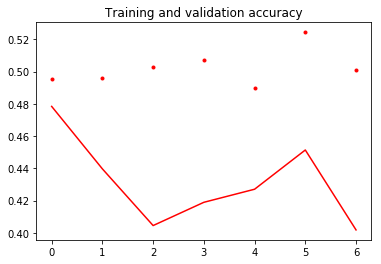

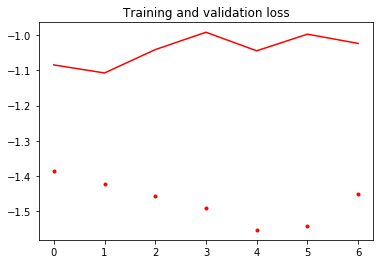

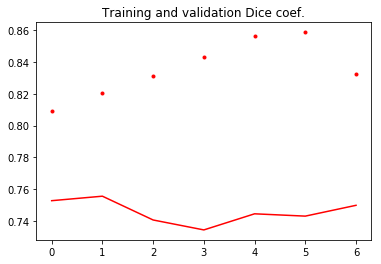

In [31]:
plot_training(history_1_1)

In [33]:
from keras.optimizers import SGD

model_file_name = 'Efficientnetb3_350x525_SGD_v1'

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=2, min_delta=1e-3),
             ModelCheckpoint(monitor='val_loss', filepath='./checkpoints/' + str(model_file_name) + '.h5', 
                             save_best_only=True, save_weights_only=False)]

sgd = SGD(lr=1e-4, decay=3e-6, momentum=0.92, nesterov=True)
model.compile(optimizer=sgd, loss=bce_dice_loss, metrics=['accuracy', dice_coeff])
history_1_2 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=callbacks,
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


132/739 [====>.........................] - ETA: 5:20:13 - loss: -1.5686 - acc: 0.6667 - dice_coeff: 0.84 - ETA: 2:43:55 - loss: -1.5072 - acc: 0.7500 - dice_coeff: 0.83 - ETA: 1:51:47 - loss: -1.5233 - acc: 0.5000 - dice_coeff: 0.84 - ETA: 1:25:43 - loss: -1.5752 - acc: 0.5833 - dice_coeff: 0.85 - ETA: 1:10:02 - loss: -1.5771 - acc: 0.4667 - dice_coeff: 0.85 - ETA: 59:38 - loss: -1.5591 - acc: 0.4444 - dice_coeff: 0.8550 - ETA: 52:10 - loss: -1.5263 - acc: 0.4048 - dice_coeff: 0.84 - ETA: 46:35 - loss: -1.5615 - acc: 0.4167 - dice_coeff: 0.85 - ETA: 42:13 - loss: -1.5847 - acc: 0.3889 - dice_coeff: 0.86 - ETA: 38:44 - loss: -1.5899 - acc: 0.4333 - dice_coeff: 0.86 - ETA: 35:53 - loss: -1.6087 - acc: 0.4697 - dice_coeff: 0.87 - ETA: 33:30 - loss: -1.6069 - acc: 0.4722 - dice_coeff: 0.87 - ETA: 31:29 - loss: -1.6003 - acc: 0.4744 - dice_coeff: 0.86 - ETA: 29:46 - loss: -1.5972 - acc: 0.4643 - dice_coeff: 0.86 - ETA: 28:16 - loss: -1.6110 - acc: 0.4667 - dice_coeff: 0.87 - ETA: 26:57 - lo

264/739 [=========>....................] - ETA: 8:32 - loss: -1.4880 - acc: 0.4737 - dice_coeff: 0.834 - ETA: 8:30 - loss: -1.4882 - acc: 0.4751 - dice_coeff: 0.834 - ETA: 8:29 - loss: -1.4869 - acc: 0.4753 - dice_coeff: 0.834 - ETA: 8:27 - loss: -1.4877 - acc: 0.4767 - dice_coeff: 0.834 - ETA: 8:25 - loss: -1.4880 - acc: 0.4781 - dice_coeff: 0.835 - ETA: 8:24 - loss: -1.4880 - acc: 0.4771 - dice_coeff: 0.835 - ETA: 8:22 - loss: -1.4877 - acc: 0.4760 - dice_coeff: 0.835 - ETA: 8:21 - loss: -1.4875 - acc: 0.4750 - dice_coeff: 0.834 - ETA: 8:19 - loss: -1.4892 - acc: 0.4752 - dice_coeff: 0.835 - ETA: 8:17 - loss: -1.4907 - acc: 0.4730 - dice_coeff: 0.835 - ETA: 8:16 - loss: -1.4899 - acc: 0.4744 - dice_coeff: 0.835 - ETA: 8:14 - loss: -1.4905 - acc: 0.4769 - dice_coeff: 0.835 - ETA: 8:13 - loss: -1.4902 - acc: 0.4770 - dice_coeff: 0.835 - ETA: 8:11 - loss: -1.4912 - acc: 0.4783 - dice_coeff: 0.835 - ETA: 8:10 - loss: -1.4897 - acc: 0.4762 - dice_coeff: 0.835 - ETA: 8:08 - loss: -1.4903 -

396/739 [===============>..............] - ETA: 5:55 - loss: -1.4952 - acc: 0.4786 - dice_coeff: 0.838 - ETA: 5:54 - loss: -1.4944 - acc: 0.4793 - dice_coeff: 0.837 - ETA: 5:53 - loss: -1.4938 - acc: 0.4800 - dice_coeff: 0.837 - ETA: 5:52 - loss: -1.4936 - acc: 0.4807 - dice_coeff: 0.837 - ETA: 5:52 - loss: -1.4940 - acc: 0.4814 - dice_coeff: 0.837 - ETA: 5:51 - loss: -1.4944 - acc: 0.4821 - dice_coeff: 0.837 - ETA: 5:50 - loss: -1.4949 - acc: 0.4815 - dice_coeff: 0.838 - ETA: 5:49 - loss: -1.4954 - acc: 0.4810 - dice_coeff: 0.838 - ETA: 5:48 - loss: -1.4952 - acc: 0.4799 - dice_coeff: 0.838 - ETA: 5:47 - loss: -1.4964 - acc: 0.4799 - dice_coeff: 0.838 - ETA: 5:46 - loss: -1.4978 - acc: 0.4794 - dice_coeff: 0.838 - ETA: 5:45 - loss: -1.4982 - acc: 0.4795 - dice_coeff: 0.839 - ETA: 5:44 - loss: -1.4985 - acc: 0.4801 - dice_coeff: 0.839 - ETA: 5:43 - loss: -1.4990 - acc: 0.4808 - dice_coeff: 0.839 - ETA: 5:42 - loss: -1.4991 - acc: 0.4803 - dice_coeff: 0.839 - ETA: 5:42 - loss: -1.4990 -

528/739 [====================>.........] - ETA: 4:05 - loss: -1.5042 - acc: 0.4887 - dice_coeff: 0.841 - ETA: 4:04 - loss: -1.5047 - acc: 0.4887 - dice_coeff: 0.841 - ETA: 4:04 - loss: -1.5044 - acc: 0.4887 - dice_coeff: 0.841 - ETA: 4:03 - loss: -1.5040 - acc: 0.4888 - dice_coeff: 0.841 - ETA: 4:02 - loss: -1.5044 - acc: 0.4884 - dice_coeff: 0.841 - ETA: 4:01 - loss: -1.5050 - acc: 0.4892 - dice_coeff: 0.841 - ETA: 4:01 - loss: -1.5053 - acc: 0.4884 - dice_coeff: 0.841 - ETA: 4:00 - loss: -1.5056 - acc: 0.4880 - dice_coeff: 0.841 - ETA: 3:59 - loss: -1.5060 - acc: 0.4885 - dice_coeff: 0.841 - ETA: 3:58 - loss: -1.5059 - acc: 0.4881 - dice_coeff: 0.841 - ETA: 3:57 - loss: -1.5060 - acc: 0.4869 - dice_coeff: 0.841 - ETA: 3:57 - loss: -1.5063 - acc: 0.4869 - dice_coeff: 0.841 - ETA: 3:56 - loss: -1.5058 - acc: 0.4870 - dice_coeff: 0.841 - ETA: 3:55 - loss: -1.5060 - acc: 0.4874 - dice_coeff: 0.841 - ETA: 3:54 - loss: -1.5060 - acc: 0.4882 - dice_coeff: 0.841 - ETA: 3:54 - loss: -1.5064 -

660/739 [=========================>....] - ETA: 2:27 - loss: -1.5140 - acc: 0.4836 - dice_coeff: 0.844 - ETA: 2:26 - loss: -1.5141 - acc: 0.4843 - dice_coeff: 0.844 - ETA: 2:26 - loss: -1.5143 - acc: 0.4843 - dice_coeff: 0.844 - ETA: 2:25 - loss: -1.5141 - acc: 0.4843 - dice_coeff: 0.844 - ETA: 2:24 - loss: -1.5145 - acc: 0.4844 - dice_coeff: 0.844 - ETA: 2:23 - loss: -1.5149 - acc: 0.4847 - dice_coeff: 0.844 - ETA: 2:23 - loss: -1.5154 - acc: 0.4841 - dice_coeff: 0.844 - ETA: 2:22 - loss: -1.5155 - acc: 0.4845 - dice_coeff: 0.844 - ETA: 2:21 - loss: -1.5155 - acc: 0.4845 - dice_coeff: 0.844 - ETA: 2:21 - loss: -1.5157 - acc: 0.4848 - dice_coeff: 0.844 - ETA: 2:20 - loss: -1.5161 - acc: 0.4852 - dice_coeff: 0.844 - ETA: 2:19 - loss: -1.5162 - acc: 0.4849 - dice_coeff: 0.844 - ETA: 2:18 - loss: -1.5164 - acc: 0.4852 - dice_coeff: 0.844 - ETA: 2:18 - loss: -1.5166 - acc: 0.4852 - dice_coeff: 0.844 - ETA: 2:17 - loss: -1.5162 - acc: 0.4850 - dice_coeff: 0.844 - ETA: 2:16 - loss: -1.5161 -

739/739 [==============================] - ETA: 54s - loss: -1.5210 - acc: 0.4874 - dice_coeff: 0.84 - ETA: 53s - loss: -1.5209 - acc: 0.4867 - dice_coeff: 0.84 - ETA: 52s - loss: -1.5214 - acc: 0.4867 - dice_coeff: 0.84 - ETA: 51s - loss: -1.5214 - acc: 0.4867 - dice_coeff: 0.84 - ETA: 51s - loss: -1.5216 - acc: 0.4862 - dice_coeff: 0.84 - ETA: 50s - loss: -1.5212 - acc: 0.4865 - dice_coeff: 0.84 - ETA: 49s - loss: -1.5212 - acc: 0.4860 - dice_coeff: 0.84 - ETA: 49s - loss: -1.5209 - acc: 0.4860 - dice_coeff: 0.84 - ETA: 48s - loss: -1.5210 - acc: 0.4863 - dice_coeff: 0.84 - ETA: 47s - loss: -1.5209 - acc: 0.4868 - dice_coeff: 0.84 - ETA: 47s - loss: -1.5207 - acc: 0.4871 - dice_coeff: 0.84 - ETA: 46s - loss: -1.5211 - acc: 0.4871 - dice_coeff: 0.84 - ETA: 45s - loss: -1.5207 - acc: 0.4869 - dice_coeff: 0.84 - ETA: 44s - loss: -1.5210 - acc: 0.4869 - dice_coeff: 0.84 - ETA: 44s - loss: -1.5206 - acc: 0.4869 - dice_coeff: 0.84 - ETA: 43s - loss: -1.5208 - acc: 0.4864 - dice_coeff: 0.84

132/739 [====>.........................] - ETA: 8:22 - loss: -1.6553 - acc: 0.6667 - dice_coeff: 0.871 - ETA: 8:10 - loss: -1.5882 - acc: 0.4167 - dice_coeff: 0.863 - ETA: 8:06 - loss: -1.4389 - acc: 0.4444 - dice_coeff: 0.818 - ETA: 8:06 - loss: -1.5277 - acc: 0.5833 - dice_coeff: 0.845 - ETA: 8:08 - loss: -1.5699 - acc: 0.6000 - dice_coeff: 0.856 - ETA: 8:06 - loss: -1.5310 - acc: 0.6389 - dice_coeff: 0.844 - ETA: 8:04 - loss: -1.5209 - acc: 0.5714 - dice_coeff: 0.843 - ETA: 8:03 - loss: -1.5064 - acc: 0.5833 - dice_coeff: 0.840 - ETA: 8:03 - loss: -1.4925 - acc: 0.5926 - dice_coeff: 0.836 - ETA: 8:03 - loss: -1.4920 - acc: 0.5833 - dice_coeff: 0.837 - ETA: 8:01 - loss: -1.4987 - acc: 0.5606 - dice_coeff: 0.838 - ETA: 8:01 - loss: -1.5236 - acc: 0.5833 - dice_coeff: 0.845 - ETA: 8:01 - loss: -1.5006 - acc: 0.5769 - dice_coeff: 0.840 - ETA: 8:00 - loss: -1.5142 - acc: 0.5714 - dice_coeff: 0.843 - ETA: 8:00 - loss: -1.5211 - acc: 0.5667 - dice_coeff: 0.845 - ETA: 7:59 - loss: -1.5330 -

264/739 [=========>....................] - ETA: 6:41 - loss: -1.5590 - acc: 0.5025 - dice_coeff: 0.855 - ETA: 6:41 - loss: -1.5573 - acc: 0.5025 - dice_coeff: 0.855 - ETA: 6:40 - loss: -1.5573 - acc: 0.5012 - dice_coeff: 0.855 - ETA: 6:40 - loss: -1.5561 - acc: 0.5025 - dice_coeff: 0.855 - ETA: 6:39 - loss: -1.5565 - acc: 0.5036 - dice_coeff: 0.855 - ETA: 6:38 - loss: -1.5573 - acc: 0.5024 - dice_coeff: 0.855 - ETA: 6:38 - loss: -1.5538 - acc: 0.5036 - dice_coeff: 0.854 - ETA: 6:37 - loss: -1.5544 - acc: 0.5060 - dice_coeff: 0.854 - ETA: 6:36 - loss: -1.5547 - acc: 0.5071 - dice_coeff: 0.854 - ETA: 6:36 - loss: -1.5557 - acc: 0.5070 - dice_coeff: 0.854 - ETA: 6:35 - loss: -1.5548 - acc: 0.5070 - dice_coeff: 0.854 - ETA: 6:34 - loss: -1.5555 - acc: 0.5069 - dice_coeff: 0.854 - ETA: 6:34 - loss: -1.5558 - acc: 0.5046 - dice_coeff: 0.854 - ETA: 6:33 - loss: -1.5559 - acc: 0.5034 - dice_coeff: 0.854 - ETA: 6:32 - loss: -1.5572 - acc: 0.5023 - dice_coeff: 0.855 - ETA: 6:32 - loss: -1.5551 -

396/739 [===============>..............] - ETA: 5:14 - loss: -1.5362 - acc: 0.4943 - dice_coeff: 0.851 - ETA: 5:13 - loss: -1.5353 - acc: 0.4944 - dice_coeff: 0.850 - ETA: 5:12 - loss: -1.5363 - acc: 0.4944 - dice_coeff: 0.851 - ETA: 5:12 - loss: -1.5366 - acc: 0.4950 - dice_coeff: 0.851 - ETA: 5:11 - loss: -1.5366 - acc: 0.4944 - dice_coeff: 0.851 - ETA: 5:10 - loss: -1.5351 - acc: 0.4951 - dice_coeff: 0.850 - ETA: 5:10 - loss: -1.5351 - acc: 0.4938 - dice_coeff: 0.850 - ETA: 5:09 - loss: -1.5351 - acc: 0.4939 - dice_coeff: 0.850 - ETA: 5:08 - loss: -1.5348 - acc: 0.4933 - dice_coeff: 0.850 - ETA: 5:08 - loss: -1.5354 - acc: 0.4939 - dice_coeff: 0.850 - ETA: 5:07 - loss: -1.5348 - acc: 0.4939 - dice_coeff: 0.850 - ETA: 5:06 - loss: -1.5349 - acc: 0.4946 - dice_coeff: 0.850 - ETA: 5:06 - loss: -1.5337 - acc: 0.4940 - dice_coeff: 0.850 - ETA: 5:05 - loss: -1.5343 - acc: 0.4940 - dice_coeff: 0.850 - ETA: 5:04 - loss: -1.5352 - acc: 0.4946 - dice_coeff: 0.850 - ETA: 5:04 - loss: -1.5360 -

528/739 [====================>.........] - ETA: 3:46 - loss: -1.5294 - acc: 0.4954 - dice_coeff: 0.849 - ETA: 3:45 - loss: -1.5295 - acc: 0.4946 - dice_coeff: 0.849 - ETA: 3:45 - loss: -1.5286 - acc: 0.4950 - dice_coeff: 0.849 - ETA: 3:44 - loss: -1.5286 - acc: 0.4950 - dice_coeff: 0.849 - ETA: 3:43 - loss: -1.5282 - acc: 0.4946 - dice_coeff: 0.848 - ETA: 3:43 - loss: -1.5279 - acc: 0.4946 - dice_coeff: 0.848 - ETA: 3:42 - loss: -1.5278 - acc: 0.4950 - dice_coeff: 0.848 - ETA: 3:41 - loss: -1.5275 - acc: 0.4946 - dice_coeff: 0.848 - ETA: 3:41 - loss: -1.5269 - acc: 0.4938 - dice_coeff: 0.848 - ETA: 3:40 - loss: -1.5270 - acc: 0.4938 - dice_coeff: 0.848 - ETA: 3:39 - loss: -1.5253 - acc: 0.4939 - dice_coeff: 0.848 - ETA: 3:39 - loss: -1.5259 - acc: 0.4935 - dice_coeff: 0.848 - ETA: 3:38 - loss: -1.5259 - acc: 0.4931 - dice_coeff: 0.848 - ETA: 3:38 - loss: -1.5265 - acc: 0.4935 - dice_coeff: 0.848 - ETA: 3:37 - loss: -1.5258 - acc: 0.4939 - dice_coeff: 0.848 - ETA: 3:36 - loss: -1.5261 -

660/739 [=========================>....] - ETA: 2:19 - loss: -1.5333 - acc: 0.4950 - dice_coeff: 0.850 - ETA: 2:18 - loss: -1.5337 - acc: 0.4947 - dice_coeff: 0.850 - ETA: 2:17 - loss: -1.5330 - acc: 0.4947 - dice_coeff: 0.850 - ETA: 2:17 - loss: -1.5333 - acc: 0.4944 - dice_coeff: 0.850 - ETA: 2:16 - loss: -1.5328 - acc: 0.4937 - dice_coeff: 0.850 - ETA: 2:15 - loss: -1.5332 - acc: 0.4931 - dice_coeff: 0.850 - ETA: 2:15 - loss: -1.5334 - acc: 0.4931 - dice_coeff: 0.850 - ETA: 2:14 - loss: -1.5334 - acc: 0.4932 - dice_coeff: 0.850 - ETA: 2:13 - loss: -1.5340 - acc: 0.4932 - dice_coeff: 0.850 - ETA: 2:13 - loss: -1.5330 - acc: 0.4929 - dice_coeff: 0.850 - ETA: 2:12 - loss: -1.5331 - acc: 0.4929 - dice_coeff: 0.850 - ETA: 2:11 - loss: -1.5334 - acc: 0.4926 - dice_coeff: 0.850 - ETA: 2:11 - loss: -1.5334 - acc: 0.4926 - dice_coeff: 0.850 - ETA: 2:10 - loss: -1.5336 - acc: 0.4929 - dice_coeff: 0.850 - ETA: 2:09 - loss: -1.5337 - acc: 0.4932 - dice_coeff: 0.850 - ETA: 2:09 - loss: -1.5336 -

739/739 [==============================] - ETA: 51s - loss: -1.5362 - acc: 0.4907 - dice_coeff: 0.85 - ETA: 51s - loss: -1.5366 - acc: 0.4907 - dice_coeff: 0.85 - ETA: 50s - loss: -1.5368 - acc: 0.4907 - dice_coeff: 0.85 - ETA: 49s - loss: -1.5368 - acc: 0.4907 - dice_coeff: 0.85 - ETA: 49s - loss: -1.5368 - acc: 0.4900 - dice_coeff: 0.85 - ETA: 48s - loss: -1.5372 - acc: 0.4897 - dice_coeff: 0.85 - ETA: 47s - loss: -1.5372 - acc: 0.4895 - dice_coeff: 0.85 - ETA: 47s - loss: -1.5374 - acc: 0.4898 - dice_coeff: 0.85 - ETA: 46s - loss: -1.5377 - acc: 0.4895 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5381 - acc: 0.4896 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5379 - acc: 0.4896 - dice_coeff: 0.85 - ETA: 44s - loss: -1.5383 - acc: 0.4896 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5382 - acc: 0.4901 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5384 - acc: 0.4901 - dice_coeff: 0.85 - ETA: 42s - loss: -1.5378 - acc: 0.4906 - dice_coeff: 0.85 - ETA: 41s - loss: -1.5382 - acc: 0.4904 - dice_coeff: 0.85

132/739 [====>.........................] - ETA: 8:12 - loss: -1.1527 - acc: 0.5000 - dice_coeff: 0.747 - ETA: 8:06 - loss: -1.2855 - acc: 0.4167 - dice_coeff: 0.782 - ETA: 8:07 - loss: -1.4749 - acc: 0.3333 - dice_coeff: 0.837 - ETA: 8:07 - loss: -1.4345 - acc: 0.3750 - dice_coeff: 0.826 - ETA: 8:07 - loss: -1.3728 - acc: 0.3667 - dice_coeff: 0.809 - ETA: 8:04 - loss: -1.3427 - acc: 0.3056 - dice_coeff: 0.804 - ETA: 8:04 - loss: -1.3864 - acc: 0.3333 - dice_coeff: 0.814 - ETA: 8:02 - loss: -1.4083 - acc: 0.3958 - dice_coeff: 0.819 - ETA: 8:02 - loss: -1.4217 - acc: 0.3889 - dice_coeff: 0.823 - ETA: 8:02 - loss: -1.4484 - acc: 0.4000 - dice_coeff: 0.830 - ETA: 8:00 - loss: -1.4269 - acc: 0.3636 - dice_coeff: 0.826 - ETA: 8:01 - loss: -1.4417 - acc: 0.4028 - dice_coeff: 0.830 - ETA: 8:00 - loss: -1.4344 - acc: 0.4487 - dice_coeff: 0.825 - ETA: 7:59 - loss: -1.4420 - acc: 0.4643 - dice_coeff: 0.828 - ETA: 7:58 - loss: -1.4721 - acc: 0.4333 - dice_coeff: 0.836 - ETA: 7:57 - loss: -1.4698 -

264/739 [=========>....................] - ETA: 6:42 - loss: -1.5449 - acc: 0.4900 - dice_coeff: 0.854 - ETA: 6:41 - loss: -1.5452 - acc: 0.4900 - dice_coeff: 0.854 - ETA: 6:41 - loss: -1.5430 - acc: 0.4901 - dice_coeff: 0.854 - ETA: 6:40 - loss: -1.5411 - acc: 0.4902 - dice_coeff: 0.853 - ETA: 6:39 - loss: -1.5433 - acc: 0.4915 - dice_coeff: 0.854 - ETA: 6:39 - loss: -1.5447 - acc: 0.4952 - dice_coeff: 0.854 - ETA: 6:38 - loss: -1.5456 - acc: 0.4964 - dice_coeff: 0.854 - ETA: 6:37 - loss: -1.5421 - acc: 0.4940 - dice_coeff: 0.853 - ETA: 6:37 - loss: -1.5412 - acc: 0.4953 - dice_coeff: 0.853 - ETA: 6:36 - loss: -1.5421 - acc: 0.4953 - dice_coeff: 0.853 - ETA: 6:35 - loss: -1.5431 - acc: 0.4953 - dice_coeff: 0.854 - ETA: 6:35 - loss: -1.5433 - acc: 0.4965 - dice_coeff: 0.854 - ETA: 6:34 - loss: -1.5443 - acc: 0.4943 - dice_coeff: 0.854 - ETA: 6:33 - loss: -1.5452 - acc: 0.4943 - dice_coeff: 0.854 - ETA: 6:33 - loss: -1.5448 - acc: 0.4932 - dice_coeff: 0.854 - ETA: 6:32 - loss: -1.5454 -

396/739 [===============>..............] - ETA: 5:14 - loss: -1.5392 - acc: 0.5057 - dice_coeff: 0.852 - ETA: 5:14 - loss: -1.5396 - acc: 0.5056 - dice_coeff: 0.853 - ETA: 5:13 - loss: -1.5401 - acc: 0.5050 - dice_coeff: 0.853 - ETA: 5:12 - loss: -1.5411 - acc: 0.5062 - dice_coeff: 0.853 - ETA: 5:12 - loss: -1.5414 - acc: 0.5068 - dice_coeff: 0.853 - ETA: 5:11 - loss: -1.5415 - acc: 0.5080 - dice_coeff: 0.853 - ETA: 5:10 - loss: -1.5410 - acc: 0.5080 - dice_coeff: 0.853 - ETA: 5:10 - loss: -1.5409 - acc: 0.5080 - dice_coeff: 0.853 - ETA: 5:09 - loss: -1.5418 - acc: 0.5079 - dice_coeff: 0.853 - ETA: 5:08 - loss: -1.5424 - acc: 0.5073 - dice_coeff: 0.853 - ETA: 5:08 - loss: -1.5413 - acc: 0.5085 - dice_coeff: 0.853 - ETA: 5:07 - loss: -1.5406 - acc: 0.5079 - dice_coeff: 0.853 - ETA: 5:06 - loss: -1.5416 - acc: 0.5090 - dice_coeff: 0.853 - ETA: 5:06 - loss: -1.5424 - acc: 0.5096 - dice_coeff: 0.853 - ETA: 5:05 - loss: -1.5428 - acc: 0.5084 - dice_coeff: 0.853 - ETA: 5:04 - loss: -1.5430 -

528/739 [====================>.........] - ETA: 3:47 - loss: -1.5367 - acc: 0.5034 - dice_coeff: 0.851 - ETA: 3:46 - loss: -1.5367 - acc: 0.5029 - dice_coeff: 0.852 - ETA: 3:45 - loss: -1.5368 - acc: 0.5029 - dice_coeff: 0.852 - ETA: 3:45 - loss: -1.5358 - acc: 0.5029 - dice_coeff: 0.851 - ETA: 3:44 - loss: -1.5358 - acc: 0.5033 - dice_coeff: 0.851 - ETA: 3:43 - loss: -1.5361 - acc: 0.5025 - dice_coeff: 0.852 - ETA: 3:43 - loss: -1.5363 - acc: 0.5025 - dice_coeff: 0.852 - ETA: 3:42 - loss: -1.5364 - acc: 0.5021 - dice_coeff: 0.852 - ETA: 3:41 - loss: -1.5361 - acc: 0.5021 - dice_coeff: 0.851 - ETA: 3:41 - loss: -1.5359 - acc: 0.5021 - dice_coeff: 0.851 - ETA: 3:40 - loss: -1.5366 - acc: 0.5025 - dice_coeff: 0.852 - ETA: 3:39 - loss: -1.5361 - acc: 0.5025 - dice_coeff: 0.851 - ETA: 3:39 - loss: -1.5364 - acc: 0.5033 - dice_coeff: 0.852 - ETA: 3:38 - loss: -1.5360 - acc: 0.5024 - dice_coeff: 0.851 - ETA: 3:37 - loss: -1.5360 - acc: 0.5028 - dice_coeff: 0.851 - ETA: 3:37 - loss: -1.5358 -

660/739 [=========================>....] - ETA: 2:19 - loss: -1.5387 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:18 - loss: -1.5390 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:18 - loss: -1.5388 - acc: 0.5013 - dice_coeff: 0.852 - ETA: 2:17 - loss: -1.5383 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:16 - loss: -1.5388 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:16 - loss: -1.5386 - acc: 0.5006 - dice_coeff: 0.852 - ETA: 2:15 - loss: -1.5388 - acc: 0.5006 - dice_coeff: 0.852 - ETA: 2:14 - loss: -1.5387 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:14 - loss: -1.5389 - acc: 0.5012 - dice_coeff: 0.852 - ETA: 2:13 - loss: -1.5387 - acc: 0.5012 - dice_coeff: 0.852 - ETA: 2:12 - loss: -1.5389 - acc: 0.5015 - dice_coeff: 0.852 - ETA: 2:12 - loss: -1.5391 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:11 - loss: -1.5392 - acc: 0.5012 - dice_coeff: 0.852 - ETA: 2:10 - loss: -1.5393 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:10 - loss: -1.5389 - acc: 0.5009 - dice_coeff: 0.852 - ETA: 2:09 - loss: -1.5385 -

739/739 [==============================] - ETA: 51s - loss: -1.5430 - acc: 0.5050 - dice_coeff: 0.85 - ETA: 51s - loss: -1.5430 - acc: 0.5048 - dice_coeff: 0.85 - ETA: 50s - loss: -1.5423 - acc: 0.5050 - dice_coeff: 0.85 - ETA: 49s - loss: -1.5424 - acc: 0.5053 - dice_coeff: 0.85 - ETA: 49s - loss: -1.5426 - acc: 0.5050 - dice_coeff: 0.85 - ETA: 48s - loss: -1.5426 - acc: 0.5053 - dice_coeff: 0.85 - ETA: 47s - loss: -1.5424 - acc: 0.5047 - dice_coeff: 0.85 - ETA: 47s - loss: -1.5420 - acc: 0.5045 - dice_coeff: 0.85 - ETA: 46s - loss: -1.5424 - acc: 0.5050 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5426 - acc: 0.5052 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5426 - acc: 0.5057 - dice_coeff: 0.85 - ETA: 44s - loss: -1.5430 - acc: 0.5060 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5430 - acc: 0.5059 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5432 - acc: 0.5057 - dice_coeff: 0.85 - ETA: 42s - loss: -1.5433 - acc: 0.5059 - dice_coeff: 0.85 - ETA: 41s - loss: -1.5432 - acc: 0.5057 - dice_coeff: 0.85

132/739 [====>.........................] - ETA: 8:11 - loss: -1.5833 - acc: 0.5000 - dice_coeff: 0.868 - ETA: 8:16 - loss: -1.6366 - acc: 0.5000 - dice_coeff: 0.878 - ETA: 8:14 - loss: -1.6208 - acc: 0.6667 - dice_coeff: 0.878 - ETA: 8:12 - loss: -1.5627 - acc: 0.5417 - dice_coeff: 0.866 - ETA: 8:13 - loss: -1.5885 - acc: 0.5333 - dice_coeff: 0.870 - ETA: 8:10 - loss: -1.5737 - acc: 0.5000 - dice_coeff: 0.868 - ETA: 8:11 - loss: -1.5063 - acc: 0.5238 - dice_coeff: 0.850 - ETA: 8:08 - loss: -1.5214 - acc: 0.5000 - dice_coeff: 0.853 - ETA: 8:07 - loss: -1.5310 - acc: 0.5185 - dice_coeff: 0.856 - ETA: 8:06 - loss: -1.5334 - acc: 0.5500 - dice_coeff: 0.854 - ETA: 8:06 - loss: -1.5490 - acc: 0.5758 - dice_coeff: 0.859 - ETA: 8:04 - loss: -1.5520 - acc: 0.5694 - dice_coeff: 0.860 - ETA: 8:03 - loss: -1.5521 - acc: 0.5641 - dice_coeff: 0.859 - ETA: 8:03 - loss: -1.5695 - acc: 0.5714 - dice_coeff: 0.864 - ETA: 8:02 - loss: -1.5619 - acc: 0.5778 - dice_coeff: 0.862 - ETA: 8:01 - loss: -1.5601 -

264/739 [=========>....................] - ETA: 6:42 - loss: -1.5643 - acc: 0.5063 - dice_coeff: 0.859 - ETA: 6:42 - loss: -1.5631 - acc: 0.5050 - dice_coeff: 0.858 - ETA: 6:41 - loss: -1.5647 - acc: 0.5049 - dice_coeff: 0.859 - ETA: 6:40 - loss: -1.5637 - acc: 0.5074 - dice_coeff: 0.859 - ETA: 6:39 - loss: -1.5623 - acc: 0.5085 - dice_coeff: 0.858 - ETA: 6:39 - loss: -1.5596 - acc: 0.5060 - dice_coeff: 0.858 - ETA: 6:38 - loss: -1.5586 - acc: 0.5036 - dice_coeff: 0.857 - ETA: 6:38 - loss: -1.5596 - acc: 0.5048 - dice_coeff: 0.858 - ETA: 6:37 - loss: -1.5610 - acc: 0.5047 - dice_coeff: 0.858 - ETA: 6:36 - loss: -1.5607 - acc: 0.5059 - dice_coeff: 0.858 - ETA: 6:35 - loss: -1.5621 - acc: 0.5047 - dice_coeff: 0.858 - ETA: 6:35 - loss: -1.5627 - acc: 0.5046 - dice_coeff: 0.858 - ETA: 6:34 - loss: -1.5635 - acc: 0.5023 - dice_coeff: 0.859 - ETA: 6:34 - loss: -1.5639 - acc: 0.5046 - dice_coeff: 0.859 - ETA: 6:33 - loss: -1.5617 - acc: 0.5045 - dice_coeff: 0.858 - ETA: 6:32 - loss: -1.5611 -

396/739 [===============>..............] - ETA: 5:14 - loss: -1.5519 - acc: 0.4906 - dice_coeff: 0.856 - ETA: 5:14 - loss: -1.5522 - acc: 0.4912 - dice_coeff: 0.856 - ETA: 5:13 - loss: -1.5513 - acc: 0.4919 - dice_coeff: 0.856 - ETA: 5:12 - loss: -1.5513 - acc: 0.4907 - dice_coeff: 0.856 - ETA: 5:12 - loss: -1.5520 - acc: 0.4907 - dice_coeff: 0.856 - ETA: 5:11 - loss: -1.5514 - acc: 0.4920 - dice_coeff: 0.856 - ETA: 5:10 - loss: -1.5510 - acc: 0.4938 - dice_coeff: 0.856 - ETA: 5:10 - loss: -1.5508 - acc: 0.4933 - dice_coeff: 0.856 - ETA: 5:09 - loss: -1.5515 - acc: 0.4939 - dice_coeff: 0.856 - ETA: 5:08 - loss: -1.5526 - acc: 0.4939 - dice_coeff: 0.856 - ETA: 5:08 - loss: -1.5524 - acc: 0.4933 - dice_coeff: 0.856 - ETA: 5:07 - loss: -1.5526 - acc: 0.4928 - dice_coeff: 0.856 - ETA: 5:06 - loss: -1.5512 - acc: 0.4922 - dice_coeff: 0.856 - ETA: 5:06 - loss: -1.5522 - acc: 0.4934 - dice_coeff: 0.856 - ETA: 5:05 - loss: -1.5521 - acc: 0.4928 - dice_coeff: 0.856 - ETA: 5:04 - loss: -1.5521 -

528/739 [====================>.........] - ETA: 3:47 - loss: -1.5473 - acc: 0.5021 - dice_coeff: 0.854 - ETA: 3:46 - loss: -1.5473 - acc: 0.5021 - dice_coeff: 0.854 - ETA: 3:45 - loss: -1.5477 - acc: 0.5025 - dice_coeff: 0.854 - ETA: 3:45 - loss: -1.5482 - acc: 0.5021 - dice_coeff: 0.855 - ETA: 3:44 - loss: -1.5476 - acc: 0.5025 - dice_coeff: 0.854 - ETA: 3:43 - loss: -1.5470 - acc: 0.5029 - dice_coeff: 0.854 - ETA: 3:43 - loss: -1.5477 - acc: 0.5029 - dice_coeff: 0.854 - ETA: 3:42 - loss: -1.5481 - acc: 0.5033 - dice_coeff: 0.854 - ETA: 3:41 - loss: -1.5484 - acc: 0.5037 - dice_coeff: 0.854 - ETA: 3:41 - loss: -1.5487 - acc: 0.5037 - dice_coeff: 0.855 - ETA: 3:40 - loss: -1.5486 - acc: 0.5033 - dice_coeff: 0.855 - ETA: 3:39 - loss: -1.5486 - acc: 0.5037 - dice_coeff: 0.854 - ETA: 3:39 - loss: -1.5489 - acc: 0.5037 - dice_coeff: 0.855 - ETA: 3:38 - loss: -1.5486 - acc: 0.5028 - dice_coeff: 0.854 - ETA: 3:37 - loss: -1.5490 - acc: 0.5032 - dice_coeff: 0.855 - ETA: 3:37 - loss: -1.5494 -

660/739 [=========================>....] - ETA: 2:19 - loss: -1.5550 - acc: 0.5044 - dice_coeff: 0.856 - ETA: 2:18 - loss: -1.5552 - acc: 0.5044 - dice_coeff: 0.856 - ETA: 2:18 - loss: -1.5547 - acc: 0.5038 - dice_coeff: 0.856 - ETA: 2:17 - loss: -1.5546 - acc: 0.5034 - dice_coeff: 0.856 - ETA: 2:16 - loss: -1.5548 - acc: 0.5034 - dice_coeff: 0.856 - ETA: 2:16 - loss: -1.5549 - acc: 0.5028 - dice_coeff: 0.856 - ETA: 2:15 - loss: -1.5555 - acc: 0.5031 - dice_coeff: 0.856 - ETA: 2:14 - loss: -1.5546 - acc: 0.5028 - dice_coeff: 0.856 - ETA: 2:14 - loss: -1.5551 - acc: 0.5025 - dice_coeff: 0.856 - ETA: 2:13 - loss: -1.5554 - acc: 0.5025 - dice_coeff: 0.856 - ETA: 2:12 - loss: -1.5552 - acc: 0.5028 - dice_coeff: 0.856 - ETA: 2:12 - loss: -1.5556 - acc: 0.5025 - dice_coeff: 0.856 - ETA: 2:11 - loss: -1.5547 - acc: 0.5025 - dice_coeff: 0.856 - ETA: 2:10 - loss: -1.5551 - acc: 0.5022 - dice_coeff: 0.856 - ETA: 2:10 - loss: -1.5548 - acc: 0.5021 - dice_coeff: 0.856 - ETA: 2:09 - loss: -1.5548 -

739/739 [==============================] - ETA: 51s - loss: -1.5576 - acc: 0.5035 - dice_coeff: 0.85 - ETA: 51s - loss: -1.5575 - acc: 0.5033 - dice_coeff: 0.85 - ETA: 50s - loss: -1.5569 - acc: 0.5030 - dice_coeff: 0.85 - ETA: 49s - loss: -1.5563 - acc: 0.5028 - dice_coeff: 0.85 - ETA: 49s - loss: -1.5566 - acc: 0.5028 - dice_coeff: 0.85 - ETA: 48s - loss: -1.5568 - acc: 0.5033 - dice_coeff: 0.85 - ETA: 47s - loss: -1.5566 - acc: 0.5030 - dice_coeff: 0.85 - ETA: 47s - loss: -1.5566 - acc: 0.5027 - dice_coeff: 0.85 - ETA: 46s - loss: -1.5567 - acc: 0.5027 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5566 - acc: 0.5030 - dice_coeff: 0.85 - ETA: 45s - loss: -1.5567 - acc: 0.5032 - dice_coeff: 0.85 - ETA: 44s - loss: -1.5567 - acc: 0.5032 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5562 - acc: 0.5035 - dice_coeff: 0.85 - ETA: 43s - loss: -1.5563 - acc: 0.5030 - dice_coeff: 0.85 - ETA: 42s - loss: -1.5561 - acc: 0.5027 - dice_coeff: 0.85 - ETA: 41s - loss: -1.5560 - acc: 0.5022 - dice_coeff: 0.85

132/739 [====>.........................] - ETA: 8:16 - loss: -1.3665 - acc: 0.6667 - dice_coeff: 0.817 - ETA: 8:24 - loss: -1.4096 - acc: 0.5833 - dice_coeff: 0.815 - ETA: 8:23 - loss: -1.4515 - acc: 0.6111 - dice_coeff: 0.825 - ETA: 8:19 - loss: -1.4636 - acc: 0.5833 - dice_coeff: 0.827 - ETA: 8:14 - loss: -1.4863 - acc: 0.5667 - dice_coeff: 0.831 - ETA: 8:12 - loss: -1.5269 - acc: 0.5833 - dice_coeff: 0.842 - ETA: 8:12 - loss: -1.5156 - acc: 0.5952 - dice_coeff: 0.838 - ETA: 8:11 - loss: -1.5397 - acc: 0.5625 - dice_coeff: 0.846 - ETA: 8:10 - loss: -1.5517 - acc: 0.5741 - dice_coeff: 0.849 - ETA: 8:08 - loss: -1.5364 - acc: 0.6000 - dice_coeff: 0.844 - ETA: 8:07 - loss: -1.5500 - acc: 0.6061 - dice_coeff: 0.847 - ETA: 8:05 - loss: -1.5576 - acc: 0.5833 - dice_coeff: 0.851 - ETA: 8:05 - loss: -1.5596 - acc: 0.5641 - dice_coeff: 0.852 - ETA: 8:03 - loss: -1.5643 - acc: 0.5476 - dice_coeff: 0.853 - ETA: 8:04 - loss: -1.5410 - acc: 0.5556 - dice_coeff: 0.845 - ETA: 8:03 - loss: -1.5371 -

264/739 [=========>....................] - ETA: 6:43 - loss: -1.5529 - acc: 0.5150 - dice_coeff: 0.854 - ETA: 6:42 - loss: -1.5551 - acc: 0.5137 - dice_coeff: 0.854 - ETA: 6:41 - loss: -1.5559 - acc: 0.5148 - dice_coeff: 0.855 - ETA: 6:41 - loss: -1.5573 - acc: 0.5147 - dice_coeff: 0.855 - ETA: 6:40 - loss: -1.5572 - acc: 0.5122 - dice_coeff: 0.855 - ETA: 6:39 - loss: -1.5583 - acc: 0.5121 - dice_coeff: 0.855 - ETA: 6:39 - loss: -1.5608 - acc: 0.5132 - dice_coeff: 0.856 - ETA: 6:38 - loss: -1.5604 - acc: 0.5155 - dice_coeff: 0.856 - ETA: 6:37 - loss: -1.5601 - acc: 0.5154 - dice_coeff: 0.856 - ETA: 6:36 - loss: -1.5603 - acc: 0.5141 - dice_coeff: 0.856 - ETA: 6:36 - loss: -1.5593 - acc: 0.5128 - dice_coeff: 0.856 - ETA: 6:35 - loss: -1.5593 - acc: 0.5127 - dice_coeff: 0.856 - ETA: 6:34 - loss: -1.5604 - acc: 0.5126 - dice_coeff: 0.856 - ETA: 6:34 - loss: -1.5567 - acc: 0.5126 - dice_coeff: 0.855 - ETA: 6:33 - loss: -1.5546 - acc: 0.5102 - dice_coeff: 0.855 - ETA: 6:33 - loss: -1.5527 -

396/739 [===============>..............] - ETA: 5:14 - loss: -1.5623 - acc: 0.4987 - dice_coeff: 0.857 - ETA: 5:14 - loss: -1.5617 - acc: 0.4975 - dice_coeff: 0.857 - ETA: 5:13 - loss: -1.5619 - acc: 0.4975 - dice_coeff: 0.857 - ETA: 5:12 - loss: -1.5614 - acc: 0.4981 - dice_coeff: 0.857 - ETA: 5:12 - loss: -1.5624 - acc: 0.4994 - dice_coeff: 0.857 - ETA: 5:11 - loss: -1.5627 - acc: 0.4994 - dice_coeff: 0.857 - ETA: 5:10 - loss: -1.5633 - acc: 0.4982 - dice_coeff: 0.858 - ETA: 5:10 - loss: -1.5634 - acc: 0.4982 - dice_coeff: 0.858 - ETA: 5:09 - loss: -1.5638 - acc: 0.4982 - dice_coeff: 0.858 - ETA: 5:08 - loss: -1.5645 - acc: 0.4982 - dice_coeff: 0.858 - ETA: 5:08 - loss: -1.5643 - acc: 0.4982 - dice_coeff: 0.858 - ETA: 5:07 - loss: -1.5642 - acc: 0.4988 - dice_coeff: 0.858 - ETA: 5:06 - loss: -1.5643 - acc: 0.5000 - dice_coeff: 0.858 - ETA: 5:06 - loss: -1.5644 - acc: 0.4994 - dice_coeff: 0.858 - ETA: 5:05 - loss: -1.5649 - acc: 0.4994 - dice_coeff: 0.858 - ETA: 5:04 - loss: -1.5651 -

528/739 [====================>.........] - ETA: 3:47 - loss: -1.5731 - acc: 0.5025 - dice_coeff: 0.861 - ETA: 3:46 - loss: -1.5736 - acc: 0.5029 - dice_coeff: 0.861 - ETA: 3:45 - loss: -1.5737 - acc: 0.5029 - dice_coeff: 0.861 - ETA: 3:45 - loss: -1.5737 - acc: 0.5038 - dice_coeff: 0.861 - ETA: 3:44 - loss: -1.5739 - acc: 0.5042 - dice_coeff: 0.861 - ETA: 3:43 - loss: -1.5742 - acc: 0.5041 - dice_coeff: 0.861 - ETA: 3:43 - loss: -1.5740 - acc: 0.5037 - dice_coeff: 0.861 - ETA: 3:42 - loss: -1.5743 - acc: 0.5037 - dice_coeff: 0.861 - ETA: 3:41 - loss: -1.5737 - acc: 0.5033 - dice_coeff: 0.861 - ETA: 3:41 - loss: -1.5726 - acc: 0.5025 - dice_coeff: 0.861 - ETA: 3:40 - loss: -1.5729 - acc: 0.5025 - dice_coeff: 0.861 - ETA: 3:39 - loss: -1.5731 - acc: 0.5016 - dice_coeff: 0.861 - ETA: 3:39 - loss: -1.5730 - acc: 0.5016 - dice_coeff: 0.861 - ETA: 3:38 - loss: -1.5729 - acc: 0.5012 - dice_coeff: 0.861 - ETA: 3:37 - loss: -1.5724 - acc: 0.5008 - dice_coeff: 0.861 - ETA: 3:37 - loss: -1.5727 -

660/739 [=========================>....] - ETA: 2:19 - loss: -1.5696 - acc: 0.5126 - dice_coeff: 0.860 - ETA: 2:18 - loss: -1.5691 - acc: 0.5126 - dice_coeff: 0.860 - ETA: 2:18 - loss: -1.5695 - acc: 0.5126 - dice_coeff: 0.860 - ETA: 2:17 - loss: -1.5695 - acc: 0.5125 - dice_coeff: 0.860 - ETA: 2:16 - loss: -1.5695 - acc: 0.5131 - dice_coeff: 0.860 - ETA: 2:16 - loss: -1.5695 - acc: 0.5131 - dice_coeff: 0.860 - ETA: 2:15 - loss: -1.5697 - acc: 0.5134 - dice_coeff: 0.860 - ETA: 2:14 - loss: -1.5699 - acc: 0.5131 - dice_coeff: 0.860 - ETA: 2:14 - loss: -1.5700 - acc: 0.5130 - dice_coeff: 0.860 - ETA: 2:13 - loss: -1.5704 - acc: 0.5130 - dice_coeff: 0.860 - ETA: 2:12 - loss: -1.5702 - acc: 0.5127 - dice_coeff: 0.860 - ETA: 2:12 - loss: -1.5704 - acc: 0.5123 - dice_coeff: 0.860 - ETA: 2:11 - loss: -1.5704 - acc: 0.5129 - dice_coeff: 0.860 - ETA: 2:10 - loss: -1.5700 - acc: 0.5129 - dice_coeff: 0.860 - ETA: 2:10 - loss: -1.5702 - acc: 0.5123 - dice_coeff: 0.860 - ETA: 2:09 - loss: -1.5706 -

739/739 [==============================] - ETA: 51s - loss: -1.5689 - acc: 0.5033 - dice_coeff: 0.86 - ETA: 51s - loss: -1.5687 - acc: 0.5030 - dice_coeff: 0.86 - ETA: 50s - loss: -1.5687 - acc: 0.5030 - dice_coeff: 0.86 - ETA: 49s - loss: -1.5689 - acc: 0.5030 - dice_coeff: 0.86 - ETA: 49s - loss: -1.5683 - acc: 0.5028 - dice_coeff: 0.86 - ETA: 48s - loss: -1.5687 - acc: 0.5028 - dice_coeff: 0.86 - ETA: 47s - loss: -1.5689 - acc: 0.5030 - dice_coeff: 0.86 - ETA: 47s - loss: -1.5690 - acc: 0.5027 - dice_coeff: 0.86 - ETA: 46s - loss: -1.5690 - acc: 0.5025 - dice_coeff: 0.86 - ETA: 45s - loss: -1.5689 - acc: 0.5030 - dice_coeff: 0.86 - ETA: 45s - loss: -1.5682 - acc: 0.5030 - dice_coeff: 0.86 - ETA: 44s - loss: -1.5682 - acc: 0.5032 - dice_coeff: 0.86 - ETA: 43s - loss: -1.5685 - acc: 0.5037 - dice_coeff: 0.86 - ETA: 43s - loss: -1.5683 - acc: 0.5035 - dice_coeff: 0.86 - ETA: 42s - loss: -1.5679 - acc: 0.5035 - dice_coeff: 0.86 - ETA: 41s - loss: -1.5678 - acc: 0.5035 - dice_coeff: 0.86

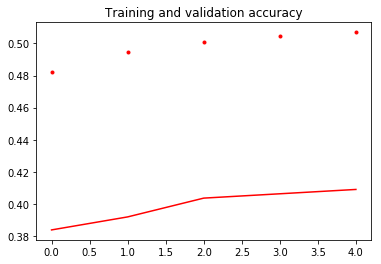

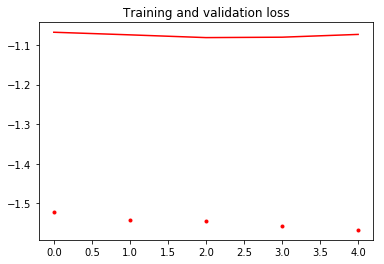

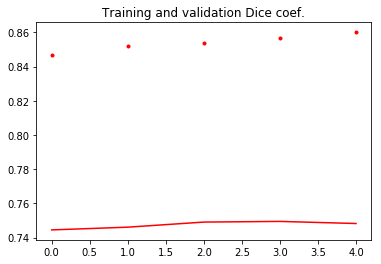

In [34]:
plot_training(history_1_2)

# Selecting postprocessing thresholds

In [ ]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.95, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold]
    if not best_precision_threshold:
        best_precision_threshold = 0.95
    else:
        best_precision_threshold = best_precision_threshold[0]
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) if thres == best_precision_threshold]
        if not recall_for_prec_thres:
            recall_for_prec_thres = 0.94
        else:
            recall_for_prec_thres = recall_for_prec_thres[0]
                                                            
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()
precision_thresholds = dict()
for i, class_name in tqdm(enumerate(class_names)):
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, plot=True)

# Post-processing segmentation submission

Predicting cloud classes for test.

In [45]:
precision_thresholds

{'Fish': 0.95, 'Flower': 0.9999802, 'Sugar': 0.99989897, 'Gravel': 0.9999812}

In [47]:
recall_thresholds

{'Fish': 0.01, 'Flower': 0.08, 'Sugar': 0.05, 'Gravel': 0.07}

{'Fish': 0.01, 'Flower': 0.08, 'Sugar': 0.05, 'Gravel': 0.07} gave 0.6610
{'Fish': 0.001, 'Flower': 0.04, 'Sugar': 0.04, 'Gravel': 0.0} gave 0.6610


In [46]:
recall_thresholds['Gravel'] = 0.07
recall_thresholds['Sugar'] = 0.05
recall_thresholds['Flower'] = 0.08
recall_thresholds['Fish'] = 0.01


In [35]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

Estimating set of images without masks.

In [49]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

Segmentation results:

In [48]:
submission = pd.read_csv('./input/cloudefficientnetb2/submission.csv')
submission.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,5 337 353 343 702 346 1052 347 1401 348 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN


In [50]:
predictions_nonempty = set(submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values)

In [51]:
print(f'{len(image_labels_empty.intersection(predictions_nonempty))} masks would be removed')

140 masks would be removed


In [52]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
submission.to_csv('submission_350x525_differnet_optimizers.csv', index=None)

# Future work
1. estimate distribution of classes in test set using the classifier. Then, if necessary and doable, modify val set accordingly,
2. use the classifier with explainability technique [Gradient-weighted Class Activation Mapping](http://gradcam.cloudcv.org/) to generate a baseline, (please see [GradCAM: extracting masks from classifier](https://www.kaggle.com/samusram/gradcam-extracting-masks-from-classifier)),
3. improve the classifier,
4. use the classifier as backbone for UNet-like solution.